# FT-ICR analysis - PART 2

Created on 01 March 2020 for the Pentatrap experiment

@author: Menno Door<br>
@contact: door+fticr@mpi-k.de<br>
@license: MIT license
 
### Refenences :

For references reguarding the theory behind ft-icr detection and analysis methods, please check the references.md file.

### Introduction

This part of the analysis requires pre-analysed data of PART 1, meaning fitted frequencies and phase data. This part determines frequencies from phase data, calculating the free cyclotron frequency, filters/masks data and calculats the ratios using multiple analysis methods. The pre-analysed data has to be given in csv data files in one folder.

### Contents:
- step 0: loading data from PART1
- step 4: N determination (\"phase unwrap\")
- step 5: Frequency determination from phase (currently only calc nu_p from phase)
- step 6: calc nu_c (6.1 single phase sideband analysis... this we will get rid of)
- step 7: filter frequency results
- step 8: determine R using naive method
- step 9: determine R using interpolation method
- step 10: determine R using polynomial method
- step 11: determine R using cancellation-naive method
- step 12: determine R using cancellation-interpolation method
- step 13: determine R using cancellation-polynomial method
- step -1: compare results

### README & general hints

This is a short summary of steps you might want to check and problems you might run into.\n",

    0) When you start a new analysis, definitly restart the kernel of the notebook and clear the outputs. Use the \"fast-forward\"-button (two arrow-head showing right) or go to Kernel -> Restart & Clear Output
    1) Check the input parameters: Two cells below from this one there is a cell tagged \"parameters\" which lists the main variables and information needed for the analysis. This includes folders or settings for fits or other stuff. Please check it out to see what you may need to cheange there, each parameter is explained. There can be also a settings file in a measurement folder where people saved their settings (e.g. post_unwrap is set to True and its probably needed for this measurement...). These settings are always overwritten with the settings given here, so if you want to just make settings from the file, comment out the parameter in the settings dict here. 
    2) Please checkout the overview in Step 0 (loading data), how stabe is the axial frequency, the phases... Also there is an input data filter, typically given in the filter settings file (see parameter list), so if you see already in these plots that some data in the end is just random noise (phase), adjust the filter settings file and dont even load the data, that makes the analysis much easier.
    3) Check the last table in the output of Step 4 (N determination). Check if there is a wrongly determined N by checking the nu_p and end_phase. If its a q/m doublet the nu_p should be the same ish, if the phases are different by roughly 2 pi (phases are unwraped, so its possible to have 2pi), there should be a difference in N by 1. If you dont have a q/m doublet there are estimates on the effect of N errors in the cell below, use tem to check in the end if everything seems right (compared to expected ratio).
    4) Check the filter plot in the end of Step7, maybe some values have been auto-filtered, which you might have kept or the other way around. Especially for main cycles with more bad data then good, there could be problems. Filtered values are just masked, all saved files still include them.
    5) There are multiple ways to determine R from the data, all results should always agree within their error bars since they all are based on the same data (with minor data loss in interpolation) 
    6) At the end far down, the different results will be compared.

### Requirements:

The following code was written in Python 3.7/3.8. The required libraries are listed below with a rough description for their task in the code.

    pandas (data organisation, calculation and visualization)
    numpy (calculation)
    matplotlib (plotting)
    scipy (chi square fitting)
    jupyter (Python notebook environment)
    ipywidgets (https://ipywidgets.readthedocs.io/en/latest/user_install.html)
    plotly (plotting, https://github.com/plotly/plotly.py#installation)
    qgrid (data visualization, https://github.com/quantopian/qgrid#installation)
    
### TODO:

- change to plotly at some of the smaller plots where it makes sense.
- step? (test): normallity test function
- step8 (polyfit): SettingWithCopyWarining ... someone cares?
- step8 (polyfit): add another error esitmation for the fit: residuals + Kolmogorow-Smirnow-Test if the residuals are Gauß-distributed

### PROBLEMS:


In [1]:
# standard libs
from datetime import datetime, timedelta
from pathlib import Path
import os, json, time
from pprint import pprint
from copy import deepcopy

# math and data
import numpy as np
import scipy
from scipy import constants
import pandas as pd
import uncertainties

# visualization
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
display(HTML("<style>div.output_scroll { height: 300em; }</style>"))

import ipywidgets as widgets
from ipywidgets import interact, interact_manual

try:
    %matplotlib inline
    show_tag = True
except:
    show_tag = False
    print("no ipython backend")

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as tck
import plotly.graph_objs as go
import plotly.offline as py
import plotly.express as px
import qgrid

py.init_notebook_mode()

plt.rcParams['figure.figsize'] = (10, 4)

# this package
%load_ext autoreload
%autoreload 2
from fticr_toolkit import *
from fticr_toolkit import ideal_trap_physics as itp

### WARNING !!! ###
# this will remove the warnings from pandas regarding assignments of copies of DataFrames to the other/same DataFrames. This
# is fine regarding the features implemented, but if you change stuff and its not working out as you think, you should 
# enable this again, to check if this is the problem.
pd.options.mode.chained_assignment = None  # default='warn'
# define floating points on display, this will be changed later to higher precision
pd.options.display.float_format = '{: .3f}'.format
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
##   P A R A M E T E R   L I S T   ( this is especially used for batch processing using the papermill package but its also nice to have thesse parameters all at one place )

measurement_folder = "E:\\local_analysis\\Yb_CHAR\\176Yb44+_176Yb43+_176Yb44+_4"
measurement_folder = "E:\\\\local_analysis\\Yb\\172Yb43+_176Yb44+_172Yb43+"
measurement_folder = "E:\\local_analysis\\Yb168172\\172Yb43+_168Yb42+_172Yb43+_3"
measurement_folder = "Z:\\DATA_for_ANALYSIS\\analysis_Menno\\Yb174172\\174Yb42+_172Yb42+_174Yb42+_var_10"
measurement_folder = "G:\\Yb\\172174_var3_opti\\174Yb42+_172Yb42+_174Yb42+_var3_48_opti"
measurement_folder = "G:\\Yb\\172174_var1\\174Yb42+_172Yb42+_174Yb42+_var_6"
measurement_folder = "G:\\Yb\\172176_var\\176Yb42+_172Yb42+_176Yb42+_var_11"
#measurement_folder = "G:\\Yb\\17241+42+_binding_var\\172Yb42+_172Yb41+_172Yb42+_var_1"
#measurement_folder = "G:\\Yb\\17242+43+_binding_var\\172Yb42+_172Yb43+_172Yb42+_var_3"
#measurement_folder = "Z:/DATA_for_ANALYSIS/analysis_Menno/20_Re_Os_ratio_cancellation/187Re29+_187Os29+_187Re29+_12"
#measurement_folder = "G:\\Yb\\17241+42+_binding_var_dualPnP\\172Yb42+_172Yb41+_172Yb42+_dual_2"
#measurement_folder = "G:\\Yb\\YbC_ICS_num\\12C3+_172Yb43+_12C3+_num_ICS_6"
#measurement_folder = "E:\\\\local_analysis\\Ne\\_12C6+_20Ne10+_12C6+_6B_paperplot\\"
measurement_folder = "E:\\\\local_analysis\\Ne\\12C6+_20Ne10+_12C6+_8\\"
#measurement_folder = "E:\\\\local_analysis\\208Pb_Pb#\\208Pb41+_208mPb41+_208Pb41+_10\\"
#measurement_folder = "G:\\JJ_Test_2023_with_ion\\209Bi00+_209Bi41+_209Bi42+_Trap3_JJ_notransport_5"
#measurement_folder = "G:\\Be\\12C4+_vs_9Be3+_12\\"
#measurement_folder = "G:\\O\\12C3+_vs_16O4+_57\\"
measurement_folder = "G:\\Yb\\172170_var\\172Yb42+_170Yb42+_172Yb42+_var_20"
#measurement_folder = "G:\\Yb\\172168_var\\168Yb42+_172Yb42+_168Yb42+_var_6\\"
measurement_folder = "G:\\Yb\\17242+43+_binding_var\\172Yb42+_172Yb43+_172Yb42+_var_6"
#measurement_folder = "G:\\Ca\\new_40Ca10+_48Ca12+_40Ca10+_6\\"

#measurement_folder = "G:\\Yb\\172170_var\\172Yb42+_170Yb42+_172Yb42+_var_20"
#measurement_folder = "G:\\Yb\\172174_var2\\174Yb42+_172Yb42+_174Yb42+_var2_20"
#measurement_folder = "G:\\Ca\\unity_40Ca10+_40Ca10+_40Ca10+_1\\"
#measurement_folder = "E:\\local_analysis\\HoDy\\163Dy38+_163Ho38+_163Dy38+_1\\"
#measurement_folder = "G:\\Ca\\40Ca10+_44Ca11+_40Ca10+_24\\"
measurement_folder = "G:\\Yb\\172174_var2\\174Yb42+_172Yb42+_174Yb42+_var2_21\\"
measurement_folder = "F:\\He_C_sys_PnAPnP\\12C+6_PnP_vs_PnA_2"
measurement_folder = "F:\\He_C_sys_PnAPnP\\12C+6_PnP_vs_PnA"
#measurement_folder = "F:\\He_C_sys_PnAPnP\\12C+6_PnP_vs_PnA_4"
measurement_folder = "F:\\He_C_sys_PnAPnP\\12C+6_PnP_vs_PnA_23"
measurement_folder = "F:\\Ne\\12C6+_20Ne10+_12C6+_11\\"
measurement_folder = "F:\\Ne\\12C6+_20Ne10+_12C6+_23\\"

input_folder = "./part1_data/" # the measurements subfolder where the pre-analysed data was saved (output of PART 1: spectra fits and/or phases) 
output_folder = "./results/" # subfolder where the results of this analysis should go
# analysis parameters are loaded from a (more static and measurement specific) settings file ('analysis_settings.json') inside the measurement folder
# for testing and batch processing the parameters can be adjusted below
settings = {
    # The filter settings are used to remove some data, which is nice if e.g. the ion was lost at some point and you dont want to see crappy random data. Either directly supply a pandas dset (more usefull for papermill batches) or rather
    # create a csv file as in the examples and just assign None to this variable, it will use the csv file then. 
    "grouping": [10],
    "filter_settings": None, # pandas dset with mc, trap, position, min_cycle, max_cycle; None: try to get filter settings from loaded data; False: no filter applied
    #"filter_settings": pd.DataFrame(
    #    columns=["mcycle", "trap", "position", "min_cycle", "max_cycle"],
    #    data=[[1,2,"position_1", 0, 26],[1,2,"position_2", 0, 26],[1,3,"position_1", 0, 26],[1,3,"position_2", 0, 26]]
    #          ),
    "post_unwrap": False, # if this is True, the analysis will automatically choose the post-unwrap (the pre-unwrap of the next main cycle) for nu_p frequency determination. Maybe the whole post-unwrap part is commented out in step 5, please check.
    "unwrap_range": 20,
    "acc_time_error": 0,#-1/660e6/4, #0, #-1/660e6
    "acc_time_factor": 1,#-1/660e6/4, #0, #-1/660e6
    "phase_offset": {},#{2:7/360*2*np.pi, 3:-6.5/360*2*np.pi},#{} no offsets, int will drop an index of the accumulation table, lists will drop multiple indexes
    "unwrap_drop": None,#None no, int will drop an index of the accumulation table, lists will drop multiple indexes
    "mean_ref_phase": False, # BUGGED!!!! DONT USE! if True, the reference phase will be averaged and the same value substracted for all long phases (not in Ndet), otherwise every single measured reference phase is substraced from the respective long phase
    "phase_error_undrift": False, # makes everything worse supprisingly
    "phase_Nmatch_phases": 40, # number of phases to put a linear fit on and extrapolate to the unwrap last phase
    "phase_filter": False, # filter measured phases by 3 sigma filter inside subcycle
    "single_axial": False, # use single spec no average axial data
    "average": True, # averaging subcycle data to match average_idx from part 1
    "nu_z_from_config": False, # default: False, if float, the config nu_z will be taken and the float value is used as the error on the config nu_z
    "fill_nu_z_from_config": False, #0.08, # default: False, if float, the config nu_z will be taken if the measured nu_z is off by hardcoded 100 Hz (which also includes no value at all) and the float value is used as the error on the config nu_z
    "sideband": False, # use sideband relation to calculate nu_c
    "nu_m_from_unwrap": False, # get the magnetron freq from the unwrap measurements
    "nu_m2_from_theory": True, # use the magnetron freq of one position to calculate the magnetron of the other position, keeping the difference right, common offset doesn't matter
    "nu_m_all_from_theory": False, # calculate the magnetron frequency from nu_m = nu_z**2 / nu_p /2 (is from principle a little nicer, being based on measurement data)
    "nu_z2_from_theory": False, # use the axial freq of one position to calculate the axial of the other position, keeping the difference right, common offset doesn't matter
    "polydegrees": 'auto', # number of degree of the polynom fit
    "polygrouping": [0],# 'auto', # group sizes for the polynom fit
    "poly_mode": "curvefit_sqrt", # routine for polynom fitting
    "poly_criterion": "AICc", # criterion for best model/poly-degree
    "group_criterion": "mindR", # criterion for best group size
    "invert": False,
}

#settings["phase_offset"] = {2:6.5/360*2*np.pi, 3:-6/360*2*np.pi}


### Step 0: Load data

Please supply the measurement folder and filenames to the csv datasets of pre-analysed data. 

In [3]:
data, meas_config, results_dir = data_conversion.load_data(measurement_folder=measurement_folder,
                                              input_data=input_folder, # inside measurement folder
                                              output_folder=output_folder, # inside measurement folder
                                              measurement_script = "unwrap_n_measure_repeat") # inside measurement folder

try:
    settings = data_conversion.load_settings(measurement_folder, settings)
except:
    print("no settings from file!")
print("settings", settings)
#print("data", data.keys())
#print("invert? (default=True)", settings['invert'])

try:
    data = data_conversion.input_filter(data, settings=settings["filter_settings"])
except:
    #raise
    print("no input filter")

# define local namespace names for the data, just easier
nu_p_unwrap = data["pre_unwrap_phase"]
#display(nu_p_unwrap)
#try:
#    nu_m_unwrap = data["num_unwrap_phase"]
#except:
#    nu_m_unwrap = None
nu_p_phases = data["phase_data"]
axial_data = data["axial_data"]
if settings.get("single_axial", False):
    axial_data = data["axial_data_single"]
display(axial_data)

# get the variables/lists we will be looping over...
mcs = nu_p_unwrap.mcycle.unique()
print(" >>> MAIN CYCLES: ", mcs)
super_cycle_list = []
for mc in mcs:
    subset = axial_data[axial_data['mcycle']==mc]
    subcycles = subset.cycle.unique()
    super_cycle_list.append(list(subcycles))
print(" >>> SUB CYCLES: ", super_cycle_list, "\n")
positions = axial_data.position.unique()


print(positions)
start_position = meas_config["start_position"]
other_position = positions[0]
if start_position == other_position:
    try:
        other_position = positions[1]
    except:
        other_position = start_position
    
print(" >>> POSITIONS: ", positions, " - > start at", start_position)
traps = nu_p_unwrap.trap.unique()
print(" >>> TRAPS:     ", traps)
print(" >>> axial_data columns:     ", axial_data.columns)
ions = []
for p in positions:
    for t in traps:
        conf = meas_config[p]["configuration"]["traps"][t]
        ion = conf["ion"]
        ions.append(ion)
        mass, dmass, dat = ame.get_ion_mass(ion, full=True)
        mass = mass*1.66053906660e-27
        q = dat["q"]*1.6021766e-19
        omz = conf["nu_z"]*2*np.pi
        tconf = meas_config[p]["traps"][t]
        U = tconf["U0"]
        C2 = omz**2*mass/(2*U*q)
        print(p, t, C2*1e-6)
print(ions)

if show_tag:
    # ...and just roughly check the data...
    print(" >>> AXIAL DATA >>> ")
    #axial_data = axial_data[ (axial_data['mcycle']==1) & (axial_data['cycle'] >= 0) ]
    fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_row="position", facet_col="trap", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(axial_data, x="time", y="nu_z", error_y="dnu_z", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()
    #display(axial_data)
    
    try:
        fig = px.scatter(axial_data, x="time", y="Q", error_y="dQ", facet_col="trap", color='position', hover_data=['mcycle', 'cycle', 'position'])
        fig.update_yaxes(matches=None, showticklabels=True)
        fig.show()
    except:
        pass
    
    try:
        fig = px.scatter(axial_data, x="time", y="nu_res", error_y="dnu_res", facet_col="trap", facet_row='position', hover_data=['mcycle', 'cycle', 'position'])
        fig.update_yaxes(matches=None, showticklabels=True)
        fig.show()
    except:
        pass

    
    try:
        fig = px.scatter(axial_data, x="time", y="nu_res", error_y="dnu_res", facet_col="trap", color='position', hover_data=['mcycle', 'cycle', 'position'])
        fig.update_yaxes(matches=None, showticklabels=True)
        fig.show()
    except:
        pass
    
    try:
        axial_data["offnu_res"] = axial_data["nu_z"] - axial_data["nu_res"]
        axial_data["doffnu_res"] = np.sqrt(axial_data["dnu_z"].to_numpy()**2 + axial_data["dnu_res"].to_numpy()**2)
        fig = px.scatter(axial_data, x="time", y="offnu_res", error_y="doffnu_res", facet_col="trap", facet_row='position', hover_data=['mcycle', 'cycle', 'position'])
        fig.update_yaxes(matches=None, showticklabels=True)
        fig.show()
    except:
        pass
    
    """ Allen Deviation for axial
    for trap, data in axial_data.groupby("trap"):
        data = data.sort_values("time")
        data['epoch'] = data["time"].astype("int64")//1e9
        data['seconds'] = data['epoch'] - data['epoch'].min()
        t = data.seconds.to_numpy()/60
        y = data.nu_z.to_numpy()
        y = y/np.mean(y)
        visualization.allanvariance(y, t, plot=True)
    """

    print(" >>> PHASE DATA >>> ")
    nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(str)
    #fig = px.scatter(nu_p_phases, x="time", y="phase", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    fig = px.scatter(nu_p_phases, x="time", y="phase", facet_row="position", facet_col="trap", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(nu_p_phases, x="time", y="phase", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.show()
    nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(float)

    print(" >>> PHASE DIFFERENCE START POSITION - OTHER POSITION >>> ")
    try:
        nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(str)
        posA = nu_p_phases[nu_p_phases["position"] == start_position]
        posB = nu_p_phases[nu_p_phases["position"] != start_position]
        posA["phase_diff"] = posA.phase.to_numpy() - posB.phase.to_numpy()
        fig = px.scatter(posA, x="time", y="phase_diff", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
        fig.show()

        maxacc = nu_p_phases.acc_time.max()
        maxacc_phases = nu_p_phases[nu_p_phases['acc_time'] == maxacc]
        t2 = maxacc_phases[maxacc_phases["trap"] == 2]
        t3 = maxacc_phases[maxacc_phases["trap"] != 2]
        #t2["phase_diff"] = t2.phase.to_numpy() - t3.phase.to_numpy()
        t2["phase"] = np.unwrap(t2.phase.to_numpy() - t3.phase.to_numpy())
        fig = px.scatter(t2, x="time", y="phase_diff", facet_row="trap", facet_col="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
        fig.show()
        
    except Exception as e:
        print(e)
        print(' DIFF only works with equal size phase data')
    finally:
        nu_p_phases["acc_time"] = nu_p_phases["acc_time"].astype(float)
            
    print(" >>> SHOT TO SHOT precision long phases")
    for grpname, data in nu_p_phases.groupby(["trap", "position", "acc_time"]):
        shots = []
        for cname, cdata in data.groupby("cycle"):
            phases = cdata.phase.to_numpy()
            phases = np.unwrap(phases)
            sep = phases[1:] - phases[:-1]
            shot = sep.std()/2/np.pi/np.sqrt(2)/float(grpname[2])/meas_config[grpname[1]]["configuration"]["traps"][grpname[0]]["nu_p"]
            shots.append(shot)
        print(grpname, np.mean(shots))

    try:
        print(" >>> SHOT TO SHOT precision long phases cancellation beta")
        for grpname, data in t2.groupby(["trap", "position", "acc_time"]):
            shots = []
            for cname, cdata in data.groupby("cycle"):
                phases = cdata.phase.to_numpy()
                phases = np.unwrap(phases)
                sep = phases[1:] - phases[:-1]
                shot = sep.std()/2/np.pi/np.sqrt(2)/float(grpname[2])/meas_config[grpname[1]]["configuration"]["traps"][grpname[0]]["nu_p"]
                shots.append(shot)
            print(grpname, np.mean(shots))
    except:
        pass
        
    print(" >>> SHOT TO SHOT precision long phases cancellation")
    phasedata = {}
    for grpname, data in nu_p_phases.groupby(["trap", "position", "acc_time"]):
        t = grpname[0]
        p = grpname[1]
        ac = grpname[2]
        print(t, p, ac)
        if ac < 1:
            continue
        data.sort_values('time', inplace=True)
        if p not in phasedata.keys():
            phasedata[p] = {}
        for name, cdat in data.groupby('cycle'):
            if t not in phasedata[p].keys():
                phasedata[p][t] = {}
            phasedata[p][t][name] = [ac, cdat.phase.to_numpy()]
    
    try:
        for p, tup in phasedata.items():
            t2, t3 = tup.keys()
            print('position', p)
            shots = []
            for c in nu_p_phases.cycle.to_numpy():
                try:
                    ac = tup[t2][c][0]
                    diff = tup[t2][c][1] - tup[t3][c][1]
                    sep = diff[1:] - diff[:-1]
                    shot = sep.std()/2/np.pi/np.sqrt(2)/float(ac)/meas_config[p]["configuration"]["traps"][t2]["nu_p"]
                except Exception as e:
                    #raise
                    print('.', end="")
                    continue
                shots.append(shot)
            
            print(p, t2, t3, ac, np.mean(shots))
    except:
        pass
        
    print(" >>> UNWRAP DATA >>> ")
    nu_p_unwrap["acc_time"] = nu_p_unwrap["acc_time"].astype(str)
    fig = px.scatter(nu_p_unwrap, x="time", y="phase", facet_col="trap", facet_row="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
    fig.show()
    nu_p_unwrap["acc_time"] = nu_p_unwrap["acc_time"].astype(float)
    
    try:
        nu_m_unwrap["acc_time"] = nu_m_unwrap["acc_time"].astype(str)
        fig = px.scatter(nu_m_unwrap, x="time", y="phase", facet_col="trap", facet_row="position", color="acc_time", hover_data=['mcycle', 'cycle', 'position'])
        fig.show()
        nu_m_unwrap["acc_time"] = nu_m_unwrap["acc_time"].astype(float)
    except:
        pass
    
    """
    # trap2
    t2_phases = nu_p_unwrap[ (nu_p_unwrap['trap']==2) & (nu_p_unwrap['position']=='position_2') ]
    #display(t2_phases)
    accs = []
    pstds = []
        accs.append( float(group.acc_time.unique()) )
        pstds.append( np.std( np.unwrap( group.phase.to_numpy() ) ) /2/np.pi*360 )
    plt.scatter(accs, pstds, marker='o')
    plt.show()
    
    t3_phases = nu_p_unwrap[ (nu_p_unwrap['trap']==3) & (nu_p_unwrap['position']=='position_2') ]
    #display(t3_phases)
    accs = []
    pstds = []
    for name, group in t3_phases.groupby(['mcycle', 'acc_time']):
        accs.append( float(group.acc_time.unique()) )
        pstds.append( np.std( np.unwrap( group.phase.to_numpy() ) ) /2/np.pi*360 )
    plt.scatter(accs, pstds, marker='o')
    plt.show()
    """
    
    print( ">>> MISC")
    for grpname, data in nu_p_phases.groupby(["trap", "position", "acc_time"]):
        try:
            print(grpname)
            trap, pos, acctime = grpname
            nup = meas_config[pos]["configuration"]["traps"][trap]["nu_p"]
            nuz = meas_config[pos]["configuration"]["traps"][trap]["nu_z"]
            LO = meas_config[pos]["configuration"]["traps"][trap]["LO"]
            nuzdown = nuz-LO
            sampling_rate = meas_config[pos]["configuration"]["traps"][trap]["AWG_sampling_rate"]
            adc = 192000
            Tcouple = meas_config[pos]["configuration"]["nu_p_couple_time"]
            fftdelay = meas_config[pos]["configuration"]["fft_delay"]

            """ N = int(np.round(self.pulse_length*self.frequency))
                number_of_samples = int(np.round(N*SAMPLE_RATE/self.frequency))
            """

            T_couple_pnp = int(int((nup-nuz)*Tcouple)*sampling_rate/(nup-nuz))
            T_couple_pna = int(int((nup+nuz)*Tcouple)*sampling_rate/(nup+nuz))
            Tdiff = (T_couple_pnp - T_couple_pna)/sampling_rate
            print("Tdiff ", Tdiff)
            print("phiz diff", Tdiff*nuz*360)
            print("phiLO diff", Tdiff*LO*360)
            print("phinuzdown diff", Tdiff*nuzdown*360)
            print("phip diff", Tdiff*nup*360)

            taccreal = int(round(sampling_rate * acctime))/sampling_rate
            print(taccreal-np.round(taccreal, 3))

            Tdiffz = 1/adc
            print("Tdiffz ", Tdiffz*360)
            print("phiz diff", Tdiffz*nuz*360)
            print("phiLO diff", Tdiffz*LO*360)
            print("phinuzdown diff", Tdiffz*nuzdown*360)
            print("dnup/nup diff", Tdiffz*nuzdown/acctime/nup)
            
        except:
            pass


 >>> WARNING!!! output_folder already exists! files will maybe be overwritten! <<< 


 >>> I hope you are in PART2 or 3, loading pre analysed data from folder... <<< 

settings {'grouping': [10], 'filter_settings': None, 'post_unwrap': False, 'unwrap_range': 20, 'acc_time_error': 0, 'acc_time_factor': 1, 'phase_offset': {}, 'unwrap_drop': None, 'mean_ref_phase': False, 'phase_error_undrift': False, 'phase_Nmatch_phases': 40, 'phase_filter': False, 'single_axial': False, 'average': True, 'nu_z_from_config': False, 'fill_nu_z_from_config': False, 'sideband': False, 'nu_m_from_unwrap': False, 'nu_m2_from_theory': True, 'nu_z2_from_theory': False, 'polydegrees': 'auto', 'polygrouping': [0], 'poly_mode': 'curvefit_sqrt', 'poly_criterion': 'AICc', 'group_criterion': 'mindR', 'invert': False, 'input_file': 'pnp_dip_unwrap_1.fhds'}
filter settings:
   Unnamed: 0  mcycle  trap    position  min_cycle  max_cycle
0           0       1     2  position_1          0         20
1           1       1 

mcycle  cycle    position  trap  acc_time                       time  \
0        1      1  position_1     2    20.050 2021-12-06 17:54:18.307308   
1        1      2  position_1     2    20.050 2021-12-06 18:14:53.403196   
2        1      3  position_1     2    20.050 2021-12-06 18:35:27.684273   
3        1      4  position_1     2    20.050 2021-12-06 18:56:02.331229   
4        1      5  position_1     2    20.050 2021-12-06 19:16:38.171758   
..     ...    ...         ...   ...       ...                        ...   
73       1     15  position_2     3    20.050 2021-12-06 22:32:33.783277   
74       1     16  position_2     3    20.050 2021-12-06 22:53:13.131288   
75       1     17  position_2     3    20.050 2021-12-06 23:13:52.508896   
76       1     18  position_2     3    20.050 2021-12-06 23:34:31.717117   
77       1     19  position_2     3    20.050 2021-12-06 23:55:12.283558   

          nu_z  dnu_z  dip_width  ddip_width  ...  dnu_res          Q  \
0   736086.541  0.015      2.960       0.107  ...    0.394   4525.021   
1   736086.482  0.014      2.919       0.104  ...    0.391   4532.076   
2   736086.477  0.018      3.047       0.114  ...    0.386   4518.159   
3   736086.437  0.017      3.142       0.113  ...    0.386   4540.033   
4   736086.312  0.016      2.881       0.109  ...    0.388   4591.780   
..         ...    ...        ...         ...  ...      ...        ...   
73  501499.398  0.024     15.308       0.338  ...    0.294  11913.187   
74  501499.413  0.027     15.033       0.342  ...    0.307  11647.281   
75  501499.515  0.024     15.083       0.320  ...    0.279  11945.704   
76  501499.413  0.022     15.195       0.326  ...    0.289  11792.361   
77  501499.462  0.027     15.557       0.360  ...    0.298  12260.993   

         dQ     th    dth                 off               doff  \
0    34.936 -0.000  0.000   8913253130410.010  1847058840515.481   
1    34.745 -0.000  0.000   7670229352832.739  1649975368139.506   
2    34.059 -0.000  0.000  16569098076638.434  2818962134277.122   
3    34.460 -0.000  0.000  12856649083268.604  2330180667961.717   
4    35.606 -0.000  0.000  12624457057378.109  2426872918839.760   
..      ...    ...    ...                 ...                ...   
73  256.510 -0.001  0.000  14285950437594.869  1939105601506.167   
74  257.590 -0.001  0.000  19672506749532.711  2507508469947.647   
75  244.774 -0.001  0.000  17594729556743.422  2188068739264.040   
76  248.933 -0.001  0.000  11948916495134.410  1668895915945.526   
77  272.405 -0.001  0.000  18724869001621.891  2495622411288.159   

                       A                   dA  masked  
0   1126635660015083.250   15255382996259.137   False  
1   1134096860570323.000   15253966351191.240   False  
2   1133924141880094.000   14992912191317.334   False  
3   1139657454269633.750   15183918801209.668   False  
4   1159458489288792.750   15806049077452.619   False  
..                   ...                  ...     ...  
73  7188319045593462.000  149496741723958.031   False  
74  6940085569070986.000  145202535025462.938   False  
75  7327941289031597.000  145207473606092.594   False  
76  7334798304530093.000  148621067477342.969   False  
77  7571986659856475.000  165757159089093.656   False  

[78 rows x 24 columns]

 >>> MAIN CYCLES:  [1 2]
 >>> SUB CYCLES:  [[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20], []] 

['position_1' 'position_2']
 >>> POSITIONS:  ['position_1' 'position_2']  - > start at position_2
 >>> TRAPS:      [2 3]
 >>> axial_data columns:      Index(['mcycle', 'cycle', 'position', 'trap', 'acc_time', 'time', 'nu_z',
       'dnu_z', 'dip_width', 'ddip_width', 'fit_err', 'fit_success',
       'average_idx', 'nu_res', 'dnu_res', 'Q', 'dQ', 'th', 'dth', 'off',
       'doff', 'A', 'dA', 'masked'],
      dtype='object')
position_1 2 -0.014872385430468643
position_1 3 -0.014872710859934989
position_2 2 -0.014872388510881582
position_2 3 -0.014872657758746825
['20Ne10+', '12C6+', '12C6+', '20Ne10+']
 >>> AXIAL DATA >>> 


 >>> PHASE DATA >>> 


 >>> PHASE DIFFERENCE START POSITION - OTHER POSITION >>> 


operands could not be broadcast together with shapes (400,) (380,) 
 DIFF only works with equal size phase data
 >>> SHOT TO SHOT precision long phases
(2, 'position_1', 0.1) 1.638975539471115e-08
(2, 'position_1', 20.05) 8.251058495689799e-11
(2, 'position_2', 0.1) 2.013614540855881e-08
(2, 'position_2', 20.05) 1.109341353553722e-10
(3, 'position_1', 0.1) 1.7601096126341506e-08
(3, 'position_1', 20.05) 1.1017877164909885e-10
(3, 'position_2', 0.1) 1.2858553608031301e-08
(3, 'position_2', 20.05) 9.409984071270228e-11
 >>> SHOT TO SHOT precision long phases cancellation beta
(2, 'position_1', '20.05') 8.251058495689799e-11
(2, 'position_2', '20.05') 1.109341353553722e-10
 >>> SHOT TO SHOT precision long phases cancellation
2 position_1 0.1
2 position_1 20.05
2 position_2 0.1
2 position_2 20.05
3 position_1 0.1
3 position_1 20.05
3 position_2 0.1
3 position_2 20.05
position position_1
........................................position_1 2 3 20.05 1.8354943752080062e-10
position position_2


>>> MISC
(2, 'position_1', 0.1)
(2, 'position_1', 20.05)
(2, 'position_2', 0.1)
(2, 'position_2', 20.05)
(3, 'position_1', 0.1)
(3, 'position_1', 20.05)
(3, 'position_2', 0.1)
(3, 'position_2', 20.05)


### Step 4: N determination

The unwrap data (in this case just for the nu_p phase measurement) is used to calculate the total N of osciallations during the phase accumulation time in the later measurement

The method n_determination.fit_N will unwrap the phases for each acc_time, average, substract the reference phases from all the other measured phases and then determine the N by calculating Ns for a 1 Hz range around the guessed frequency and searches for the minimum. A plot of the Ns and the found minimum will be plotted to check the results.

The result will be a dataFrame including N, end_phase and frequency for all main cycles, traps and positiions.

1 2 position_1
PnP False


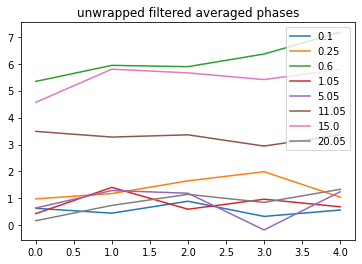

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                    time  n
0     0.100  0.578   0.108 2021-12-06 17:29:07.600  5
1     0.250  1.371   0.222 2021-12-06 17:29:18.800  5
2     0.600  6.139   0.346 2021-12-06 17:29:30.400  5
3     1.050  0.822   0.195 2021-12-06 17:29:42.600  5
4     5.050  0.842   0.318 2021-12-06 17:29:58.600  5
5    11.050  3.285   0.105 2021-12-06 17:30:20.400  5
6    15.000  5.445   0.263 2021-12-06 17:30:46.400  5
7    20.050  0.851   0.228 2021-12-06 17:31:17.400  5

choose resolution automatically: 0.002005
53792993.73840155


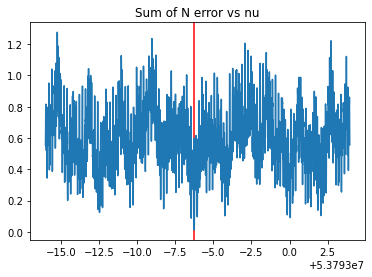

acc_time  phase  dphase                    time  n               N  N_intN
0     0.150  0.794   0.247 2021-12-06 17:29:18.800  5     8068948.934  -0.066
1     0.500  5.562   0.363 2021-12-06 17:29:30.400  5    26896495.984  -0.016
2     0.950  0.244   0.223 2021-12-06 17:29:42.600  5    51103344.013   0.013
3     4.950  0.265   0.336 2021-12-06 17:29:58.600  5   266275318.963  -0.037
4    10.950  2.708   0.151 2021-12-06 17:30:20.400  5   589033281.005   0.005
5    14.900  4.867   0.284 2021-12-06 17:30:46.400  5   801515605.928  -0.072
6    19.950  0.274   0.253 2021-12-06 17:31:17.400  5  1073170225.038   0.038

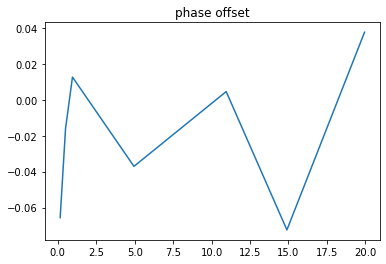


 °°° N = 1073170225.0  last phase = 0.27387551963329315  nu = 53792993.73840155  °°° 
 °°° guess = 53792993.96  diff = 0.22159845381975174  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.04269815594923502  °°° 
1 2 position_1
1 2 position_2
PnP False
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 0.1
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 1.05


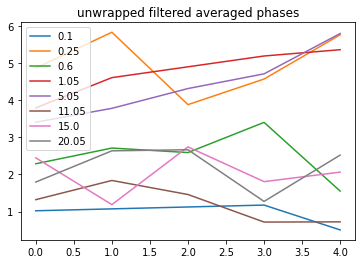

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                    time  n
0     0.100  0.903   0.267 2021-12-06 17:14:49.000  3
1     0.250  4.976   0.421 2021-12-06 17:14:13.600  5
2     0.600  2.507   0.343 2021-12-06 17:14:25.000  5
3     1.050  4.733   0.423 2021-12-06 17:14:37.000  4
4     5.050  4.397   0.471 2021-12-06 17:14:53.200  5
5    11.050  1.213   0.248 2021-12-06 17:15:15.200  5
6    15.000  2.049   0.306 2021-12-06 17:15:41.200  5
7    20.050  2.178   0.315 2021-12-06 17:16:12.200  5

choose resolution automatically: 0.002005
53772656.45276179


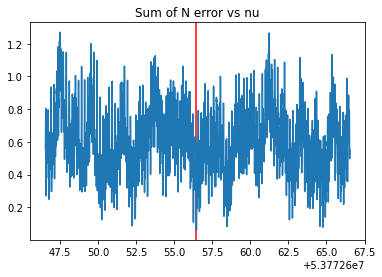

acc_time  phase  dphase                    time  n               N  N_intN
0     0.150  4.073   0.498 2021-12-06 17:14:13.600  5     8065897.820  -0.180
1     0.500  1.605   0.435 2021-12-06 17:14:25.000  5    26886327.971  -0.029
2     0.950  3.830   0.500 2021-12-06 17:14:37.000  4    51084023.021   0.021
3     4.950  3.494   0.542 2021-12-06 17:14:53.200  5   266174648.885  -0.115
4    10.950  0.310   0.364 2021-12-06 17:15:15.200  5   588810588.108   0.108
5    14.900  1.146   0.406 2021-12-06 17:15:41.200  5   801212580.964  -0.036
6    19.950  1.275   0.413 2021-12-06 17:16:12.200  5  1072764496.030   0.030

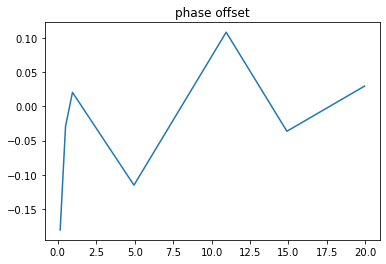


 °°° N = 1072764496.0  last phase = 1.2752634167671202  nu = 53772656.45276179  °°° 
 °°° guess = 53772656.53  diff = 0.07723820954561234  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.09332008229643467  °°° 
1 2 position_2
1 3 position_1
PnP False
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 15.0
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 20.05


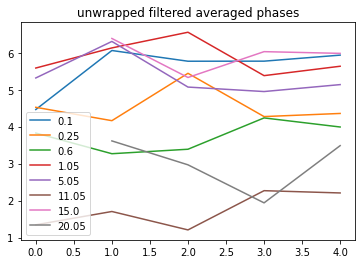

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                          time  n
0     0.100  5.600   0.330 2021-12-06 17:29:07.600000000  5
1     0.250  4.551   0.263 2021-12-06 17:29:19.000000000  5
2     0.600  3.742   0.208 2021-12-06 17:29:30.600000000  5
3     1.050  5.856   0.244 2021-12-06 17:29:42.600000000  5
4     5.050  5.356   0.279 2021-12-06 17:29:58.600000000  5
5    11.050  1.746   0.247 2021-12-06 17:30:20.400000000  5
6    15.000  5.931   0.263 2021-12-06 17:31:56.750000128  4
7    20.050  3.002   0.456 2021-12-06 17:32:27.750000128  4

choose resolution automatically: 0.002005
53775425.24068174


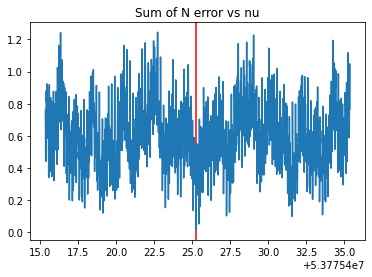

acc_time  phase  dphase                          time  n               N  \
0     0.150 -1.048   0.422 2021-12-06 17:29:19.000000000  5     8066313.953   
1     0.500 -1.857   0.390 2021-12-06 17:29:30.600000000  5    26887712.916   
2     0.950  0.257   0.410 2021-12-06 17:29:42.600000000  5    51086653.938   
3     4.950 -0.244   0.433 2021-12-06 17:29:58.600000000  5   266188354.980   
4    10.950 -3.853   0.413 2021-12-06 17:30:20.400000000  5   588840906.999   
5    14.900  0.332   0.422 2021-12-06 17:31:56.750000128  4   801253836.033   
6    19.950 -2.598   0.563 2021-12-06 17:32:27.750000128  4  1072819733.965   

   N_intN  
0  -0.047  
1  -0.084  
2  -0.062  
3  -0.020  
4  -0.001  
5   0.033  
6  -0.035

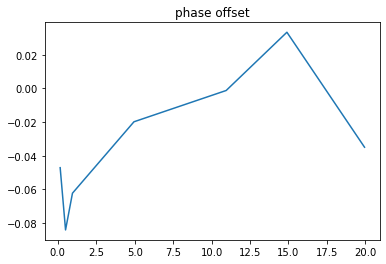


 °°° N = 1072819734.0  last phase = -2.5978725314140316  nu = 53775425.24068174  °°° 
 °°° guess = 53775425.35  diff = 0.10931826382875443  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.0476291543301996  °°° 
1 3 position_1
1 3 position_2
PnP False


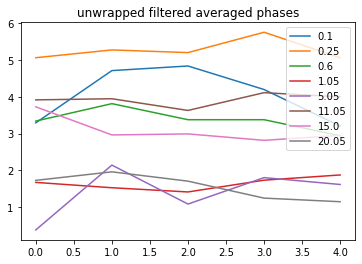

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                    time  n
0     0.100  4.046   0.392 2021-12-06 17:14:02.400  5
1     0.250  5.266   0.145 2021-12-06 17:14:13.800  5
2     0.600  3.369   0.157 2021-12-06 17:14:25.200  5
3     1.050  1.648   0.092 2021-12-06 17:14:37.200  5
4     5.050  1.409   0.351 2021-12-06 17:14:53.200  5
5    11.050  3.918   0.091 2021-12-06 17:15:15.200  5
6    15.000  3.090   0.185 2021-12-06 17:15:41.200  5
7    20.050  1.561   0.176 2021-12-06 17:16:12.200  5

choose resolution automatically: 0.002005
53795761.734766796


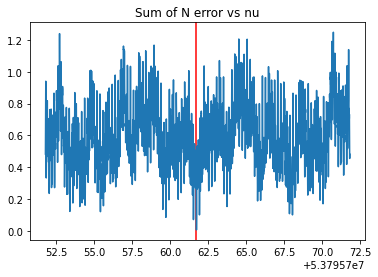

acc_time  phase  dphase                    time  n               N  N_intN
0     0.150  1.220   0.418 2021-12-06 17:14:13.800  5     8069364.066   0.066
1     0.500 -0.677   0.423 2021-12-06 17:14:25.200  5    26897880.975  -0.025
2     0.950 -2.399   0.403 2021-12-06 17:14:37.200  5    51105974.030   0.030
3     4.950 -2.637   0.526 2021-12-06 17:14:53.200  5   266289021.007   0.007
4    10.950 -0.128   0.403 2021-12-06 17:15:15.200  5   589063591.016   0.016
5    14.900 -0.957   0.434 2021-12-06 17:15:41.200  5   801556850.000   0.000
6    19.950 -2.485   0.430 2021-12-06 17:16:12.200  5  1073225447.004   0.004

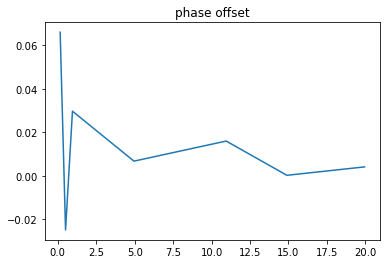


 °°° N = 1073225447.0  last phase = -2.4851775169372563  nu = 53795761.734766796  °°° 
 °°° guess = 53795761.81  diff = 0.07523320615291595  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.02974021709412435  °°° 
1 3 position_2
2 2 position_1
PnP False
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 3
filtered 3 in acc_time 0.25
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 0.6
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 3
filtered 3 in acc_time 1.05
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 3
filtered 3 in acc_time 5.05
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 3
filtered 3 in acc_time 11.05
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 15.0
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 3
filtered 3 in acc_time 20.05


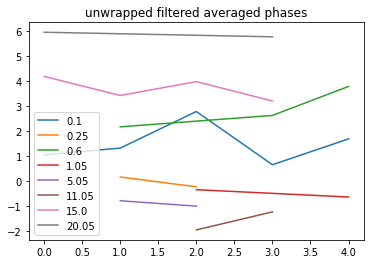

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                          time  n
0     0.100  1.489   0.414 2021-12-07 06:04:41.600000000  5
1     0.250 -0.042   0.362 2021-12-07 06:03:41.000000000  2
2     0.600  2.851   0.636 2021-12-07 06:06:41.666666752  3
3     1.050 -0.500   0.268 2021-12-07 06:07:42.500000000  2
4     5.050 -0.904   0.198 2021-12-07 06:04:22.000000000  2
5    11.050 -1.601   0.663 2021-12-07 06:07:09.000000000  2
6    15.000  3.688   0.276 2021-12-07 06:05:10.750000128  4
7    20.050  5.851   0.168 2021-12-07 06:05:42.500000000  2

choose resolution automatically: 0.002005
53792998.68073491


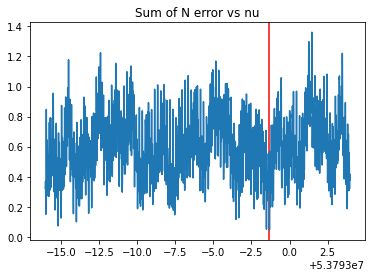

acc_time  phase  dphase                          time  n               N  \
0     0.150 -1.531   0.550 2021-12-07 06:03:41.000000000  2     8068950.046   
1     0.500  1.362   0.758 2021-12-07 06:06:41.666666752  3    26896499.124   
2     0.950 -1.989   0.493 2021-12-07 06:07:42.500000000  2    51103349.063   
3     4.950 -2.393   0.459 2021-12-07 06:04:22.000000000  2   266275343.850   
4    10.950 -3.090   0.782 2021-12-07 06:07:09.000000000  2   589033336.046   
5    14.900  2.199   0.497 2021-12-07 06:05:10.750000128  4   801515679.993   
6    19.950  4.362   0.447 2021-12-07 06:05:42.500000000  2  1073170322.986   

   N_intN  
0   0.046  
1   0.124  
2   0.063  
3  -0.150  
4   0.046  
5  -0.007  
6  -0.014

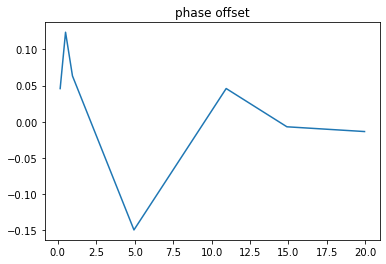


 °°° N = 1073170323.0  last phase = 4.36205358505249  nu = 53792998.68073491  °°° 
 °°° guess = 53792993.96  diff = -4.7207349091768265  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.0811537795937068  °°° 
2 2 position_1
2 2 position_2
PnP False
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 0.1
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 0.25
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 3
filtered 3 in acc_time 1.05
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 11.05
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 15.0
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 20.05


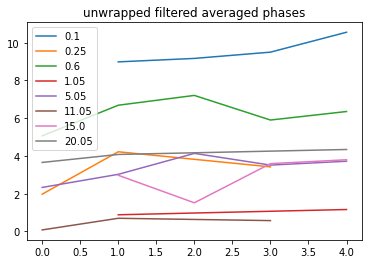

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                          time  n
0     0.100  9.549   0.420 2021-12-07 05:50:32.000000000  4
1     0.250  3.205   0.868 2021-12-07 05:47:55.333333248  3
2     0.600  6.242   0.415 2021-12-07 05:49:43.400000000  5
3     1.050  1.023   0.256 2021-12-07 05:51:08.000000000  2
4     5.050  3.345   0.354 2021-12-07 05:50:12.200000000  5
5    11.050  0.451   0.249 2021-12-07 05:48:58.666666752  3
6    15.000  2.970   0.616 2021-12-07 05:52:13.000000000  4
7    20.050  4.025   0.264 2021-12-07 05:50:44.333333248  3

choose resolution automatically: 0.002005
53772660.60512382


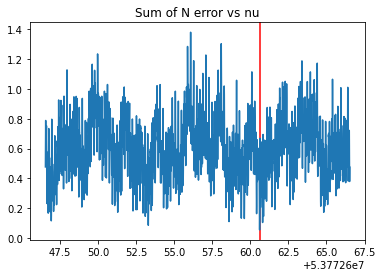

acc_time  phase  dphase                          time  n               N  \
0     0.150 -6.344   0.965 2021-12-07 05:47:55.333333248  3     8065900.100   
1     0.500 -3.308   0.590 2021-12-07 05:49:43.400000000  5    26886330.829   
2     0.950 -8.527   0.492 2021-12-07 05:51:08.000000000  2    51084028.932   
3     4.950 -6.204   0.549 2021-12-07 05:50:12.200000000  5   266174670.983   
4    10.950 -9.098   0.488 2021-12-07 05:48:58.666666752  3   588810635.074   
5    14.900 -6.579   0.746 2021-12-07 05:52:13.000000000  4   801212644.063   
6    19.950 -5.524   0.496 2021-12-07 05:50:44.333333248  3  1072764579.951   

   N_intN  
0   0.100  
1  -0.171  
2  -0.068  
3  -0.017  
4   0.074  
5   0.063  
6  -0.049

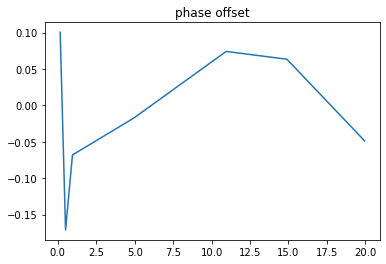


 °°° N = 1072764580.0  last phase = -5.524131719266073  nu = 53772660.60512382  °°° 
 °°° guess = 53772656.53  diff = -4.075123816728592  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.08956703625812804  °°° 
2 2 position_2
2 3 position_1
PnP False
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 0.1
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 0.25
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 0.6
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 1.05
filtered 1
filtered 3sigma phase 1
filtered 1 in acc_time 11.05
filtered 1
filtered 1
filtered 3sigma phase 2
filtered 2 in acc_time 15.0
filtered 1
filtered 1
filtered 1
filtered 1
filtered 3sigma phase 4
filtered 4 in acc_time 20.05


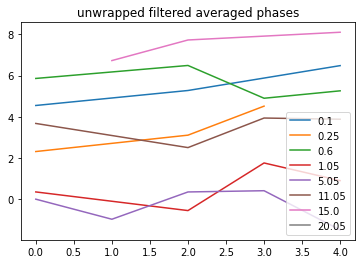

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                          time  n
0     0.100  5.433   0.745 2021-12-07 06:04:41.666666752  3
1     0.250  3.311   0.851 2021-12-07 06:04:05.333333248  3
2     0.600  5.625   0.418 2021-12-07 06:05:41.500000000  4
3     1.050  0.615   0.580 2021-12-07 06:05:54.000000000  4
4     5.050 -0.339   0.433 2021-12-07 06:05:34.200000000  5
5    11.050  3.499   0.403 2021-12-07 06:06:32.750000128  4
6    15.000  7.516   0.542 2021-12-07 06:07:11.333333248  3
7    20.050  0.958   1.745 2021-12-07 06:06:55.000000000  1

choose resolution automatically: 0.002005
53775418.213144846


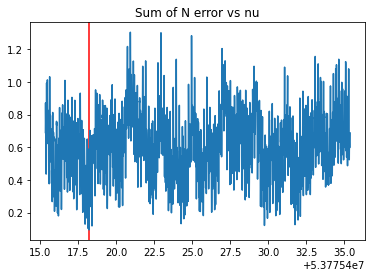

acc_time  phase  dphase                          time  n               N  \
0     0.150 -2.122   1.131 2021-12-07 06:04:05.333333248  3     8066313.070   
1     0.500  0.192   0.854 2021-12-07 06:05:41.500000000  4    26887709.076   
2     0.950 -4.818   0.944 2021-12-07 06:05:54.000000000  4    51086648.069   
3     4.950 -5.772   0.862 2021-12-07 06:05:34.200000000  5   266188321.074   
4    10.950 -1.934   0.847 2021-12-07 06:06:32.750000128  4   588840829.742   
5    14.900  2.083   0.921 2021-12-07 06:07:11.333333248  3   801253731.044   
6    19.950 -4.475   1.898 2021-12-07 06:06:55.000000000  1  1072819594.065   

   N_intN  
0   0.070  
1   0.076  
2   0.069  
3   0.074  
4  -0.258  
5   0.044  
6   0.065

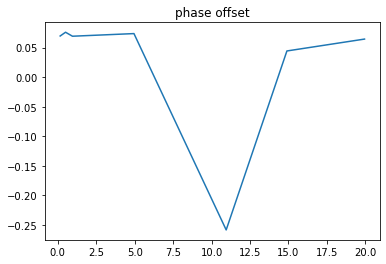


 °°° N = 1072819594.0  last phase = -4.475265017481213  nu = 53775418.213144846  °°° 
 °°° guess = 53775425.35  diff = 7.1368551552295685  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.11569743538008694  °°° 
2 3 position_1
2 3 position_2
PnP False


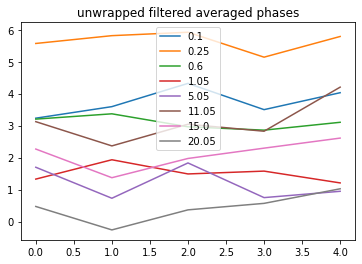

>>> WARNING: phase offset applied 0

 °°° N determination °°° 


acc_time  phase  dphase                    time  n
0     0.100  3.735   0.222 2021-12-07 05:49:19.800  5
1     0.250  5.646   0.158 2021-12-07 05:49:31.400  5
2     0.600  3.099   0.102 2021-12-07 05:49:43.400  5
3     1.050  1.506   0.142 2021-12-07 05:49:55.800  5
4     5.050  1.190   0.272 2021-12-07 05:50:12.200  5
5    11.050  3.112   0.346 2021-12-07 05:50:34.800  5
6    15.000  2.103   0.239 2021-12-07 05:51:01.000  5
7    20.050  0.433   0.236 2021-12-07 05:51:32.400  5

choose resolution automatically: 0.002005
53795761.728751786


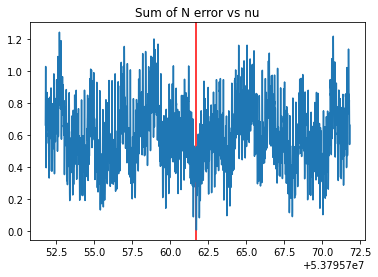

acc_time  phase  dphase                    time  n               N  N_intN
0     0.150  1.911   0.273 2021-12-07 05:49:31.400  5     8069363.955  -0.045
1     0.500 -0.636   0.245 2021-12-07 05:49:43.400  5    26897880.966  -0.034
2     0.950 -2.229   0.264 2021-12-07 05:49:55.800  5    51105973.997  -0.003
3     4.950 -2.545   0.352 2021-12-07 05:50:12.200  5   266289020.962  -0.038
4    10.950 -0.623   0.411 2021-12-07 05:50:34.800  5   589063591.029   0.029
5    14.900 -1.632   0.326 2021-12-07 05:51:01.000  5   801556850.018   0.018
6    19.950 -3.302   0.324 2021-12-07 05:51:32.400  5  1073225447.014   0.014

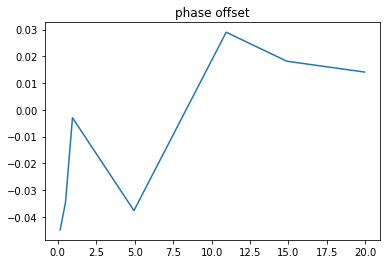


 °°° N = 1073225447.0  last phase = -3.302026260692814  nu = 53795761.728751786  °°° 
 °°° guess = 53795761.81  diff = 0.0812482163310051  °°° 
 °°° root mean square N-int(N) (2nd order banana) = 0.029280255104912906  °°° 
2 3 position_2


mcycle trap    position           N  end_phase          nu_p      ion  \
0      1    2  position_1  1073170225      0.274  53792993.738  20Ne10+   
1      1    2  position_2  1072764496      1.275  53772656.453    12C6+   
2      1    3  position_1  1072819734     -2.598  53775425.241    12C6+   
3      1    3  position_2  1073225447     -2.485  53795761.735  20Ne10+   
4      2    2  position_1  1073170323      4.362  53792998.681  20Ne10+   
5      2    2  position_2  1072764580     -5.524  53772660.605    12C6+   
6      2    3  position_1  1072819594     -4.475  53775418.213    12C6+   
7      2    3  position_2  1073225447     -3.302  53795761.729  20Ne10+   

                  time  max_acc_time  Nquality mtype  
0  1638811877400000000        19.950     0.043   PnP  
1  1638810972200000000        19.950     0.093   PnP  
2  1638811947750000128        19.950     0.048   PnP  
3  1638810972200000000        19.950     0.030   PnP  
4  1638857142500000000        19.950     0.081   PnP  
5  1638856244333333248        19.950     0.090   PnP  
6  1638857215000000000        19.950     0.116   PnP  
7  1638856292400000000        19.950     0.029   PnP

In [4]:
# each ion in each trap its own N determination, for every main cycle! (no grouping here, wouldn't make any sense)

nu_p_unwrap.to_csv(results_dir + "step3_unwrap_p_phases.csv")
nu_p_unwrap.to_csv(results_dir + "step3_unwrap_p_phases.txt", sep="\t")

columns = ["mcycle", "trap", "position", "N", "end_phase", "nu_p", "ion", "time", "max_acc_time", "Nquality", "mtype"]
nu_p_N = pd.DataFrame(columns = columns)

for mc in mcs:
    for trap in traps:
        for pos in positions:
            print(mc, trap, pos)
            subset = nu_p_unwrap[(nu_p_unwrap["mcycle"] == mc) & (nu_p_unwrap["trap"] == trap) & (nu_p_unwrap["position"] == pos)]
            #subset["acc_time"] += 0.01

            #subset = subset[subset["acc_time"] != subset["acc_time"].max()]
            
            # NOTE: if the structure of the config changed, you have to adjust here!
            nu_p_guess = meas_config[pos]["configuration"]["traps"][trap]["nu_p"]
            mtype = meas_config[pos]["configuration"].get('type', meas_config.get('type', "PnP"))

            if mtype == 'PnA':
                nphase = True
            else:
                nphase = False
            print(mtype, nphase)
    
            ion_str = meas_config[pos]["configuration"]["traps"][trap]["ion"]
            #evolution_time = abs(meas_config["accumulation_time"][0]["time"] - meas_config["accumulation_time"][1]["time"])

            #print(" >>> mc", mc, "trap", trap, "pos", pos, " <<< ")
            try:
                nu_range = settings.get("unwrap_range", 12)
                avg_subset = phase_analysis.prepare_unwrap_phases(subset, val="phase", show=True)
                phase_offset = settings.get("phase_offset", {}).get(trap, 0)
                if mtype == 'PnA':
                    phase_offset *= -1
                print(">>> WARNING: phase offset applied", phase_offset) # sign is flipped in unwrap
                #avg_subset['phase'] += 1.1
                #display(avg_subset)
                N, end_phase, nu_p, mean_time, max_acc_time, Nquality = phase_analysis.determine_N(avg_subset, nu_p_guess, 
                                                                        negative=nphase, resolution=None, nu_range=nu_range, show=show_tag, acc_time_digits=3, drop_accs=settings.get("unwrap_drop", None), phase_offset=phase_offset)
                new_row = pd.Series([mc, trap, pos, N, end_phase, nu_p, ion_str, mean_time, max_acc_time, Nquality, mtype], index=nu_p_N.columns )
                print(mc, trap, pos)

                nu_p_N = nu_p_N.append(new_row, ignore_index=True)
            except:
                raise

# show results and save to csv in results folder
display(nu_p_N)
nu_p_N.to_csv(results_dir + "step4_nu_p_N.csv")
nu_p_N.to_csv(results_dir + "step4_nu_p_N.txt", sep="\t")

In [5]:
for grpname, grp in nu_p_N.groupby(['mcycle', 'trap']): #1707832976
    m, t = grpname
    Bfielddrift = 1e-10 # per hour
    timediff = (grp.iloc[0]['time'] - grp.iloc[1]['time'])/1e9/60/60
    timediff = 0
    print(timediff)
    relchange = timediff*Bfielddrift + 1
    pos1 = grp.iloc[0]['position']
    pos2 = grp.iloc[1]['position']
    ion1 = grp.iloc[0]['ion']
    ion2 = grp.iloc[1]['ion']
    r = abs(grp.iloc[0]['nu_p']) / abs(grp.iloc[1]['nu_p'])*relchange
    print("mcycle, trap, posnum, posdenom ionnum, iondenom, ratio-1, 1/ratio-1\t\t", m, t, "\t", pos1, pos2, "\t", ion1, ion2, r-1, 1/r-1)

0
mcycle, trap, posnum, posdenom ionnum, iondenom, ratio-1, 1/ratio-1		 1 2 	 position_1 position_2 	 20Ne10+ 12C6+ 0.0003782086841408461 -0.0003780656964113005
0
mcycle, trap, posnum, posdenom ionnum, iondenom, ratio-1, 1/ratio-1		 1 3 	 position_1 position_2 	 12C6+ 20Ne10+ -0.0003780315294228398 0.00037817449130428393
0
mcycle, trap, posnum, posdenom ionnum, iondenom, ratio-1, 1/ratio-1		 2 2 	 position_1 position_2 	 20Ne10+ 12C6+ 0.00037822334588288875 -0.0003780803470689875
0
mcycle, trap, posnum, posdenom ionnum, iondenom, ratio-1, 1/ratio-1		 2 3 	 position_1 position_2 	 12C6+ 20Ne10+ -0.0003781620513064743 0.00037830511194369976


In [6]:
nu_p_N["Nplus"] = 0
backup_nu_p_N = nu_p_N.copy(deep=True)
display(nu_p_N)

print("1/N", 1/float(nu_p_N.tail(1).N))
Npos1 = abs(float(nu_p_N.tail(2).iloc[0].N))
Npos2 = abs(float(nu_p_N.tail(1).N))
Nratio = Npos1/Npos2
dR = 0
i = 0
pcount = 0
while dR < 1e-10:
    i +=1
    dR = (Npos1+i)/(Npos2+i) - Nratio
    if dR > 1e-12:
        print(i, dR)
        pcount += 1
        if pcount > 10:
            break
    if i > 1e6:
        print("N diff already bigger than 1e6")
        break
    
print("N+1/N+1 - N/N", (Npos1+1)/(Npos2+1) - Nratio)
print("N+2/N+2 - N/N", (Npos1+2)/(Npos2+2) - Nratio)
print("N+3/N+3 - N/N", (Npos1+3)/(Npos2+3) - Nratio)
print("N+4/N+4 - N/N", (Npos1+4)/(Npos2+4) - Nratio)
print("N+2/N+1 - N/N", (Npos1+2)/(Npos2+1) - Nratio)
print("2/N", 2/float(nu_p_N.tail(1).N))
print("3/N", 3/float(nu_p_N.tail(1).N))
print("18/N", 18/float(nu_p_N.tail(1).N))

print('tevol dnu(N+1)')
print(float(nu_p_N.tail(1).max_acc_time), 1/float(nu_p_N.tail(1).max_acc_time))
print(40, 1/40)
print(70, 1/70)
print(90, 1/90)
print(120, 1/120)
print(150, 1/150)
print(200, 1/200)

# check for reasonable N:
try:
    rfirst = None
    ionA, ionB = nu_p_N.ion.unique()
    ion_mass_ratio = ame.get_ion_mass(ionA)[0]/ame.get_ion_mass(ionB)[0]
    if ion_mass_ratio < 1: ion_mass_ratio = 1/ion_mass_ratio
    print("literature ion mass ratio", ion_mass_ratio)
    for gname, grp in nu_p_N.groupby(["mcycle", "trap"]):
        mc, tr = gname
        nu_pA = float(grp[grp.ion == ionA].nu_p)
        nu_pB = float(grp[grp.ion == ionB].nu_p)
        posA = grp[grp.ion == ionA].position.iloc[0]
        posB = grp[grp.ion == ionB].position.iloc[0]
        axial_grp = axial_data[(axial_data["mcycle"] == mc) & (axial_data["trap"] == tr) ]
        nu_zA = float(axial_grp[axial_grp.position == posA].nu_z.mean())
        nu_zB = float(axial_grp[axial_grp.position == posB].nu_z.mean())
        nu_mA = meas_config[posA]["configuration"]["traps"][tr]["nu_m"]
        nu_mB = meas_config[posB]["configuration"]["traps"][tr]["nu_m"]

        this_R = np.sqrt(nu_pA**2 + nu_zA**2 + nu_mA**2) / np.sqrt(nu_pB**2 + nu_zB**2 + nu_mB**2)
        if this_R < 1: this_R = 1/this_R
        if rfirst is None:
            rfirst = this_R
        print(gname, this_R, this_R - ion_mass_ratio, this_R-rfirst)
except:
    pass
    

mcycle trap    position           N  end_phase          nu_p      ion  \
0      1    2  position_1  1073170225      0.274  53792993.738  20Ne10+   
1      1    2  position_2  1072764496      1.275  53772656.453    12C6+   
2      1    3  position_1  1072819734     -2.598  53775425.241    12C6+   
3      1    3  position_2  1073225447     -2.485  53795761.735  20Ne10+   
4      2    2  position_1  1073170323      4.362  53792998.681  20Ne10+   
5      2    2  position_2  1072764580     -5.524  53772660.605    12C6+   
6      2    3  position_1  1072819594     -4.475  53775418.213    12C6+   
7      2    3  position_2  1073225447     -3.302  53795761.729  20Ne10+   

                  time  max_acc_time  Nquality mtype  Nplus  
0  1638811877400000000        19.950     0.043   PnP      0  
1  1638810972200000000        19.950     0.093   PnP      0  
2  1638811947750000128        19.950     0.048   PnP      0  
3  1638810972200000000        19.950     0.030   PnP      0  
4  1638857142500000000        19.950     0.081   PnP      0  
5  1638856244333333248        19.950     0.090   PnP      0  
6  1638857215000000000        19.950     0.116   PnP      0  
7  1638856292400000000        19.950     0.029   PnP      0

1/N 9.317706757655738e-10
3 1.0570433417456115e-12
4 1.4094281297616362e-12
5 1.761812917777661e-12
6 2.1141977057936856e-12
7 2.4664714715072478e-12
8 2.8188562595232725e-12
9 3.171241047539297e-12
10 3.523625835555322e-12
11 3.875899601268884e-12
12 4.228284389284909e-12
13 4.580669177300933e-12
N+1/N+1 - N/N 3.523847880160247e-13
N+2/N+2 - N/N 7.046585537295869e-13
N+3/N+3 - N/N 1.0570433417456115e-12
N+4/N+4 - N/N 1.4094281297616362e-12
N+2/N+1 - N/N 9.321230454162333e-10
2/N 1.8635413515311477e-09
3/N 2.7953120272967213e-09
18/N 1.6771872163780327e-08
tevol dnu(N+1)
19.95 0.050125313283208024
40 0.025
70 0.014285714285714285
90 0.011111111111111112
120 0.008333333333333333
150 0.006666666666666667
200 0.005
literature ion mass ratio 1.666036669097717
(1, 2) 1.0003781378136347 -0.6656585312840824 0.0
(1, 3) 1.0003781415968704 -0.6656585275008466 3.783235724696965e-09
(2, 2) nan nan nan
(2, 3) nan nan nan


# Fix Ndet Ns by comparing ratio to literature value
you can do this, because an error of N+1 in one position is (depending on the measurement case) most often bigger than the precision already reached with the Ndetermination measurement.

# display(backup_nu_p_N)

In [7]:
nu_p_N = backup_nu_p_N.copy(deep=True)

In [8]:
# modify an N:
#nu_p_N.at[0, "N"] += 1 # t2 pos 1
#nu_p_N.at[1, "N"] -= 2
#nu_p_N.at[0, "N"] += -1 # t2 pos 2
#nu_p_N.at[4, "N"] += -1
#nu_p_N.at[3, "N"] += 1 # t3 pos 1
#nu_p_N.at[6, "N"] += -60
#nu_p_N.at[2, "N"] += -1 # t3 pos 2
#nu_p_N.at[6, "N"] += -1
#nu_p_N.at[2, "N"] -= 2
display(nu_p_N)
nu_p_N.at[1, "Nplus"] = 0
nu_p_N.at[3, "Nplus"] = 0
display(nu_p_N)

for grpname, grp in nu_p_N.groupby(["mcycle", "trap"]):
    Ns = grp.N.to_numpy()
    Nps = grp.Nplus.to_numpy()
    Ns += Nps
    r = Ns[0]/Ns[1]
    if r<1:
        r = 1/r
    nups = grp.N.to_numpy()
    nupps = Nps*grp.max_acc_time.max()
    print(nupps)
    nups += nupps
    r2 = nups[0]/nups[1]
    if r2<1:
        r2 = 1/r2
    print(grpname, r, r2)

mcycle trap    position           N  end_phase          nu_p      ion  \
0      1    2  position_1  1073170225      0.274  53792993.738  20Ne10+   
1      1    2  position_2  1072764496      1.275  53772656.453    12C6+   
2      1    3  position_1  1072819734     -2.598  53775425.241    12C6+   
3      1    3  position_2  1073225447     -2.485  53795761.735  20Ne10+   
4      2    2  position_1  1073170323      4.362  53792998.681  20Ne10+   
5      2    2  position_2  1072764580     -5.524  53772660.605    12C6+   
6      2    3  position_1  1072819594     -4.475  53775418.213    12C6+   
7      2    3  position_2  1073225447     -3.302  53795761.729  20Ne10+   

                  time  max_acc_time  Nquality mtype  Nplus  
0  1638811877400000000        19.950     0.043   PnP      0  
1  1638810972200000000        19.950     0.093   PnP      0  
2  1638811947750000128        19.950     0.048   PnP      0  
3  1638810972200000000        19.950     0.030   PnP      0  
4  1638857142500000000        19.950     0.081   PnP      0  
5  1638856244333333248        19.950     0.090   PnP      0  
6  1638857215000000000        19.950     0.116   PnP      0  
7  1638856292400000000        19.950     0.029   PnP      0

mcycle trap    position           N  end_phase          nu_p      ion  \
0      1    2  position_1  1073170225      0.274  53792993.738  20Ne10+   
1      1    2  position_2  1072764496      1.275  53772656.453    12C6+   
2      1    3  position_1  1072819734     -2.598  53775425.241    12C6+   
3      1    3  position_2  1073225447     -2.485  53795761.735  20Ne10+   
4      2    2  position_1  1073170323      4.362  53792998.681  20Ne10+   
5      2    2  position_2  1072764580     -5.524  53772660.605    12C6+   
6      2    3  position_1  1072819594     -4.475  53775418.213    12C6+   
7      2    3  position_2  1073225447     -3.302  53795761.729  20Ne10+   

                  time  max_acc_time  Nquality mtype  Nplus  
0  1638811877400000000        19.950     0.043   PnP      0  
1  1638810972200000000        19.950     0.093   PnP     -4  
2  1638811947750000128        19.950     0.048   PnP      0  
3  1638810972200000000        19.950     0.030   PnP      0  
4  1638857142500000000        19.950     0.081   PnP      0  
5  1638856244333333248        19.950     0.090   PnP      0  
6  1638857215000000000        19.950     0.116   PnP      0  
7  1638856292400000000        19.950     0.029   PnP      0

[  0.  -79.8]
(1, 2) 1.000378212555529 1.0003782869709181
[0. 0.]
(1, 3) 1.000378174438018 1.000378174438018
[0. 0.]
(2, 2) 1.0003782218462134 1.0003782218462134
[0. 0.]
(2, 3) 1.0003783049846124 1.0003783049846124


### Step 5: Frequency determination from phase data

The phase data (in this case just for the nu_p phase measurement) is now evaluated to determine the corresponding frequency.

The procedure is split into to parts (two cells) and a last cell for data-handling.

#### Cell 1: Unwrapping subcycles / substract reference / unwrap main cycle / assign phase error / 3 sigma phase filter (masked)

#### Cell 2: Unwrap relative to N determination phase / Calc nu_p via phase data and N determination data (pre or post unwrap data)

#### Cell 3: The frequency determination is finished, but data has to be averaged or exanded now for the next anaylsis steps.

mcycle  cycle    position  trap  acc_time                       time  \
0          1      1  position_1     2     0.100 2021-12-06 17:50:25.000962   
1          1      1  position_1     2     0.100 2021-12-06 17:51:09.514817   
2          1      1  position_1     2     0.100 2021-12-06 17:51:54.032852   
3          1      1  position_1     2     0.100 2021-12-06 17:52:38.413269   
4          1      1  position_1     2     0.100 2021-12-06 17:53:22.814691   
...      ...    ...         ...   ...       ...                        ...   
1555       1     19  position_2     3    20.050 2021-12-06 23:55:34.557587   
1556       1     19  position_2     3    20.050 2021-12-06 23:56:19.328990   
1557       1     19  position_2     3    20.050 2021-12-06 23:57:04.098273   
1558       1     19  position_2     3    20.050 2021-12-06 23:57:48.785628   
1559       1     19  position_2     3    20.050 2021-12-06 23:58:33.392139   

      phase  average_idx      amp        peak  masked  
0     0.253            0  129.796  736052.602   False  
1     1.041            0  134.449  736091.507   False  
2     3.260            0  109.463  736120.310   False  
3     5.801            0  136.657  736085.706   False  
4     0.775            0  133.846  736093.907   False  
...     ...          ...      ...         ...     ...  
1555  2.174            0  136.918  501495.704   False  
1556  4.088            0  123.690  501541.395   False  
1557  1.697            0  138.342  501500.603   False  
1558  2.449            0  133.279  501508.501   False  
1559  2.302            0  137.247  501505.402   False  

[1560 rows x 11 columns]

(1, 2, 'position_1') ref phase jitter 50.05442759683251
(1, 2, 'position_2') ref phase jitter 397.84774422717106
(1, 3, 'position_1') ref phase jitter 170.2557661156812
(1, 3, 'position_2') ref phase jitter 28.092743608680646


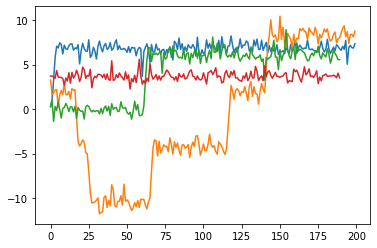

In [9]:
display(nu_p_phases)

# just check some phase stabilities to have something to look at when your bored.
for grpname, grp in nu_p_phases.groupby(["mcycle", "trap", "position"]):
    ref_acc = grp["acc_time"].min()
    ref_phases = np.unwrap(grp[grp["acc_time"] == ref_acc].phase.to_numpy())
    plt.plot(ref_phases)
    print(grpname, "ref phase jitter", ref_phases.std()*180/np.pi)

mcycle  cycle    position  trap  acc_time                       time  \
0          1      1  position_1     2     0.100 2021-12-06 17:50:25.000962   
1          1      1  position_1     2     0.100 2021-12-06 17:51:09.514817   
2          1      1  position_1     2     0.100 2021-12-06 17:51:54.032852   
3          1      1  position_1     2     0.100 2021-12-06 17:52:38.413269   
4          1      1  position_1     2     0.100 2021-12-06 17:53:22.814691   
...      ...    ...         ...   ...       ...                        ...   
1555       1     19  position_2     3    20.050 2021-12-06 23:55:34.557587   
1556       1     19  position_2     3    20.050 2021-12-06 23:56:19.328990   
1557       1     19  position_2     3    20.050 2021-12-06 23:57:04.098273   
1558       1     19  position_2     3    20.050 2021-12-06 23:57:48.785628   
1559       1     19  position_2     3    20.050 2021-12-06 23:58:33.392139   

      phase  average_idx      amp        peak  masked  
0     0.253            0  129.796  736052.602   False  
1     1.041            0  134.449  736091.507   False  
2     3.260            0  109.463  736120.310   False  
3     5.801            0  136.657  736085.706   False  
4     0.775            0  133.846  736093.907   False  
...     ...          ...      ...         ...     ...  
1555  2.174            0  136.918  501495.704   False  
1556  4.088            0  123.690  501541.395   False  
1557  1.697            0  138.342  501500.603   False  
1558  2.449            0  133.279  501508.501   False  
1559  2.302            0  137.247  501505.402   False  

[1560 rows x 11 columns]

mcycle, trap, pos (1, 2, 'position_1')
[0.049489128012 0.229556608238] [0.021035764191 0.112300250177]


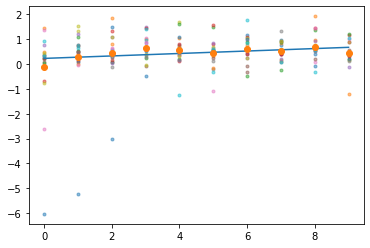

first vs last Ks_2sampResult(statistic=0.25, pvalue=0.571336004933722)
second vs last Ks_2sampResult(statistic=0.2, pvalue=0.8319696107963263)
first vs prelast Ks_2sampResult(statistic=0.55, pvalue=0.00396729438660086)
first and second vs prelast and last Ks_2sampResult(statistic=0.225, pvalue=0.2656871402817289)
mcycle, trap, pos (1, 2, 'position_2')
[0.015733963121 1.282264360299] [0.011052520258 0.059004311838]


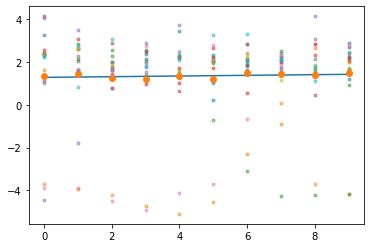

first vs last Ks_2sampResult(statistic=0.25, pvalue=0.571336004933722)
second vs last Ks_2sampResult(statistic=0.2, pvalue=0.8319696107963263)
first vs prelast Ks_2sampResult(statistic=0.3, pvalue=0.33559098126008213)
first and second vs prelast and last Ks_2sampResult(statistic=0.2, pvalue=0.404587405685253)
mcycle, trap, pos (1, 3, 'position_1')
[ 0.029792839221 -0.017250284807] [0.022042541632 0.11767497094 ]


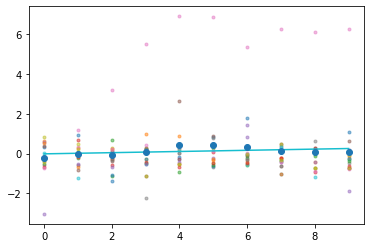

first vs last Ks_2sampResult(statistic=0.15789473684210525, pvalue=0.978077940445305)
second vs last Ks_2sampResult(statistic=0.3157894736842105, pvalue=0.3056890512159651)
first vs prelast Ks_2sampResult(statistic=0.2631578947368421, pvalue=0.5379287210186275)
first and second vs prelast and last Ks_2sampResult(statistic=0.18421052631578946, pvalue=0.5452867518859059)
mcycle, trap, pos (1, 3, 'position_2')
[-0.002615890853 -2.574475003805] [0.010980037205 0.058617358223]


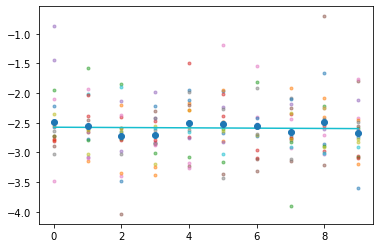

first vs last Ks_2sampResult(statistic=0.21052631578947367, pvalue=0.808061649945869)
second vs last Ks_2sampResult(statistic=0.21052631578947367, pvalue=0.808061649945869)
first vs prelast Ks_2sampResult(statistic=0.21052631578947367, pvalue=0.808061649945869)
first and second vs prelast and last Ks_2sampResult(statistic=0.18421052631578946, pvalue=0.5452867518859059)


In [10]:
display(nu_p_phases)
from scipy.stats import ks_2samp

# check systematic drift of the reference phase
for grpname, grp in nu_p_phases.groupby(["mcycle", "trap", "position"]):
    try:
        print("mcycle, trap, pos", grpname)
        ref_acc = grp["acc_time"].min()
        ref_phases = grp[grp["acc_time"] == ref_acc]
        c1 = grp["cycle"].min()
        Nsubcycles = len(ref_phases[ref_phases["cycle"] == c1])
        avg_phases = np.zeros(Nsubcycles)
        x = np.arange(0, Nsubcycles)
        #print(x)
        Ncycles = 0
        first = []
        second = []
        prelast = []
        last = []
        for subc, cgrp in ref_phases.groupby(["cycle"]):
            cgrp.sort_values("time", inplace=True)
            #display(cgrp)
            thesephases = np.unwrap(cgrp.phase.to_numpy())
            if np.mean(thesephases) > np.pi:
                thesephases -= 2*np.pi
            #print(thesephases)
            first.append(thesephases[0])
            second.append(thesephases[1])
            prelast.append(thesephases[-2])
            last.append(thesephases[-1])
            plt.plot(x, thesephases, ".", alpha=0.5)
            avg_phases += thesephases
            Ncycles += 1
        avg_phases /= Ncycles
        popt, pcov = np.polyfit(x, avg_phases, 1, cov=True)
        perr = np.sqrt(np.diag(pcov))
        print(popt, perr)
        plt.plot(x, np.polyval(popt, x))
        plt.plot(x, avg_phases, "o")

        plt.show()

        print("first vs last", ks_2samp(first, last))
        print("second vs last", ks_2samp(second, last))
        print("first vs prelast", ks_2samp(first, prelast))
        print("first and second vs prelast and last", ks_2samp(first+second, prelast+last))
    except:
        pass

(2, 'position_1', 1)
filtered 1
filtered 1
filtered 1
filtered 1
filtered 1
filtered 1
filtered 1
filtered 3sigma amp 7
0.5007342398166656 [-0.341297835112  0.134368032217  0.542142480612 -0.134368032217
 -1.566539500152  0.465138465166 -0.369880378246 -0.4073144719
  0.500839561224  3.170029252768]
residuals unwrap: idx, mean, resi, val_before, val_new  120 0.5007342398166656 3.1700292527675633 3.670763492584229 -2.6124218145953573
7.438374106084005 [-1.783050600682  0.340330839157 -0.577311098576  0.121546268463
  0.321904420853 -0.09103167057  -0.375567555428  0.094448924065
  0.09103167057  -3.822240177785]
residuals unwrap: idx, mean, resi, val_before, val_new  299 7.438374106084005 -3.822240177785055 3.61613392829895 9.899319235478536
0.4923468232154847 [-1.89262652794  -0.197015464306  0.058776220307 -0.057648479939
  0.809690952301 -0.08563297987   0.057648479939  0.537182152271
 -0.175915598869  3.258283619081]
residuals unwrap: idx, mean, resi, val_before, val_new  149 0.4923

0 1638812611.5 0.0
0 1638836152.3 5.942871991788046
0 1638836152.3 5.942871991788046
(3, 'position_1', 1)
filtered 1
filtered 1
filtered 1
filtered 1
filtered 1
filtered 1
filtered 1
filtered 3sigma amp 7
5.933989524841309 [ 0.151658535004  0.384190738444 -1.903787612915  0.377509547641
 -0.340980052948 -0.181627750397  0.741036210452  0.969151918088
 -0.151658535004 -5.787310153246]
residuals unwrap: idx, mean, resi, val_before, val_new  942 5.933989524841309 -5.787310153245926 0.1466793715953827 6.429864678774969
2.065750466781207 [-6.618462668853 -5.926346408325 -4.907553302246 -1.949530290561
 -0.122974353033  0.411639733118  0.122974353033  0.441091971593
  0.417182879644  1.555770354467]
residuals unwrap: idx, mean, resi, val_before, val_new  20 2.065750466781207 -6.6184626688533506 -4.5527122020721436 1.7304731051074427
residuals unwrap: idx, mean, resi, val_before, val_new  21 2.065750466781207 -5.926346408324786 -3.860595941543579 2.422589365636007
residuals unwrap: idx, mean,

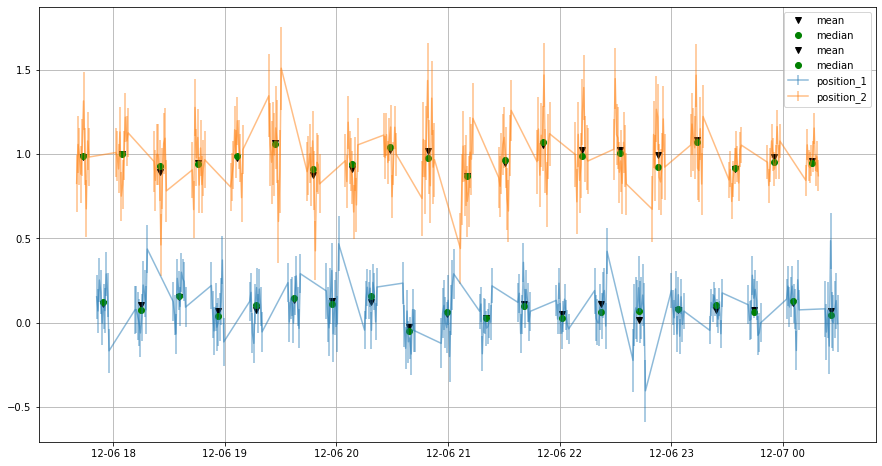

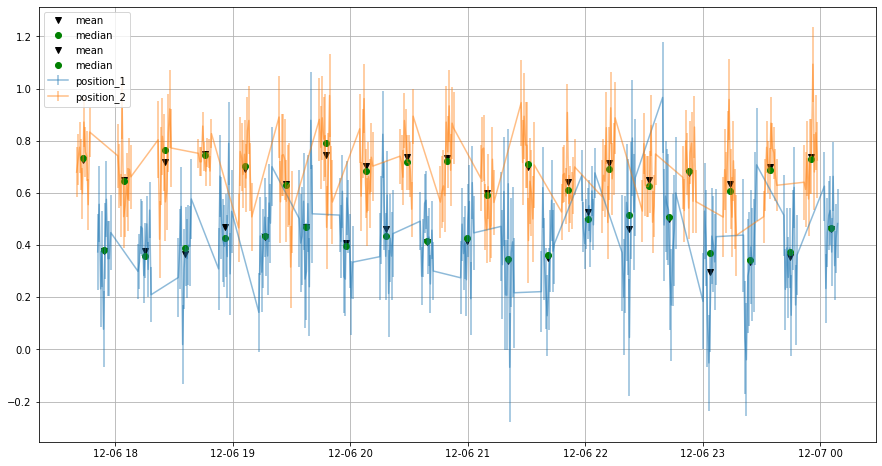

In [11]:
# unwrapping, substracting reference phase, unwrapping for full main cycle, phase filter
pd.options.display.float_format = '{: .4f}'.format

#nu_p_phases2 = nu_p_phases.copy()
nu_p_phases['dphase'] = np.nan
step5_results = pd.DataFrame()

# test phase offset
#settings["phase_offset"] = {2:6.5/360*2*np.pi, 3:-6/360*2*np.pi}

# U N W R A P,   S U B S T R A C T   R E F E R E N C E,   U N W R A P,   P H A S E   F I L T E R
for grpname, grp in nu_p_phases.groupby(["trap", "position", "mcycle"]):
#for grpname, grp in nu_p_phases.groupby(["mcycle", "trap", "position"]):
    print(grpname)
    try:
        grp_new = filtering.three_sigma(grp, 'amp', around='median', show=False)
    except:
        grp_new = grp
    
    grp_new = phase_analysis.unwrap_subsets(grp_new, groupby=["cycle", "acc_time"], residuals_unwrap=True, show=False)
    
    #for sgrpname, sgrp in grp_new.groupby(["acc_time"]):
        #plt.plot(sgrp.time, sgrp.phase, ".")
        #plt.show()
        #display(grp_new)
        
    phase_offset = settings.get("phase_offset", {}).get(trap, 0)
    if meas_config[grpname[1]]["configuration"].get("type", 'nothing') == "PnA":
        print(">>> PnA sign flip!")
        grp_new['phase'] *= -1
        phase_offset *= -1
        
    grp_new = phase_analysis.substract_ref_phase(grp_new, mean=settings.get("mean_ref_phase", True), show=False)
    
    if phase_offset != 0:
        print(">>> WARNING: phase offset applied!", phase_offset)
        grp_new["phase"] -= phase_offset
    
    grp_new = phase_analysis.unwrap_subsets(grp_new, groupby=["cycle", "acc_time"], residuals_unwrap=True, show=False)

    #plt.plot(grp_new.time, grp_new.phase, ".")
    #plt.show()
    #display(grp_new)
       
    grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
                                            pi_span=1.2, fit_N=-3, correlate=True, fit_order=1, show=False)
    grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=settings["post_unwrap"], median_group=["cycle"], 
                                            pi_span=1.2, fit_N=3, correlate=True, fit_order=1, show=False)
    grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
                                            pi_span=1.2, fit_N=-5, correlate=False, fit_order=1, show=False)
    grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
                                            pi_span=1.2, fit_N=-4, correlate=False, fit_order=1, show=False)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1.1, fit_N=-4, correlate=False, fit_order=1, show=False)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1.2, fit_N=99, correlate=True, fit_order=1, show=False)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1.2, fit_N=99, correlate=True, fit_order=1, show=False)
    #grp_new = phase_analysis.leastsquare_unwrap(grp_new, column='phase', pi_span=1.0, timesort='time', median_group=['cycle'], correlate=False, fit_order=1, show=False, iterations=3000)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1.2, fit_N=-4, correlate=True, fit_order=1, show=False)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1.2, fit_N=-4, correlate=True, fit_order=1, show=False)
    ##grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1, fit_N=-4, fit_order=1, show=False)
    #grp_new = phase_analysis.unwrap_dset(grp_new, "phase", reverse=settings["post_unwrap"], drift_unwrap="timex", drift_pi_span=1.2)
    
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1, fit_N=8, fit_order=3, show=False)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1, fit_N=-5, fit_order=1, show=False)
    #grp_new = phase_analysis.grouped_unwrap(grp_new, "phase", reverse=not settings["post_unwrap"], median_group=["cycle"], 
    #                                        pi_span=1, fit_N=12, fit_order=5, show=False)

    # assign error to long phases
    grp_new = statistics.assign_stderr_subsets(grp_new, groupby="cycle", val="phase", dval="dphase", global_undrift=True, x="time", degree=3, show=False)
    
    step5_results = step5_results.append(grp_new, ignore_index=True)

step5_results.sort_values(by="time", inplace=True)

if show_tag:
    for grpname, grp in step5_results.groupby("trap"):
        fig, ax = plt.subplots(figsize=(15, 8))
        try:
            for subname, subgrp in grp.groupby("position"):
                means = []
                medians = []
                meants = []
                t = subgrp.time
                phase = subgrp.phase /2/np.pi
                dphase = subgrp.dphase /2/np.pi
                ax.errorbar(t, phase, yerr=dphase, label=subname, alpha=0.5)
                for ssubname, ssubgrp in subgrp.groupby(["mcycle", "cycle"]):
                    means.append(ssubgrp.phase.mean() /2/np.pi)
                    medians.append(ssubgrp.phase.median() /2/np.pi)
                    meants.append(ssubgrp.time.mean())
                ax.plot(meants, means, "v", c="k", label="mean")
                ax.plot(meants, medians, "o", c="g", label="median")
            plt.legend()
            plt.grid()
            plt.show()
        except:
            pass

mean night phase jitter trap (2, 'position_1') 51.07168589730532
mean night phase jitter trap (2, 'position_2') 32.90845351960182
mean night phase jitter trap (3, 'position_1') 47.532541306967005
mean night phase jitter trap (3, 'position_2') nan
mean phase error in trap (2, 'position_1') 45.51525804851287
mean phase error in trap (2, 'position_2') 60.688349097164064
mean phase error in trap (3, 'position_1') 57.755791079249555
mean phase error in trap (3, 'position_2') 45.80001458104849
trp, pos, mean std (2pi, 360, 1) 2 position_1 0.7939052998300198 45.48742301332833 0.1263539528148009
trp, pos, mean std (2pi, 360, 1) 2 position_2 1.0585616881547713 60.651117085511984 0.16847532523753328


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\numpy\core\fromnumeric.py:3441: RuntimeWarning:

Mean of empty slice.



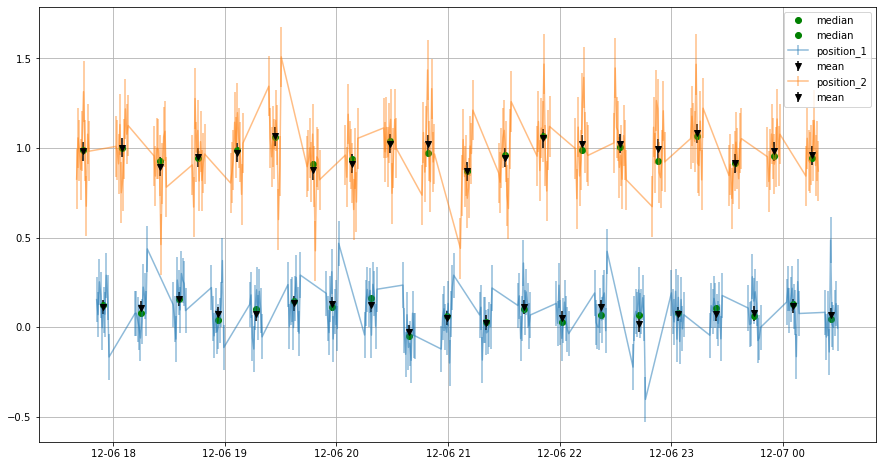

trp, pos, mean std (2pi, 360, 1) 3 position_1 1.0085092023253786 57.783320893349426 0.1605092247037484
trp, pos, mean std (2pi, 360, 1) 3 position_2 0.8001729004308347 45.846530075428674 0.12735147243174633


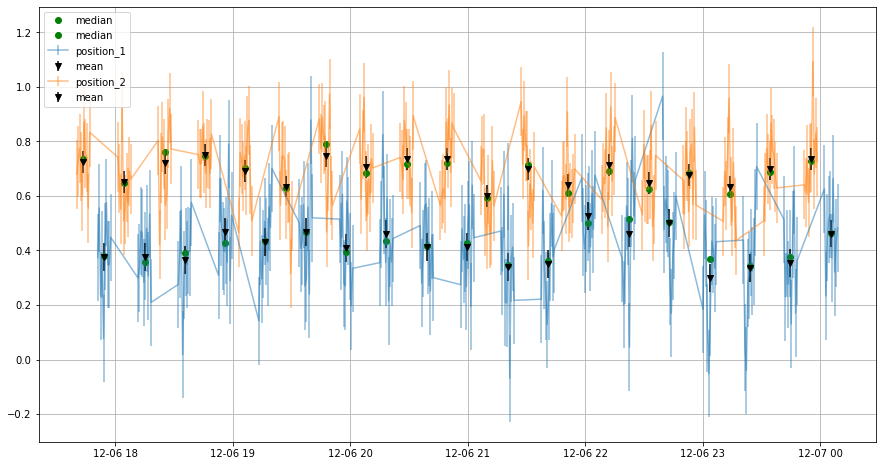

Empty DataFrame
Columns: [mcycle, cycle, position, trap, acc_time, time, phase, average_idx, amp, peak, masked, dphase, epoch]
Index: []

In [12]:
"""
for grpname, grp in step5_results.groupby(["trap", "mcycle"]):
    grp.sort_values(by="time", inplace=True)

    #plt.plot(grp["phase"].to_numpy())
    #plt.show()
    
    if not settings["post_unwrap"]:
        start_position_phase = np.median(grp[(grp["position"]==start_position) & (grp["cycle"]==grp.cycle.min())]["phase"])
        other_position_phase = np.median(grp[(grp["position"]==other_position) & (grp["cycle"]==grp.cycle.min())]["phase"])
    else:
        start_position_phase = np.median(grp[(grp["position"]==start_position) & (grp["cycle"]==grp.cycle.max()-1)]["phase"])
        other_position_phase = np.median(grp[(grp["position"]==other_position) & (grp["cycle"]==grp.cycle.max()-1)]["phase"])
    
    print(grpname, start_position_phase, other_position_phase)
    
    grp.loc[grp['position'] == start_position, 'phase'] -= start_position_phase
    grp.loc[grp['position'] == other_position, 'phase'] -= other_position_phase
    
    #plt.plot(grp["phase"].to_numpy())
    #plt.show()
    
    grp = phase_analysis.grouped_unwrap(grp, column='phase', reverse=settings["post_unwrap"], pi_span=1.0,
                                         median_group='cycle', fit_N=-2, fit_order=1, show=True)
    grp = phase_analysis.grouped_unwrap(grp, column='phase', reverse=settings["post_unwrap"], pi_span=1.0,
                                         median_group='cycle', fit_N=-2, fit_order=1, show=False)
    grp = phase_analysis.grouped_unwrap(grp, column='phase', reverse=settings["post_unwrap"], pi_span=1.0,
                                         median_group='cycle', fit_N=-4, fit_order=1, show=False)
    grp = phase_analysis.grouped_unwrap(grp, column='phase', reverse=not settings["post_unwrap"], pi_span=1.0,
                                         median_group='cycle', fit_N=8, fit_order=1, show=False)
    
    #plt.plot(grp["phase"].to_numpy())
    #plt.show()
    
    grp.loc[grp['position'] == start_position, 'phase'] += start_position_phase
    grp.loc[grp['position'] == other_position, 'phase'] += other_position_phase
    
    #plt.plot(grp["phase"].to_numpy())
    #plt.show()
    
    step5_results.iloc[grp.index] = grp
"""

# check night data phase stability between 0 and 4 in the morning (silent mag-field time)
for grpname, grp in step5_results.groupby(["trap", "position"]):
    subset = grp.copy(deep=True)
    subset = subset.set_index(subset['time'], drop=True)
    subsub = subset.between_time('00:00:00', '04:00:30')
    print("mean night phase jitter trap", grpname, np.mean(subsub.dphase.unique())*180/np.pi)

#for grpname, grp in step5_results.groupby(["trap", "position"]):
#    # unwrap over complete data of this trap/position (this is safer here then in the loop before, since the next main
#    # cycles use the already stable fit from before.)
#    step5_results["phase"].loc[grp.index] = phase_analysis.drift_unwrap_method(grp["phase"].to_numpy(), pi_span = 1.3, min_fit = 1, times=grp["time"].astype('int64')//1e9)

# WARNING THIS DOES ONLY WORK IF YOU DONT HAVE RANDOM PHASES AT THE END OF THE MEASUREMENT!
# assign mean phase std (for full trap data) as phase error
for grpname, grp in step5_results.groupby(["trap", "position"]):
    mean_std = grp["dphase"].mean()
    print("mean phase error in trap", grpname, mean_std*180/np.pi)
    idx = grp.index
    step5_results["dphase"].loc[idx] = mean_std

step5_results['masked'] = False

# 3 sigma filter on phase data
if settings["phase_filter"]:
    for grpname, grp in step5_results.groupby(["mcycle", "trap", "position", "cycle"]):
        #print(grpname, grp["phase"].std()*180/np.pi)
        grp = filtering.three_sigma(grp, 'phase', err=None, undrift_xcolumn='time', manual_std=grp["dphase"].mean(), show=False)
        idx = grp.index
        step5_results["masked"].loc[idx] = grp["masked"]

step5_results.sort_values(by="time", inplace=True)

if show_tag:
    for grpname, grp in step5_results.groupby("trap"):
        fig, ax = plt.subplots(figsize=(15, 8))
        for subname, subgrp in grp.groupby("position"):
            means = []
            stds = []
            medians = []
            meants = []
            Ns = []
            t = subgrp.time
            phase = subgrp.phase /2/np.pi
            dphase = subgrp.dphase /2/np.pi
            ax.errorbar(t, phase, yerr=dphase, label=subname, alpha=0.5)
            for ssubname, ssubgrp in subgrp.groupby(["mcycle", "cycle"]):
                means.append(ssubgrp.phase.mean() /2/np.pi)
                medians.append(ssubgrp.phase.median() /2/np.pi)
                meants.append(ssubgrp.time.mean())
                stds.append(ssubgrp.phase.std())
                Ns.append(len(ssubgrp))
            meanstd = np.mean(stds)
            err = [meanstd/2/np.pi/np.sqrt(np.mean(Ns))]*len(meants)
            ax.errorbar(meants, means, yerr=err, fmt="v", c="k", label="mean")
            ax.plot(meants, medians, "o", c="g", label="median")
            print("trp, pos, mean std (2pi, 360, 1)", grpname, subname, meanstd, meanstd/2/np.pi*360, meanstd/2/np.pi)
        plt.legend()
        plt.grid()
        plt.show()

maskedphases = step5_results[ step5_results["masked"] == True ]
display(maskedphases)


mcycle  cycle    position  trap  acc_time                       time  \
390       1      1  position_2     2   19.9500 2021-12-06 17:40:11.669105   
770       1      1  position_2     3   19.9500 2021-12-06 17:40:12.021128   
391       1      1  position_2     2   19.9500 2021-12-06 17:40:56.612166   
771       1      1  position_2     3   19.9500 2021-12-06 17:40:56.695375   
392       1      1  position_2     2   19.9500 2021-12-06 17:41:41.145155   
..      ...    ...         ...   ...       ...                        ...   
5         1     20  position_1     2   19.9500 2021-12-07 00:26:35.379345   
6         1     20  position_1     2   19.9500 2021-12-07 00:27:20.108562   
7         1     20  position_1     2   19.9500 2021-12-07 00:28:04.757657   
8         1     20  position_1     2   19.9500 2021-12-07 00:28:49.455219   
9         1     20  position_1     2   19.9500 2021-12-07 00:29:34.109579   

      phase  average_idx       amp         peak  masked  dphase  \
390  5.1902            0  129.8312  736099.6079   False  1.0592   
770  4.2684            0  137.7119  501496.5036   False  0.7994   
391  6.6365            0  131.3408  736089.7067   False  1.0592   
771  4.5765            0  135.0080  501499.4031   False  0.7994   
392  6.1992            0  132.3181  736122.3107   False  1.0592   
..      ...          ...       ...          ...     ...     ...   
5    0.0971            0  134.7239  736093.5071   False  0.7944   
6   -0.0026            0  123.8178  736113.2096   False  0.7944   
7    0.4913            0  134.4475  736084.4060   False  0.7944   
8    0.8227            0  134.6190  736090.7068   False  0.7944   
9   -0.0308            0  135.6573  736085.5061   False  0.7944   

               epoch  
390  1638812411.0000  
770  1638812412.0000  
391  1638812456.0000  
771  1638812456.0000  
392  1638812501.0000  
..               ...  
5    1638836795.0000  
6    1638836840.0000  
7    1638836884.0000  
8    1638836929.0000  
9    1638836974.0000  

[780 rows x 13 columns]

21
22
31
32


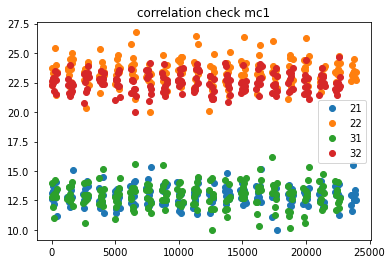

mcycle 1
correlation position 1 SpearmanrResult(correlation=-0.14419731702729774, pvalue=0.04715644608326889)
correlation position 2 SpearmanrResult(correlation=0.12168903935230749, pvalue=0.09442178003801925)
correlation trap 2 SpearmanrResult(correlation=0.0023260594767897055, pvalue=0.9745908903887093)
correlation trap 3 SpearmanrResult(correlation=0.03231376871498117, pvalue=0.6580616605898884)


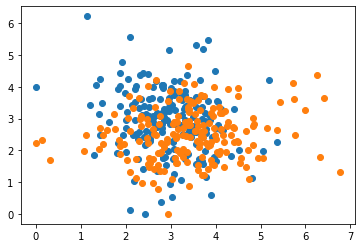

In [13]:

# quick correlation check
phases = {}
maxl = 1e6

display(step5_results)
for mc, mgrp in step5_results.groupby(["mcycle"]):
    for grpname, grp in mgrp.groupby(["trap", "position"]):
        ph = grp.phase.to_numpy()
        ph = ph-ph.min()
        t = (grp.time.astype('int64')//1e9).to_numpy()
        x = t - t.min()
        #print(x, ph)
        coef = np.polyfit(x,ph,7)
        ph -= np.poly1d(coef)(x)
        ph = ph-ph.min()
        label = str(grpname[0])+str(grpname[1].split("_")[1])
        print(label)
        plt.plot(x, ph + 10*int(label[1]), "o", label=label)
        phases[label] = ph
        if len(ph) < maxl:
            maxl = len(ph)
    plt.title("correlation check mc" +str(mc) )
    plt.legend()
    plt.show()
    print("mcycle", mc)
    try:
        print("correlation position 1", scipy.stats.spearmanr(phases["21"][:maxl], phases["31"][:maxl]))
    except Exception as e:
        print(e)
    try:
        print("correlation position 2", scipy.stats.spearmanr(phases["22"][:maxl], phases["32"][:maxl]))
    except Exception as e:
        print(e)
    try:
        print("correlation trap 2", scipy.stats.spearmanr(phases["21"][:maxl], phases["22"][:maxl]))
    except Exception as e:
        print(e)
    try:
        print("correlation trap 3", scipy.stats.spearmanr(phases["31"][:maxl], phases["32"][:maxl]))
    except Exception as e:
        print(e)
    try:
        plt.plot(phases["21"][:maxl], phases["31"][:maxl], "o") 
        plt.plot(phases["22"][:maxl], phases["32"][:maxl], "o")
        plt.xlim(0, 2*np.pi())
        plt.ylim(0, 2*np.pi())
        plt.show()
    except:
        pass

In [14]:
qgrid_widget = qgrid.show_grid(nu_p_N)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [15]:
nu_p_N = qgrid_widget.get_changed_df()

 >>> NORMAL: using Pre-Unwrap! <<< 
1073170225.0
pre unwrap
init delta 0.08168998356528133


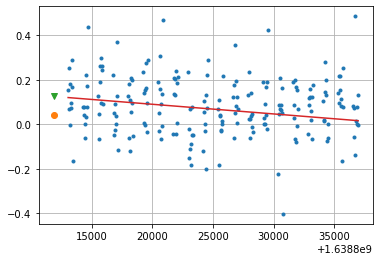

(1, 2, 'position_1') 0.7943911128413985 0.006337407135688229
 >>> NORMAL: using Pre-Unwrap! <<< 
1072764492.0
pre unwrap
init delta 0.8097667298215746
new delta -1.195270888121807


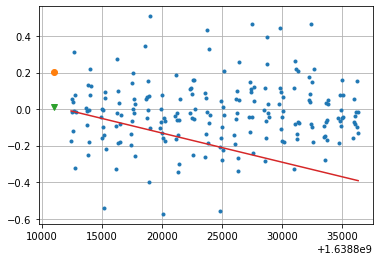

(1, 2, 'position_2') 1.059211509345241 0.008450062530933458
 >>> NORMAL: using Pre-Unwrap! <<< 
1072819734.0
pre unwrap
init delta 0.7377872971546438
new delta -1.647531001873789


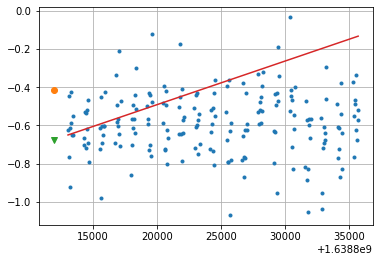

(1, 3, 'position_1') 1.0080287164268742 0.00804174200490804
 >>> NORMAL: using Pre-Unwrap! <<< 
1073225447.0
pre unwrap
init delta 1.0644308256818904
new delta 0.40483081725390235


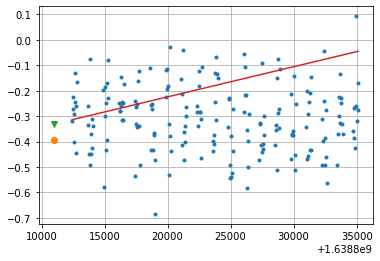

(1, 3, 'position_2') 0.7993610519007073 0.006377055775695975
> masked data:


Empty DataFrame
Columns: [mcycle, cycle, position, trap, acc_time, time, phase, average_idx, amp, peak, masked, dphase, epoch, nu_p, dnu_p]
Index: []

In [16]:
# calc frequency from phase using N_determination from unwrap data
step5_results['nu_p'] = np.nan
step5_results['dnu_p'] = np.nan

N_phases = settings["phase_Nmatch_phases"]


#settings["post_unwrap"] = not settings["post_unwrap"]
step5_results.sort_values(by="time", inplace=True)

wait = True
phaseminmax = [0, 0]
for grpname, grp in step5_results.groupby(["mcycle", "trap", "position"]):
    mc, trap, pos = grpname

    # get the results from the unwrap measurement (pre and post)
    N_data = nu_p_N[(nu_p_N['mcycle'] == mc) & (nu_p_N['trap'] == trap) & (nu_p_N['position'] == pos)]
    reverse = False

    N_data_next = nu_p_N.loc[(nu_p_N['mcycle'] == mc+1) & (nu_p_N['trap'] == trap) & (nu_p_N['position'] == pos)]
    if settings["post_unwrap"] and (len(N_data_next) != 0):
        N_data = N_data_next
        reverse = True
        print(" >>> WARNING: using Post-Unwrap! <<< ")
    else:
        print(" >>> NORMAL: using Pre-Unwrap! <<< ")
        
    #display(N_data)
    last_phase = float(N_data["end_phase"])
    last_time = int(N_data["time"].astype('int64')//1e9)
    N = float(N_data["N"])
    N += float(N_data["Nplus"])
    print(N)
    
    # now we have to unwrap all the phases in this main cycle using the last phase of the
    # N determination as a starting phase. This way we assure that the N from the N_determination
    # fits the phases in the measurement.
    #"""
    # fit phases:
    phases = grp["phase"].to_numpy()
    times = grp["epoch"].to_numpy()
    if settings["post_unwrap"] and (len(N_data_next) != 0):
        print("post unwrap")
        fit_phases = phases[-N_phases:]
        fit_times = times[-N_phases:]
    else:
        print("pre unwrap")
        fit_phases = grp["phase"].to_numpy()[:N_phases]
        fit_times = grp["epoch"].to_numpy()[:N_phases]
    coef = np.polyfit(fit_times, fit_phases, 1)
    poly1d_fn = np.poly1d(coef)
    expected_value = poly1d_fn(last_time)
    delta = expected_value - last_phase
    counter = 0
    print("init delta", delta/np.pi/2)
    while abs(delta) > np.pi:
        sign = delta/abs(delta)
        phases -= 2*np.pi * sign
        delta -= 2*np.pi * sign
        print("new delta", delta)
        counter += 1 * sign
        
    grp["phase"] = phases
    if True:
        plt.plot(times, phases/np.pi/2, ".", label="phases")
        plt.plot([last_time], [last_phase/np.pi/2], "o", label="N phase")
        plt.plot([last_time], [(poly1d_fn(last_time)-counter*2*np.pi)/np.pi/2], "v", label="expected N phase")
        plt.plot(times, (poly1d_fn(times)-counter*2*np.pi)/np.pi/2)
        plt.grid()
        plt.show()
    # get expected aat current phase time
    #"""
    
    #grp = phase_analysis.grouped_unwrap(grp, column="phase", start_phase_time = (last_phase, N_data["time"]), 
    #                                    reverse = reverse, fit_N=-10, fit_order=1, timesort="time", pi_span=1.0, show=False)

    """
    grp = phase_analysis.unwrap_dset(grp, column=["phase"], start_phase = last_phase, reverse = reverse,
                                     #drift_unwrap=False, drift_pi_span=1.2, show=False)
                                     #drift_unwrap="timex", drift_pi_span=1.0, timesort = True, start_phase_time = N_data["time"], show=False)
                                     drift_unwrap="timex", drift_pi_span=1.1, timesort = True, start_phase_time = N_data["time"], slope=-1.0e-3, show=False)
                                     #drift_unwrap="justfixit", drift_pi_span=1.1, timesort = True, start_phase_time = None, show=False)
                                     #drift_unwrap=False, drift_pi_span=1.3, timesort = True, start_phase_time = None, show=False)
    """
    
    # calculating frequency and error... 
    grp["nu_p"] = abs(phase_analysis.calc_nu(N, grp["acc_time"], grp["phase"]))
    grp["dnu_p"] = phase_analysis.calc_dnu(grp["acc_time"], grp["dphase"])
    print(grpname, grp["dphase"].mean(), grp["dnu_p"].mean())
    
    step5_results.loc[grp.index] = grp


    """
    if True:        
        #plt.errorbar(grp.time, grp.phase/2/np.pi, grp.dphase/2/np.pi, marker='.', label=grpname)
        plt.errorbar(grp.epoch, grp.phase/2/np.pi, grp.dphase/2/np.pi, marker='.', label=grpname)
        #plt.plot(N_data["time"], last_phase/2/np.pi, marker='o', label=grpname)
        plt.plot(last_time, last_phase/2/np.pi, marker='o', label=grpname)
        #plt.show()
        
        #plt.plot(N_data["time"], (N+last_phase/2/np.pi)/float(N_data["max_acc_time"]), marker='o')
        if wait:
            wait = False
            #pass
        else:
            ax = plt.gca()
            ax.yaxis.set_major_formatter(tck.FormatStrFormatter('%g $\pi$'))
            ax.yaxis.set_major_locator(tck.MultipleLocator(base=1.0))

            #plt.style.use("ggplot")
            plt.grid()
            plt.legend()
            plt.show()
            wait = True
    """
"""
for grpname, grp in step5_results.groupby(["trap", "position"]):
    trap, pos = grpname
    
    N_data = nu_p_N[(nu_p_N['mcycle'] == 1) & (nu_p_N['trap'] == trap) & (nu_p_N['position'] == pos)]
    acc_max = float(N_data["max_acc_time"])
    delta_N_freq_shift = 1/acc_max/2 # this is basically 2 pi /2, so the pi step
    pi_factor = delta_N_freq_shift/(np.pi*0.5)
    print(delta_N_freq_shift, pi_factor)
    
    grp = phase_analysis.grouped_unwrap(grp, column="nu_p", fit_N=24, fit_order=3, reverse=False, timesort="time", pi_span=pi_factor, show=True)

    step5_results.loc[grp.index] = grp
""" 
#step5_results.sort_values(by='time', inplace=True)
#display(step5_results)
step5_results.to_csv(results_dir + "step5_nu_p_values.csv")
step5_results.to_csv(results_dir + "step5_nu_p_values.txt", sep="\t")
print("> masked data:")
maskedphases = step5_results[ step5_results["masked"] == True ]
display(maskedphases)

In [17]:
fig = px.scatter(step5_results, x="time", y="nu_p", error_y="dnu_p", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position'])
#fig = px.scatter(step5_results, x="time", y="phase", error_y="dphase", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

fig = px.scatter(step5_results, x="time", y="nu_p", error_y="dnu_p", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
#fig = px.scatter(step5_results, x="time", y="phase", error_y="dphase", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

#### Decision: Averaged or single phases?

At this point in the analysis you have to choose if you want to work with averaged data (default) or with single phases. The axial spectra typically have to be averaged to reach enough signal-to-noise-ratio to be able to fit a dip. That results in less nu_z data points than nu_p data points from phases (which we get from every subcycle measurement). If you want to work with averaged data, the phases will be averaged to match the nu_z data. If you want to work with single phases, the axial data will be assigned to all phases with an increased errorbar by np.sqrt(N). This way, averaging afterwords would result in the same axial frequency error again.

For the interpolation method, averaging is done seperatly even if you choose single phase. It just doesnt work with single phases.

In [18]:
# merge with axial data: First just expanding the time-matching axial fits to the phase information!
step5_all_freqs = pd.DataFrame()
axial_data.sort_values(by=["mcycle", "trap", "cycle", "position"], inplace=True)
step5_results.sort_values(by=["mcycle", "trap", "cycle", "position", "time"], inplace=True)
step5_results_p = step5_results.rename(columns = {'time': 'time_p', 'phase': 'phase_p', 'dphase': 'dphase_p', 'average_idx': 'average_idx_p'})

groupby = ["mcycle", "trap", "cycle", "position"]

lastgrpname = None
average_idx = []
for grpname, grpphase in step5_results_p.groupby(groupby):
    if lastgrpname is None:
        lastgrpname = grpname
    mc, trap, cyc, pos = grpname
    #print('mcycle', mc, 'trap', trap, 'cycle', cyc, 'position', pos)
    
    grpaxial = axial_data
    for key, val in zip(groupby, grpname):
        grpaxial = grpaxial[ grpaxial[key] == val ]
    
    grpaxial_time = grpaxial.set_index('time') # set column 'time' to index
    current_axial_index = None

    subcycle = 0
    for idx, row in grpphase.iterrows():
        subcycle += 1
        # get the time-wise nearest date for axial frequencies
        try:
            axial_idx = grpaxial_time.index.get_loc(row.time_p, method='nearest')
            axial_row = grpaxial.iloc[axial_idx]
        except: continue
            
        #print('phase cycle', row['cycle'], 'axial cycle', axial_row['cycle'], 'phase time', row['time_p'], 'axial time', axial_row['time'])
        axial_row = axial_row.iloc[axial_row.index.isin(['time', 'nu_z', 'dnu_z', 'nu_res', 'dnu_res', 'Q', 'dQ', 'A', 'dA', 'off', 'doff', 'dip_width', 'ddip_width', 'fit_err', 'fit_success', 'average_idx'])]

        new_row = row.append(axial_row)
        new_row["subcycle"] = subcycle
        step5_all_freqs = step5_all_freqs.append(new_row, ignore_index=True)        
        
        # IMPORTANT! We are expanding the axial data, so we have to assign an expanded error the way that the averaged value gets the same error as before!
        if current_axial_index is None:
            current_axial_index = axial_idx
        
        if current_axial_index != axial_idx or lastgrpname != grpname:
            new_err = last_dnu_z*np.sqrt(len(average_idx))
            step5_all_freqs.loc[average_idx, "dnu_z"] = float(new_err)
            average_idx = []
            lastgrpname = grpname

        average_idx.append( step5_all_freqs.index[-1] )
        last_dnu_z = axial_row["dnu_z"]

step5_all_freqs = data_conversion.fix_column_dtypes(step5_all_freqs)

if show_tag:
    fig = px.scatter(step5_all_freqs, x="time_p", y="nu_p", error_y="dnu_p", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()

if show_tag:
    fig = px.scatter(step5_all_freqs, x="time_p", y="nu_p", error_y="dnu_p", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()
    
step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.csv")
step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.txt", sep="\t")

In [19]:
# average:
if settings.get("average", False):
    new_df = pd.DataFrame()
    for grpname, grpphase in step5_all_freqs.groupby(["mcycle", "trap", "cycle", "position"]):
        avg = statistics.average_subsets(grpphase, groupby=["average_idx"], errortype="weighted",
                                              columns=["phase_p", "nu_p", "nu_z", "time_p"], 
                                              dcolumns=["dphase_p", "dnu_p", "dnu_z", None],
                                              masked=True)
        new_df = new_df.append(avg, ignore_index=True)
        cyc = grpname[2]
        if cyc == 1:
            pos = grpname[3]
            trap = grpname[1]
            nu_p = meas_config[pos]["configuration"]["traps"][trap]["nu_p"]
            nu_p_here = avg.iloc[0].nu_p
            print(grpphase.time, grpphase.time_p)
            print(trap, pos, nu_p, nu_p_here, nu_p_here - nu_p)
    
    step5_all_freqs = new_df
    for grpname, grp in step5_all_freqs.groupby(["trap", "position"]):
        print('trap, position', grpname, np.std(grp.phase_p)*180/np.pi)
            
    if show_tag:
        fig = px.scatter(step5_all_freqs, x="time_p", y="nu_p", error_y="dnu_p", facet_col="trap", facet_row="position", hover_data=['mcycle', 'cycle', 'position'])
        fig.update_yaxes(matches=None, showticklabels=True)
        fig.show()

    step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.csv")
    step5_all_freqs.to_csv(results_dir + "step5_all_freqs_values.txt", sep="\t")


0   2021-12-06 17:54:18.307308
1   2021-12-06 17:54:18.307308
2   2021-12-06 17:54:18.307308
3   2021-12-06 17:54:18.307308
4   2021-12-06 17:54:18.307308
5   2021-12-06 17:54:18.307308
6   2021-12-06 17:54:18.307308
7   2021-12-06 17:54:18.307308
8   2021-12-06 17:54:18.307308
9   2021-12-06 17:54:18.307308
Name: time, dtype: datetime64[ns] 0   2021-12-06 17:50:58.300307
1   2021-12-06 17:51:42.867865
2   2021-12-06 17:52:27.259030
3   2021-12-06 17:53:11.621907
4   2021-12-06 17:53:56.100532
5   2021-12-06 17:54:40.483308
6   2021-12-06 17:55:24.855456
7   2021-12-06 17:56:09.339037
8   2021-12-06 17:56:53.790655
9   2021-12-06 17:57:38.209356
Name: time_p, dtype: datetime64[ns]
2 position_1 53792993.96 53792993.73990374 -0.22009626030921936
10   2021-12-06 17:43:32.077904
11   2021-12-06 17:43:32.077904
12   2021-12-06 17:43:32.077904
13   2021-12-06 17:43:32.077904
14   2021-12-06 17:43:32.077904
15   2021-12-06 17:43:32.077904
16   2021-12-06 17:43:32.077904
17   2021-12-06 17:43:

Index(['mcycle', 'trap', 'position', 'N', 'end_phase', 'nu_p', 'ion', 'time',
       'max_acc_time', 'Nquality', 'mtype', 'Nplus'],
      dtype='object')
Index(['A', 'Q', 'acc_time', 'amp', 'average_idx', 'average_idx_p', 'cycle',
       'dA', 'dQ', 'ddip_width', 'dip_width', 'dnu_p', 'dnu_res', 'dnu_z',
       'doff', 'dphase_p', 'epoch', 'fit_err', 'fit_success', 'masked',
       'mcycle', 'nu_p', 'nu_res', 'nu_z', 'off', 'peak', 'phase_p',
       'position', 'subcycle', 'time', 'time_p', 'trap'],
      dtype='object')
1638810972.2
(1.0, 2.0, 'position_1') 20Ne10+ 0 (0.9411764705882353, 0.0, 0.5568627450980392)
[ 0.697933793862  0.676104841033  0.975304469515  0.446318238974
  0.463266418874  0.834121770064  0.813425323416  0.775253347729
 -0.171957712669  0.331689662535  0.161320249388  0.700724713901
  0.329677389376  0.698693452775  0.095302529795  0.466013154436
  0.478100628058  0.479778710008  0.741702461243  0.420381823579]
[0.697933793862 0.676104841033 0.975304469515 0.44631

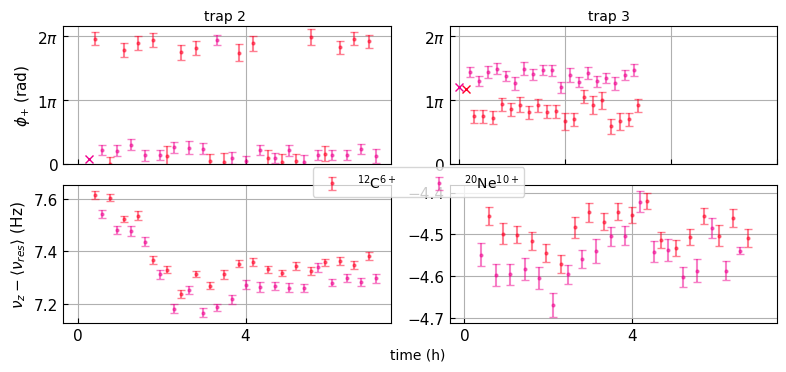

In [71]:
rcParams_backup = deepcopy(mpl.rcParams)
mpl.rcParams.update(mpl.rcParamsDefault)

from matplotlib.ticker import FuncFormatter, MultipleLocator
import re

fig_size = [8, 3.5]
textsize = 11

#plt.rc('text', usetex=True)
plt.rc('font', family='sans-serif', size=textsize)

# Create two subplots and unpack the output array immediately
#f, axs = plt.subplots(2, 2, figsize=(fig_width,8), sharex='col')
f, axs = plt.subplots(2, 2, figsize=fig_size, sharex=True)

colorA=(240, 0, 142)#"teal"#
colorB=(255, 0, 38)#"tomato"#

min_time = nu_p_N.time.min()/10e8
ions = nu_p_N.ion.unique()
print(nu_p_N.keys())
print(step5_all_freqs.keys())
print(min_time)
#display(nu_p_N.time.tail(4))
#display(step5_all_freqs.epoch.tail(4))

for grpname, grp in step5_all_freqs.groupby(["mcycle", "trap", "position"]):

    mc, trap, pos = grpname
    if mc > 1.1:
        continue
        
    grp_Ndet = nu_p_N[(nu_p_N["mcycle"]==mc) & (nu_p_N["position"]==pos) & (nu_p_N["trap"]==trap)]
    ion = grp_Ndet["ion"].unique()[0]
    if trap == 2:
        col = 0
    else:
        col = 1
    if ion == ions[0]:
        color = colorA
    else:
        color = colorB
    try:
        color = (color[0]/255, color[1]/255, color[2]/255)
    except:
        pass
    print(grpname, ion, col, color)

    print(grp["phase_p"].to_numpy())
    phases = grp["phase_p"].to_numpy()%(2*np.pi)
    print(phases)

    dphases = grp["dphase_p"].to_numpy()
    time = grp["epoch"].to_numpy() - min_time
    time /= 3600
    Ndet_phase = float(grp_Ndet.end_phase)
    if (Ndet_phase-phases[0])< -np.pi: Ndet_phase += 2*np.pi
    if (Ndet_phase-phases[0])> np.pi: Ndet_phase -= 2*np.pi
    Ndet_time = float(grp_Ndet.time)/10e8 - min_time
    Ndet_time /= 3600

    pax = axs[0, col]
    pax.set_ylim(0, 2*np.pi+0.5)

    pax.yaxis.set_major_formatter(FuncFormatter(
       lambda val,pos: '{:.0g}$\pi$'.format(val/np.pi) if val !=0 else '0'
    ))
    pax.yaxis.set_major_locator(MultipleLocator(base=np.pi))

    ionstr = re.findall(r'\d+|\D+', ion)
    ionstr = r'$^{'+ionstr[0]+'}$'+ionstr[1]+'$^{'+ionstr[2]+'+}$'
    pax.errorbar(time, phases, dphases, fmt='o', color=color, ms=2, alpha=0.5, capsize=3, label=ionstr)
    pax.plot(Ndet_time, Ndet_phase, 'x', color=color)
    
    nures = step5_all_freqs[(step5_all_freqs["mcycle"]==mc) & (step5_all_freqs["trap"]==trap)]['nu_res'].to_numpy()

    meanres = statistics.complete_mean_and_error(nures)
    print(meanres)
    nu_z = grp["nu_z"].to_numpy()
    nu_z -= int(meanres[0])
    dnu_z = grp["dnu_z"].to_numpy()
    
    zax = axs[1, col]
    zax.errorbar(time, nu_z, dnu_z, fmt='o', color=color, ms=2, alpha=0.5, capsize=3, label=ionstr)

    pax.tick_params(direction='in')
    zax.tick_params(direction='in')
    zax.ticklabel_format(useOffset=False)
    pax.xaxis.set_ticks(np.arange(0, 16, 4))
    zax.grid("both")
    pax.grid("both")
    
    if (col == 0) and (ion == ions[0]):
        pax.set_ylabel(r'$\phi_{+}$ (rad)')
        zax.set_ylabel(r'$\nu_z - \langle {\nu_{res}} \rangle$ (Hz)')
    if (col == 1) and (ion == ions[0]):
        zax.legend(bbox_to_anchor=(0.25, 1.18), ncol=2, fontsize=textsize-1)

plt.tight_layout()
plt.subplots_adjust(wspace=0.18, hspace=0.15)
#fig = plt.gcf()
trap2 = f.text(0.29, 0.97, 'trap 2', ha='center', size=textsize-1)
trap3 = f.text(0.77, 0.97, 'trap 3', ha='center', size=textsize-1)
#trap2.set_bbox(dict(facecolor="w", alpha=0.5, edgecolor=color, boxstyle='round'))
#trap3.set_bbox(dict(facecolor="w", alpha=0.5, edgecolor=color, boxstyle='round'))
#f.text(0.001, 0.5, r'amplitude (dB)', va='center', rotation='vertical', size=labelsize)
f.text(0.53, 0.002, 'time (h)', ha='center', size=textsize-1)

plt.savefig('data_example.pdf', format='pdf', pad_inches=2)
plt.show()

mpl.rcParams = rcParams_backup

In [21]:
fig = px.scatter(step5_all_freqs, x="time", y="nu_z", error_y="dnu_z", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

In [22]:
# means and compare
names = []
means = []
for grpname, grp in step5_all_freqs.groupby(["trap", "position"]):
    names.append(grpname)
    means.append(grp.nu_p.mean())

try:
    print("diffs")
    print(names[0], names[1], means[0]-means[1])
    print(names[2], names[3], means[2]-means[3])
    print(names[0], names[2], means[0]-means[2])
    print(names[1], names[3], means[1]-means[3])
    print("ratios")
    rguess = means[0]/means[1]
    print(names[0], names[1], means[0]/means[1])
    print(names[3], names[2], means[3]/means[2])
    print(names[0], names[2], means[0]/means[2])
    print(names[1], names[3], means[1]/means[3]*rguess)
except:
    pass

diffs
(2.0, 'position_1') (2.0, 'position_2') 20337.499033004045
(3.0, 'position_1') (3.0, 'position_2') -20336.505296632648
(2.0, 'position_1') (3.0, 'position_1') 17568.504857234657
(2.0, 'position_2') (3.0, 'position_2') -23105.499472402036
ratios
(2.0, 'position_1') (2.0, 'position_2') 1.0003782126540752
(3.0, 'position_2') (3.0, 'position_1') 1.0003781746998426
(2.0, 'position_1') (3.0, 'position_1') 1.000326701365557
(2.0, 'position_2') (3.0, 'position_2') 0.9999485461242684


### Step 6: Calc free cyclotron

Use the 3 eigenfrequencies to calculate the free cyclotron frequency

In [23]:
#step6_results = pd.DataFrame()
pd.options.mode.chained_assignment = None  # default='warn'
step6_results = step5_all_freqs.copy()

step6_results = step6_results.sort_values("time_p")
step6_results.reset_index(drop=True, inplace=True)

"""
posis = step6_results.position.unique()
print(posis)

newdf = pd.DataFrame()
for grpname, grp in step6_results.groupby(["mcycle", "trap"]):
    
    #display(grp[["position", "trap", "epoch", "time_p", "time"]].head(6))
    #display(grp[["position", "trap", "epoch", "time_p", "time"]].tail(6))
    grp = ratio_analysis.interpolate(grp, y=['nu_z'], yerr=['dnu_z'], groupbys=['mcycle', 'trap'], x="epoch",
            identifier="position", id_reference=posis[0], id_interpolate=posis[1], get_center_columns=['position', 'time', 'time_p'],
            non_linear_uncertainty_per_second=0, newycol='nuz_inter', newxcol='time_inter', keepfirstlast=True, keeprow=True)

    newdf = newdf.append(grp)
    
    display(newdf[["mcycle", "cycle", "position", "trap", "epoch", "time_inter", "time_p", "time"]].head(6))
    display(newdf[["mcycle", "cycle", "position", "trap", "epoch", "time_inter", "time_p", "time"]].tail(6))
step6_results = newdf

if show_tag:
    fig = visualization.compare_dset_columns(step6_results, x=["epoch", "time_inter"], y=["nu_z", "nuz_inter"], yerr=["dnu_z", "dnuz_inter"], facet_col="trap", facet_row="position")
"""

'\nposis = step6_results.position.unique()\nprint(posis)\n\nnewdf = pd.DataFrame()\nfor grpname, grp in step6_results.groupby(["mcycle", "trap"]):\n    \n    #display(grp[["position", "trap", "epoch", "time_p", "time"]].head(6))\n    #display(grp[["position", "trap", "epoch", "time_p", "time"]].tail(6))\n    grp = ratio_analysis.interpolate(grp, y=[\'nu_z\'], yerr=[\'dnu_z\'], groupbys=[\'mcycle\', \'trap\'], x="epoch",\n            identifier="position", id_reference=posis[0], id_interpolate=posis[1], get_center_columns=[\'position\', \'time\', \'time_p\'],\n            non_linear_uncertainty_per_second=0, newycol=\'nuz_inter\', newxcol=\'time_inter\', keepfirstlast=True, keeprow=True)\n\n    newdf = newdf.append(grp)\n    \n    display(newdf[["mcycle", "cycle", "position", "trap", "epoch", "time_inter", "time_p", "time"]].head(6))\n    display(newdf[["mcycle", "cycle", "position", "trap", "epoch", "time_inter", "time_p", "time"]].tail(6))\nstep6_results = newdf\n\nif show_tag:\n    f

In [24]:
step6_results['nu_c'] = np.nan
step6_results['dnu_c'] = np.nan
step6_results['nu_m'] = np.nan
step6_results['dnu_m'] = np.nan
step6_results['nu_c_sb'] = np.nan
step6_results['dnu_c_sb'] = np.nan
step6_results['ion'] = ""
step6_results['epoch'] = step6_results['time'].astype('int64')//1e9

import re
from uncertainties import ufloat
import uncertainties as uc

last_nu_m = {
    2: None, # ion str, U0, nu_m, ame_ass, B, nu_z
    3: None, # ion str, nu_m
    4: None, # ion str, nu_m
}

for grpname, grp in step6_results.groupby(["mcycle", "trap", "position"]):
    mc, trap, pos = grpname
    print(grp.keys())
        
    print(grpname)
    ion_str = meas_config[pos]["configuration"]["traps"][trap]["ion"]
    print(ion_str)
    U0 = meas_config[pos]["traps"][trap]["U0"]
    grp["ion"] = ion_str

    # get nu_m from measurement config
    nu_m = meas_config[pos]["configuration"]["traps"][trap]["nu_m"]
    print("config num", nu_m)
    dnu_m = 0.05
    # get nu_z from measurement config
    nu_z_conf = meas_config[pos]["configuration"]["traps"][trap]["nu_z"]
    
    q = int(re.findall(r'\d+', ion_str)[-1])
    ame_mass = ame.get_ion_mass(ion=ion_str, binding=None, full=False, show=False, debug = False)
    ame_mass = ufloat(ame_mass[0],ame_mass[1])
    print('ion, charge and mass', ion_str, q, ame_mass)
    
    if settings.get("nu_m2_from_theory", True):
        if last_nu_m[trap] is None:
            last_nu_m[trap] = [ion_str, U0, nu_m, ame_mass, None, None, q] # B, nu_z is appended further down
        else:
            B = last_nu_m[trap][4]
            theo_last_omm = itp.omegam_ionstr(last_nu_m[trap][0], last_nu_m[trap][1], B=B, nominal=False, nominal_mass=True)
            theo_this_omm = itp.omegam_ionstr(ion_str, U0, B=B, nominal=False, nominal_mass=True)
            #corrmatrix = uc.correlation_matrix([theo_last_omm, ame_mass, B, last_nu_m[trap][1], last_nu_m[trap][2], U0])
            #print(corrmatrix)
            theo_delta_num = (theo_this_omm - theo_last_omm)/2/np.pi
            print("theoretical num last/this/delta", theo_last_omm/2/np.pi, theo_this_omm/2/np.pi, theo_delta_num/2/np.pi)
            print("meas num last/this/delta", last_nu_m[trap][2], nu_m, nu_m-last_nu_m[trap][2])
            old_num = nu_m
            nu_m = last_nu_m[trap][2] + theo_delta_num
            print("meas num this/new/delta", old_num, nu_m, nu_m-old_num)

    #print("nu_m", nu_m, "dnu_m", dnu_m)
    
    grp['nu_m'] = nu_m
    grp['dnu_m'] = dnu_m
    print('nu_m', nu_m, dnu_m)
    
    if settings.get("fill_nu_z_from_config", False):
        print("use config nu_z for NaNs")
        dnu_z = float( settings["fill_nu_z_from_config"] )
        grp["nu_z"] = grp["nu_z"].fillna(nu_z_conf)
        grp["dnu_z"] = grp["dnu_z"].fillna(dnu_z)
        grp=grp.replace({'dnu_z': {0: dnu_z}}) 
    
    if settings.get("nu_z_from_config", False):
        print("use config nu_z")
        nu_z = nu_z_conf
        dnu_z = float( settings["fill_nu_z_from_config"] )
    else:
        nu_z = grp["nu_z"].to_numpy()
        dnu_z = grp["dnu_z"].to_numpy()
    
    if settings.get("nu_z2_from_theory", False) and settings.get('average', False) and not last_nu_m[trap] is None:
        if last_nu_m[trap][5] is None:
            last_nu_m[trap][5] = [grp['nu_z'].to_numpy(), grp['dnu_z'].to_numpy(), grp['epoch'].to_numpy()]
            #print(grp.time_inter)
        else:
            #print(grp.epoch)
            # interpolate last nuz
            last_nuz = last_nu_m[trap][5]
            y1s=last_nuz[0][:-1]
            dy1s=last_nuz[1][:-1]
            t1s=last_nuz[2][:-1]
            y2s=last_nuz[0][1:]
            dy2s=last_nuz[1][1:]
            t2s=last_nuz[2][1:]
            #print(t1s-t2s)
            tcenters=grp.epoch.to_numpy()
            cutfront=False
            if t1s[0]>tcenters[0]:
                cutfront = True
                tcenters=tcenters[1:]
            else:
                tcenters=tcenters[:-1]
            interz, dinterz = ratio_analysis.interpolate_values(y1=y1s, dy1=dy1s, y2=y2s, dy2=dy2s, t1=t1s, t2=t2s, tcenter=tcenters, non_linear_uncertainty_per_second=0)
            last_qm = last_nu_m[trap][6]/last_nu_m[trap][3]
            last_U = last_nu_m[trap][1]
            this_qm = q/ame_mass
            this_U = U0
            factor = uc.umath.sqrt(this_qm/last_qm * this_U/last_U) # nuzhere/nuzlast = sqrt( qmhere/qmlast * Uhere/Ulast )
            print('le nuz facteur', factor, factor.s/factor.n)
            nu_z = interz * factor.n
            dnu_z = np.sqrt( (dinterz*factor.n)**2 + (interz * factor.s)**2 )
            print(nu_z[:5])
            print('nuz error', np.mean(dnu_z), np.mean(dnu_z/nu_z))
            last_nu_m[trap] = None
            addpos = -1
            if cutfront:
                addpos = 0
            nu_z = np.insert(nu_z, addpos, grp["nu_z"].to_numpy()[addpos])
            dnu_z = np.insert(dnu_z, addpos, grp["dnu_z"].to_numpy()[addpos])
            
    if not settings.get("nu_z2_from_theory", False) and settings.get('nu_m2_from_theory', False) and last_nu_m[trap] is not None:
        last_nu_m[trap] = None
    
    if "Ne" in ion_str:
        nu_z += 0#0.100
        #print("WARNING! ADDED NUZ OFFSET!")
    elif "C" in ion_str:
        nu_z += 0#0.110
        #print("WARNING! ADDED NUZ OFFSET!")

    # calc nu_c
    grp["nu_c"], grp["dnu_c"] = frequencies.calc_nu_c_error(
        grp["nu_p"], nu_z, nu_m,
        grp["dnu_p"], dnu_z, dnu_m
    )
    
    #print(grp["nu_c"])
    
    B = itp.B_ionstr(ion_str, grp["nu_c"].mean()*2*np.pi)
    print("B", B, ion_str, grp["nu_c"].mean()*2*np.pi)
    if last_nu_m[trap] is not None:
        last_nu_m[trap][4]= B

    #print(grp["nu_c"].mean(), grp["nu_p"].mean(), grp["nu_z"].mean(), nu_m)
    
    # calc nu_c sideband
    grp["nu_c_sb"], grp["dnu_c_sb"] = frequencies.calc_nu_c_sb_error(
        grp["nu_p"], nu_m,
        grp["dnu_p"], dnu_m
    )
    
    print(grp["nu_z"].to_numpy() - nu_z)

    # calc error impact of smaller frequencies:
    mean_nuc = grp["nu_c"].mean()
    mean_dnuc = grp["dnu_c"].mean()
    mean_nup = grp["nu_p"].mean()
    mean_dnup = grp["dnu_p"].mean()
    mean_nuz = grp["nu_z"].mean()
    mean_dnuz = grp["dnu_z"].mean()   
    mean_num = grp["nu_m"].mean()
    mean_dnum = grp["dnu_m"].mean()   
    print("nup error", mean_nup/mean_nuc*mean_dnup)
    print("nuz error", mean_nuz/mean_nuc*mean_dnuz)
    print("num error", mean_num/mean_nuc*mean_dnum)
    
    #print("times", grp["time"].to_numpy(), grp["time_p"].to_numpy(), grp["time_inter"].to_numpy(), grp["epoch"].to_numpy())
    
    #display(grp[["mcycle", "cycle", "position", "trap", "epoch", "time_inter", "time_p", "time"]].head(6))
    #display(grp[["mcycle", "cycle", "position", "trap", "epoch", "time_inter", "time_p", "time"]].tail(6))
    # save
    step6_results.iloc[grp.index] = grp

#display( step6_results[ (step6_results["trap"]==2) & (step6_results["position"]=="position_2") ] )
if show_tag:
    fig = visualization.compare_dset_columns(step6_results, x=["time_p", "time_p"], y=["nu_c", "nu_c_sb"], yerr=["dnu_c", "dnu_c_sb"], facet_col="trap", facet_row="position")

#display(step6_results.ion)
step6_results.to_csv(results_dir + "step6_nu_c.csv")
step6_results.to_csv(results_dir + "step6_nu_c_avg.txt", sep="\t")

Index(['A', 'Q', 'acc_time', 'amp', 'average_idx', 'average_idx_p', 'cycle',
       'dA', 'dQ', 'ddip_width', 'dip_width', 'dnu_p', 'dnu_res', 'dnu_z',
       'doff', 'dphase_p', 'epoch', 'fit_err', 'fit_success', 'masked',
       'mcycle', 'nu_p', 'nu_res', 'nu_z', 'off', 'peak', 'phase_p',
       'position', 'subcycle', 'time', 'time_p', 'trap', 'nu_c', 'dnu_c',
       'nu_m', 'dnu_m', 'nu_c_sb', 'dnu_c_sb', 'ion'],
      dtype='object')
(1.0, 2.0, 'position_1')
20Ne10+
config num 5036.09
ion, charge and mass 20Ne10+ 10 19.9869581461+/-0.0000000017
nu_m 5036.09 0.05
B 7.002153825940722 20Ne10+ 338022991.1768734
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
nup error 0.002163729343314388
nuz error 0.00021872578658164586
num error 4.680552435718307e-06
Index(['A', 'Q', 'acc_time', 'amp', 'average_idx', 'average_idx_p', 'cycle',
       'dA', 'dQ', 'ddip_width', 'dip_width', 'dnu_p', 'dnu_res', 'dnu_z',
       'doff', 'dphase_p', 'epoch', 'fit_err', 'fit_success', 'masked

In [25]:
if show_tag:
    fig = visualization.compare_dset_columns(step6_results, x=["epoch", "epoch"], y=["nu_c", "nu_c_sb"], yerr=["dnu_c", "dnu_c_sb"], facet_col="trap", facet_row="position")


### Step 7: Filter data

First we apply some automated filters, see the next cell. They should mark the most obvious outlines.
Then you should check your frequency results manually: 

The most convinient option is the filter_plot where you can choose the data you want to see and modify the "masked" property of a row in a dataset by clicking the individual point in the plot. 

Also possible to use is the filter_grid which allows you to filter columns, e.g. only show trap2, only position_1 and/or only after a certain date (TODO: time...), The modification of data is blocked except for the column "masked", where you can mark bad data.

Masking (setting "masked" = True) will not effect the nu_c calculation, but the polynomial fit method and the cancellation method.

In [26]:
#if "filter_settings" in data:
#    filter_settings = data["filter_settings"]
#    display(filter_settings)
#    for i in range(0, len(filter_settings)):
#        row = filter_settings.iloc[i]
#        mcycle = int(row["mcycle"])
#        step6_results.at[ (step6_results["mcycle"] == mcycle) & (step6_results["cycle"] < row["min_cycle"]) , "masked"] = True
#        step6_results.at[ (step6_results["mcycle"] == mcycle) & (step6_results["cycle"] > row["max_cycle"]) , "masked"] = True#

# MANUAL PREFILTER BY CYCLES:
#step6_results.at[(step6_results["cycle"] < 14), "masked"] = True

In [27]:
# A few automatic filtering methods TODO: could someone please check these methods? :D
pd.options.mode.chained_assignment = None  # default='warn'

if "masked" not in step6_results:
    step6_results["masked"] = False

step7_results = pd.DataFrame()
step6_results = data_conversion.fix_column_dtypes(step6_results)

for mc in mcs:
    for trap in traps:
        for pos in positions:
            # get the subset
            print(" >>> FILTERING:", "mcycle", mc, "trap", trap, "pos", pos)
            subset = step6_results[(step6_results["mcycle"] == mc) & (step6_results["trap"] == trap) & (step6_results["position"] == pos)]
            
            # filter nan values (sometimes happens when an axial spectrum is missing)
            subset = filtering.nan_filter(subset, columns=["nu_c"])

            # filter by min max boundaries for values, default: min_val: 1, max_val: 1e9:
            subset = filtering.minmax_value(subset, val="nu_z")
            subset = filtering.minmax_value(subset, val="nu_p")
            subset = filtering.minmax_value(subset, val="nu_c")
            
            # apply autofilter 3-sigma condition: calc mean of values and std
            # if value is outside of mean+-3*std, it is masked
            subset = filtering.three_sigma(subset, val="nu_z", err="dnu_z", undrift_xcolumn="time", undrift_order=3, show=False, times_sigma=3)
            subset = filtering.three_sigma(subset, val="nu_p", err="dnu_p", undrift_xcolumn="time_p", undrift_order=3, show=False)
            subset = filtering.three_sigma(subset, val="nu_c", err="dnu_c", undrift_xcolumn="time_p", undrift_order=3, show=False)
            #display(subset)

            # apply autofilter sigma-size: if sigma of value is 3 time bigger
            # then mean sigma, it is masked
            #subset = filtering.sigma_size(subset, err="dnu_z")
            #subset = filtering.sigma_size(subset, err="dnu_p")
            subset = filtering.sigma_size(subset, err="dnu_c", show=False)
            #display(subset)
            # save
            step7_results = step7_results.append(subset, ignore_index=True)
            
#display(step7_results)

 >>> FILTERING: mcycle 1 trap 2 pos position_1
0.0020184121704566226 -inf 5.9726557153741665e-05
 >>> FILTERING: mcycle 1 trap 2 pos position_2
0.0028293530488706 -inf 7.433695644589094e-05
 >>> FILTERING: mcycle 1 trap 3 pos position_1
0.00255105188253899 -inf 8.377019530447114e-05
 >>> FILTERING: mcycle 1 trap 3 pos position_2
0.0020819451739105613 -inf 4.7539869637021466e-05
 >>> FILTERING: mcycle 2 trap 2 pos position_1
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too small 0
 >>> FILTERING: mcycle 2 trap 2 pos position_2
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too small 0
 >>> FILTERING: mcycle 2 trap 3 pos position_1
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too small 0
 >>> FILTERING: mcycle 2 trap 3 pos position_2
warning, dataset too small 0
warning, dataset too small 0
warning, dataset too smal

In [28]:
step7_results = data_conversion.fix_column_dtypes(step7_results)

if show_tag:
    fig = px.scatter(step7_results, x="time", y="nu_c", error_y="dnu_c", facet_col="trap", facet_row="position", color="masked", hover_data=['mcycle', 'cycle', 'position', 'ion'])
    fig = px.scatter(step7_results, x="time_p", y="nu_c", error_y="dnu_c", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()

In [29]:
step7_results_p1 = step7_results[step7_results['position'] == 'position_1']
step7_results_p2 = step7_results[step7_results['position'] == 'position_2']

step7_results_p2['nuc_diff'] = step7_results_p1["nu_c"] - step7_results_p2["nu_c"]
step7_results_p2['dnuc_diff'] = np.sqrt(step7_results_p1["dnu_c"]**2 + step7_results_p2["dnu_c"]**2)
if show_tag:
    fig = px.scatter(step7_results_p2, x="time_p", y="nuc_diff", error_y="dnuc_diff", facet_col="trap", color="masked", hover_data=['mcycle', 'cycle', 'position'])
    #fig = px.scatter(step7_results, x="time_p", y="nu_c", error_y="dnu_c", facet_col="trap", color="position", hover_data=['mcycle', 'cycle', 'position'])
    fig.update_yaxes(matches=None, showticklabels=True)
    fig.show()

In [30]:
# interactive plots for masking: choose the mcycle, trap, position and frequency you want to check and 
# just double click on a point to mask/unmask it. Changes are changed automatically.
step7_results['epoch_p'] = step7_results['time_p'].astype('int64')//1e9
step7_results = data_conversion.fix_column_dtypes(step7_results)
pd.options.mode.chained_assignment = None  # default='warn'

widg = "no plot"
if show_tag:
    widg = visualization.filter_plot(step7_results, groupby=["mcycle", "trap", "position"], ydata=["nu_c", "nu_z", "nu_p", "nu_c_sb", "phase_p"], xdata=["epoch_p"])
widg

In [31]:
# filtering and checking the data in a table format
# be carefull!!!
# 1) if you changed "masked" values, you have to run the next cell to save them!
# 2) if you used the filter option to for example just show trap2 data or only the ones with masked==True, you have to remove these filters
#    before you save the changes with execution of the next cell, since you will only save the visible data!

qgrid_widget = visualization.filter_grid(step7_results)
qgrid_widget

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': False, 'defa…

In [32]:
# NOTE: This has to run once after you changed data in the table view!!!

#changed_df = qgrid_widget.get_changed_df()
#if len(changed_df) != len(step7_results):
#    print( " >>> WARNING !!! Remove all filters in the table above and run this again.")
#else:
#    step7_results = changed_df

In [1]:
print(" >>> SHOT TO SHOT precision nuc")
for grpname, data in step7_results.groupby(["trap", "position", "mcycle"]):
    trap, pos, mc = grpname
    shots = []
    data = data[data["masked"]==False]
    nucs = data.nu_c.to_numpy()
    #print(nucs)
    sep = nucs[1:] - nucs[:-1]
    shot = sep.std()/np.sqrt(2)/meas_config[grpname[1]]["configuration"]["traps"][grpname[0]]["nu_p"]
    U0 = meas_config[grpname[1]]["traps"][trap]['U0']
    print(grpname, shot)

    try:
        print(data["ion"].unique())
        print('nuc mean, std, mean(dnuc), mean(dnuc/nuc)', data.nu_c.mean(), data.nu_c.std(), data.dnu_c.mean(), data.dnu_c.mean()/data.nu_c.mean())
        print('nup mean, std, mean(dnup), mean(dnup/nup)', data.nu_p.mean(), data.nu_p.std(), data.dnu_p.mean(), data.dnu_p.mean()/data.nu_p.mean())
        print('num mean, std, mean(dnum), mean(dnum/num)', data.nu_m.mean(), data.nu_m.std(), data.dnu_m.mean(), data.dnu_m.mean()/data.nu_m.mean())
        print('nuz mean, std, mean(dnuz), mean(dnuz/nuz)', data.nu_z.mean(), data.nu_z.std(), data.dnu_z.mean(), data.dnu_z.mean()/data.nu_z.mean())

        nu_z = data.nu_z.to_numpy()
        time = data.epoch_p.to_numpy()
        time = time - time.min()
        time = time#/60#/60 # hours

        #blubb = visualization.allanvariance(nu_z/np.mean(nu_z), time, plot=True)
        print(">>> allan plot axial relative")
        #blubb = visualization.allanvariance(nu_z, time, plot=True, relative=False)
        blubb = visualization.allanvariance(nu_z, time, plot=True, relative=True)
        print(">>> allan plot absolute voltage noise, (axial relative)*2*abs(U0) # U0 =", U0)
        blubb = visualization.allanvariance(nu_z, time, plot=True, relative=True, factor=2*abs(U0))
        
        nu_c = data.nu_c.to_numpy()
        linfit = np.polyfit(time, nu_c, 1)[0] # remove linear magfield drift
        nu_c -= linfit*time
        

        #blubb = visualization.allanvariance(nu_z/np.mean(nu_z), time, plot=True)
        print(">>> allan plot cyclotron")
        blubb = visualization.allanvariance(nu_c, time, plot=True, relative=True)
    except Exception as e:
        print(e)
    


 >>> SHOT TO SHOT precision nuc


NameError: name 'step7_results' is not defined

In [34]:
# NOTE: This has to run once after you changed data in the table view!!!

#changed_df = qgrid_widget.get_changed_df()
#if len(changed_df) != len(step7_results):
#    print( " >>> WARNING !!! Remove all filters in the table above and run this again.")
#else:
#    step7_results = changed_df

masked_data = step7_results[ step7_results["masked"]==True ]
display(masked_data)
step7_results.to_csv(results_dir + "step7_first_filter.csv")
step7_results.to_csv(results_dir + "step7_first_filter.txt", sep="\t")

''' For external  use...
min_nu_c = int(step7_results.nu_c.min())
min_nu_c = 16680543 + 26
min_t = step7_results.epoch_p.min()

step7_results["nu_c_min"] = min_nu_c
step7_results["nu_c_d"] = step7_results["nu_c"] - min_nu_c
step7_results["nu_c_d_mhz"] = step7_results["nu_c_d"] * 1000
step7_results["dnu_c_mhz"] = step7_results["dnu_c"] * 1000
step7_results["seconds"] = step7_results["epoch_p"] - min_t
step7_results["minutes"] = step7_results["seconds"] / 60
step7_results["hours"] = step7_results["minutes"] / 60
print(min_nu_c)
for grpname, grp in step7_results.groupby(["trap", "position"]):
    grp.to_csv(results_dir + "step7_first_filter_t"+str(grpname[0])+"_"+str(grpname[1])+".txt", sep="\t")
    sub = grp[(grp['mcycle']==1) & (grp['cycle']<10)]
    sub.to_csv(results_dir + "step7_first_filter_t"+str(grpname[0])+"_"+str(grpname[1])+"_sc1-10.txt", sep="\t")
    display(sub)
'''
pass

Empty DataFrame
Columns: [A, Q, acc_time, amp, average_idx, average_idx_p, cycle, dA, dQ, ddip_width, dip_width, dnu_p, dnu_res, dnu_z, doff, dphase_p, epoch, fit_err, fit_success, masked, mcycle, nu_p, nu_res, nu_z, off, peak, phase_p, position, subcycle, time, time_p, trap, nu_c, dnu_c, nu_m, dnu_m, nu_c_sb, dnu_c_sb, ion, epoch_p]
Index: []

[0 rows x 40 columns]

## NOW RATIO DETERMINATIONS!!!

#### FIRST: TRAP-WISE ANALYSIS

B: Interpolation

C: Polynomial

### Step 9: Interpolation
Data of two cycles of one position is interpolated to the time of the measurement of the in between position. Then the ratio is calculated.

In [35]:
# For the interpolation we have to use averaged data. 
step9_data = pd.DataFrame()

if not settings["average"] or settings["single_axial"]:
    for grpname, grpdata in step7_results.groupby(["mcycle", "trap", "position"]):
        print("mcycle, trap, position", grpname)

        avgdata = pd.DataFrame()

        #for subname, subgrpdata in grpdata.groupby("cycle"):

        avg = statistics.average_subsets(grpdata, groupby=["cycle"], errortype="weighted",
                                              columns=["nu_c", "phase_p", "nu_p", "nu_z", "time_p"], 
                                              dcolumns=["dnu_c", "dphase_p", "dnu_p", "dnu_z", None],
                                              masked=True)
        avgdata = avgdata.append(avg)

        avgdata = data_conversion.fix_column_dtypes(avgdata)

        # filter by min max boundaries for values, default: min_val: 1, max_val: 1e9:
        avgdata = filtering.minmax_value(avgdata, val="nu_z")
        avgdata = filtering.minmax_value(avgdata, val="nu_p")
        avgdata = filtering.minmax_value(avgdata, val="nu_c")

        # apply autofilter 3-sigma condition: calc mean of values and std
        # if value is outside of mean+-3*std, it is masked
        avgdata = filtering.three_sigma(avgdata, val="nu_z", err="dnu_z", undrift_xcolumn="time", show=False)
        avgdata = filtering.three_sigma(avgdata, val="nu_p", err="dnu_p", undrift_xcolumn="time_p", show=False)
        avgdata = filtering.three_sigma(avgdata, val="nu_c", err="dnu_c", undrift_xcolumn="time_p", show=False)
        #display(subset)

        # apply autofilter sigma-size: if sigma of value is 3 time bigger
        # then mean sigma, it is masked
        avgdata = filtering.sigma_size(avgdata, err="dnu_z")
        avgdata = filtering.sigma_size(avgdata, err="dnu_p")
        avgdata = filtering.sigma_size(avgdata, err="dnu_c")

        step9_data = step9_data.append(avgdata)

    print("averaged")
else:
    step9_data = step7_results.copy(deep=True)
    
display(step9_data)

A           Q  acc_time       amp  average_idx  \
0   1126635660015083.2500   4525.0205   19.9500  131.3553            0   
1   1134096860570323.0000   4532.0763   19.9500  124.1452            0   
2   1133924141880094.0000   4518.1594   19.9500  130.7449            0   
3   1139657454269633.7500   4540.0326   19.9500  130.3899            0   
4   1159458489288792.7500   4591.7797   19.9500  134.3067            0   
..                    ...         ...       ...       ...          ...   
73  7188319045593462.0000  11913.1867   19.9500  137.7815            0   
74  6940085569070986.0000  11647.2807   19.9500  139.6811            0   
75  7327941289031597.0000  11945.7038   19.9500  140.2572            0   
76  7334798304530093.0000  11792.3611   19.9500  139.6712            0   
77  7571986659856475.0000  12260.9928   19.9500  133.3619            0   

    average_idx_p  cycle                    dA        dQ  ddip_width  ...  \
0               0      1   15255382996259.1367   34.9363      0.1073  ...   
1               0      2   15253966351191.2402   34.7448      0.1041  ...   
2               0      3   14992912191317.3340   34.0586      0.1136  ...   
3               0      4   15183918801209.6680   34.4604      0.1129  ...   
4               0      5   15806049077452.6191   35.6061      0.1085  ...   
..            ...    ...                   ...       ...         ...  ...   
73              0     15  149496741723958.0312  256.5104      0.3379  ...   
74              0     16  145202535025462.9375  257.5902      0.3423  ...   
75              0     17  145207473606092.5938  244.7740      0.3204  ...   
76              0     18  148621067477342.9688  248.9334      0.3260  ...   
77              0     19  165757159089093.6562  272.4053      0.3604  ...   

                    time_p  trap           nu_c   dnu_c       nu_m   dnu_m  \
0  2021-12-06 17:54:17.800     2  53798029.9292  0.0021  5036.0900  0.0500   
1  2021-12-06 18:14:53.000     2  53798029.9282  0.0022  5036.0900  0.0500   
2  2021-12-06 18:35:27.200     2  53798029.9305  0.0020  5036.0900  0.0500   
3  2021-12-06 18:56:01.900     2  53798029.9257  0.0023  5036.0900  0.0500   
4  2021-12-06 19:16:37.500     2  53798029.9242  0.0020  5036.0900  0.0500   
..                     ...   ...            ...     ...        ...     ...   
73 2021-12-06 22:32:33.200     3  53798099.2968  0.0020  2337.4500  0.0500   
74 2021-12-06 22:53:12.600     3  53798099.2984  0.0020  2337.4500  0.0500   
75 2021-12-06 23:13:52.000     3  53798099.2971  0.0025  2337.4500  0.0500   
76 2021-12-06 23:34:31.100     3  53798099.2994  0.0020  2337.4500  0.0500   
77 2021-12-06 23:55:11.800     3  53798099.3018  0.0023  2337.4500  0.0500   

          nu_c_sb  dnu_c_sb      ion          epoch_p  
0   53798029.8299    0.0500  20Ne10+  1638813257.0000  
1   53798029.8297    0.0500  20Ne10+  1638814493.0000  
2   53798029.8321    0.0500  20Ne10+  1638815727.0000  
3   53798029.8279    0.0501  20Ne10+  1638816961.0000  
4   53798029.8280    0.0500  20Ne10+  1638818197.0000  
..            ...       ...      ...              ...  
73  53798099.1868    0.0500  20Ne10+  1638829953.0000  
74  53798099.1882    0.0500  20Ne10+  1638831192.0000  
75  53798099.1860    0.0501  20Ne10+  1638832432.0000  
76  53798099.1892    0.0500  20Ne10+  1638833671.0000  
77  53798099.1912    0.0501  20Ne10+  1638834911.0000  

[78 rows x 40 columns]

In [36]:

non_linear_uncertainty_per_second_std = 0
step9_data = step9_data.sort_values("time_p")
step9_data.reset_index(drop=True, inplace=True)
step9_interpolated_data = pd.DataFrame()
step9_interpolate_results = pd.DataFrame()
invert = settings.get("invert", True)
ions = step9_data.ion.unique()
print(ions)

for grpname, grpdata in step9_data.groupby(["mcycle", "trap"]):
    print('mcycle, trap', grpname)
    if len(grpdata.index - sum(grpdata.index.to_numpy())) < 6:
        if len(traps)!=1:
            invert = not invert
        continue
        
    # first we try to figure out what non-linearity error we have by interpolating in only one position, so same ion, interpolating odd to even cycles
    # and determine the difference of the interpolated value to the actually measured value. The mean abs differene to the measured values corresponds
    # to a higher order fluctuation. Without any additional information this fluctuation only holds for the time step from one cycle to the next. Anyway,
    # we use it as a fluctuation per second value and then "interpolate" this fluctuation to the time step between two measurements (of different ions)
    # and use this as a non-linear-uncertainty-per-second value for the actual linear interpolation.
    non_linearities_per_second = []
    non_linearities_std_per_second = []
    mean_time_diffs = []
    for pos, posdata in grpdata.groupby("position"):
        nonlin, nonlin_std, mean_time_diff  = ratio_analysis.estimate_non_linearity_factor(posdata, y=["nu_c"], yerr=["dnu_c"], x="time_p", identifier="cycle")
        non_linearities_per_second.append(nonlin)
        non_linearities_std_per_second.append(nonlin_std)
        mean_time_diffs.append(mean_time_diff)
    
    time_diff = np.mean(mean_time_diffs)
    non_linear_uncertainty_per_second = np.mean(non_linearities_per_second)
    non_linear_uncertainty_per_second_std = np.mean(non_linearities_std_per_second)
    print("non-linearities", non_linear_uncertainty_per_second*time_diff/2, non_linear_uncertainty_per_second_std*time_diff/2)        
    print("relative non-linearities", non_linear_uncertainty_per_second*time_diff/2/grpdata["nu_c"].mean(), non_linear_uncertainty_per_second_std*time_diff/2/grpdata["nu_c"].mean())        
        
    reference, interpolate = other_position, start_position # what was measured first in time? Thats the one we want to interpolate
    
    interpolated_data = ratio_analysis.interpolate(grpdata, y=['nu_c'], yerr=['dnu_c'], groupbys=['mcycle', 'trap'], x="time_p",
                    identifier="position", id_reference=reference, id_interpolate=interpolate,
                    non_linear_uncertainty_per_second=non_linear_uncertainty_per_second_std)
    
    #display(interpolated_data.head(10))
    
    step9_interpolated_data = step9_interpolated_data.append(interpolated_data)
    
    positions = grpdata.position.unique()
    grpions = grpdata.ion.unique()
    if grpions[0] != ions[0]:
        positions = positions[::-1]
    
    #if not invert:
    #    positions = grpdata.position.unique()[::-1] 
    #else:
    #    positions = grpdata.position.unique()
    print(positions)
    print(grpname, reference, interpolate, positions)

    results = ratio_analysis.calc_ratios(interpolated_data, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'trap'], additional_identifiers=['ion', 'time_p'], mean_columns=['time_p', 'time'])

    results["R"] = results["ratio_nu_c"]
    results["dR"] = results["dratio_nu_c"]
    
    #if results.R.mean() < 1:
    #    results['R'] = 1/results.R
    #    results['dR'] = results['R']**2 * results['dR']
    #    print(results.keys())
        
    step9_interpolate_results = step9_interpolate_results.append(results, ignore_index=True)
    
    #if len(step9_data.trap.unique())!=1:
    #    invert = not invert


['12C6+' '20Ne10+']
mcycle, trap (1, 2)
non-linearities 0.0005233994836281906 0.0014744165657717741
relative non-linearities 9.730810315226855e-12 2.741169675540846e-11
['position_2' 'position_1']
(1, 2) position_1 position_2 ['position_2' 'position_1']
mcycle, trap (1, 3)
non-linearities 0.0005306129142627498 0.0015736446839555932
relative non-linearities 9.864906486889178e-12 2.925646405041147e-11
['position_1' 'position_2']
(1, 3) position_1 position_2 ['position_1' 'position_2']


In [37]:

non_linear_uncertainty_per_second_std = 0

step9b_interpolated_data = pd.DataFrame()
step9b_interpolate_results = pd.DataFrame()
invert = settings.get("invert", True)
ions = step9_data.ion.unique()[::-1]
print(ions)

for grpname, grpdata in step9_data.groupby(["mcycle", "trap"]):
    print('mcycle, trap', grpname)
    if len(grpdata.index - sum(grpdata.index.to_numpy())) < 6:
        if len(traps)!=1:
            invert = not invert
        continue
        
    # first we try to figure out what non-linearity error we have by interpolating in only one position, so same ion, interpolating odd to even cycles
    # and determine the difference of the interpolated value to the actually measured value. The mean abs differene to the measured values corresponds
    # to a higher order fluctuation. Without any additional information this fluctuation only holds for the time step from one cycle to the next. Anyway,
    # we use it as a fluctuation per second value and then "interpolate" this fluctuation to the time step between two measurements (of different ions)
    # and use this as a non-linear-uncertainty-per-second value for the actual linear interpolation.
    non_linearities_per_second = []
    non_linearities_std_per_second = []
    mean_time_diffs = []
    for pos, posdata in grpdata.groupby("position"):
        nonlin, nonlin_std, mean_time_diff  = ratio_analysis.estimate_non_linearity_factor(posdata, y=["nu_c"], yerr=["dnu_c"], x="time_p", identifier="cycle")
        non_linearities_per_second.append(nonlin)
        non_linearities_std_per_second.append(nonlin_std)
        mean_time_diffs.append(mean_time_diff)
    
    time_diff = np.mean(mean_time_diffs)
    non_linear_uncertainty_per_second = np.mean(non_linearities_per_second)
    non_linear_uncertainty_per_second_std = np.mean(non_linearities_std_per_second)
    print("non-linearities", non_linear_uncertainty_per_second*time_diff/2, non_linear_uncertainty_per_second_std*time_diff/2)        
    print("relative non-linearities", non_linear_uncertainty_per_second*time_diff/2/grpdata["nu_c"].mean(), non_linear_uncertainty_per_second_std*time_diff/2/grpdata["nu_c"].mean())        
        
    reference, interpolate = start_position, other_position # what was measured first in time? Thats the one we want to interpolate
    print(reference, interpolate)
    
    interpolated_datab = ratio_analysis.interpolate(grpdata, y=['nu_c'], yerr=['dnu_c'], groupbys=['mcycle', 'trap'], x="time_p",
                    identifier="position", id_reference=reference, id_interpolate=interpolate,
                    non_linear_uncertainty_per_second=non_linear_uncertainty_per_second_std)
    
    display(interpolated_datab.head(10))
    
    step9b_interpolated_data = step9b_interpolated_data.append(interpolated_data)
    
    positions = grpdata.position.unique()
    grpions = grpdata.ion.unique()
    if grpions[0] != ions[0]:
        positions = positions[::-1]
    
    #if not invert:
    #    positions = grpdata.position.unique()[::-1] 
    #else:
    #    positions = grpdata.position.unique()
    print(positions)
    
    results = ratio_analysis.calc_ratios(interpolated_datab, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'trap'], additional_identifiers=['ion', 'time_p'], mean_columns=['time_p', 'time'])

    results["R"] = results["ratio_nu_c"]
    results["dR"] = results["dratio_nu_c"]
    
    #if results.R.mean() < 1:
    #    results['R'] = 1/results.R
    #    results['dR'] = results['R']**2 * results['dR']
    #    print(results.keys())
        
    step9b_interpolate_results = step9b_interpolate_results.append(results, ignore_index=True)
    
    #if len(step9_data.trap.unique())!=1:
    #    invert = not invert


['20Ne10+' '12C6+']
mcycle, trap (1, 2)
non-linearities 0.0005233994836281906 0.0014744165657717741
relative non-linearities 9.730810315226855e-12 2.741169675540846e-11
position_2 position_1


A          Q  acc_time       amp average_idx  \
0  1114208425302389.3750  4482.2552   19.9500  129.0086           0   
1  1126635660015083.2500  4525.0205   19.9500  131.3553           0   
2  1120752223181674.0000  4490.5897   19.9500  130.7269           0   
3  1134096860570323.0000  4532.0763   19.9500  124.1452           0   
4  1125521414810897.0000  4507.6459   19.9500  122.3750           0   
5  1133924141880094.0000  4518.1594   19.9500  130.7449           0   
6  1118784280208498.6250  4487.7905   19.9500  130.4087           0   
7  1139657454269633.7500  4540.0326   19.9500  130.3899           0   
8  1154722913789072.0000  4593.8014   19.9500  118.0145           0   
9  1159458489288792.7500  4591.7797   19.9500  134.3067           0   

  average_idx_p cycle                   dA       dQ  ddip_width  ...  trap  \
0             0     2  14842692959129.6484  34.0897      0.0842  ...     2   
1             0     2  15255382996259.1367  34.9363      0.1073  ...     2   
2             0     3  15135436705548.2969  34.6043      0.0811  ...     2   
3             0     3  15253966351191.2402  34.7448      0.1041  ...     2   
4             0     4  15034591536080.4043  34.3384      0.0953  ...     2   
5             0     4  14992912191317.3340  34.0586      0.1136  ...     2   
6             0     5  14816257257956.4551  33.9198      0.0890  ...     2   
7             0     5  15183918801209.6680  34.4604      0.1129  ...     2   
8             0     6  15788336681594.5391  35.7235      0.0870  ...     2   
9             0     6  15806049077452.6191  35.6061      0.1085  ...     2   

            nu_c   dnu_c       nu_m   dnu_m        nu_c_sb  dnu_c_sb      ion  \
0  53777694.3356  0.0027  5038.3800  0.0500  53777694.6207    0.0501    12C6+   
1  53798029.9287  0.0021  5036.0900  0.0500  53798029.8299    0.0500  20Ne10+   
2  53777694.3291  0.0029  5038.3800  0.0500  53777694.6153    0.0501    12C6+   
3  53798029.9293  0.0021  5036.0900  0.0500  53798029.8297    0.0500  20Ne10+   
4  53777694.3320  0.0027  5038.3800  0.0500  53777694.6180    0.0501    12C6+   
5  53798029.9281  0.0021  5036.0900  0.0500  53798029.8321    0.0500  20Ne10+   
6  53777694.3310  0.0027  5038.3800  0.0500  53777694.6193    0.0501    12C6+   
7  53798029.9249  0.0021  5036.0900  0.0500  53798029.8279    0.0501  20Ne10+   
8  53777694.3350  0.0039  5038.3800  0.0500  53777694.6238    0.0502    12C6+   
9  53798029.9247  0.0020  5036.0900  0.0500  53798029.8280    0.0500  20Ne10+   

           epoch_p NaN  
0  1638813875.0000 NaN  
1  1638813257.0000 NaN  
2  1638815110.0000 NaN  
3  1638814493.0000 NaN  
4  1638816344.0000 NaN  
5  1638815727.0000 NaN  
6  1638817579.0000 NaN  
7  1638816961.0000 NaN  
8  1638818815.0000 NaN  
9  1638818197.0000 NaN  

[10 rows x 41 columns]

['position_1' 'position_2']
mcycle, trap (1, 3)
non-linearities 0.0005306129142627498 0.0015736446839555932
relative non-linearities 9.864906486889178e-12 2.925646405041147e-11
position_2 position_1


A           Q  acc_time       amp average_idx  \
0  7165668660830991.0000  11696.5868   19.9500  134.3045           0   
1  7067421664911427.0000  11675.9835   19.9500  136.9238           0   
2  7114341207319142.0000  11599.3577   19.9500  136.8028           0   
3  7312840604675109.0000  12043.5412   19.9500  138.7169           0   
4  7539989148179184.0000  12296.9636   19.9500  135.9582           0   
5  7422640683626098.0000  12121.4416   19.9500  139.4672           0   
6  7544016155321698.0000  11969.4499   19.9500  138.5405           0   
7  7477484820105338.0000  11952.7214   19.9500  139.1159           0   
8  7320763944285211.0000  11883.7665   19.9500  132.1968           0   
9  7710489155524782.0000  12082.2477   19.9500  134.8741           0   

  average_idx_p cycle                    dA        dQ  ddip_width  ...  trap  \
0             0     2  151676162502296.0625  260.1969      0.3383  ...     3   
1             0     2  149873673939892.9688  258.0067      0.2406  ...     3   
2             0     3  147271548741702.0000  253.9752      0.3303  ...     3   
3             0     3  159840175757809.6250  269.5825      0.2552  ...     3   
4             0     4  166234957030197.4062  274.2240      0.3629  ...     3   
5             0     4  155775527941984.8125  257.3634      0.2372  ...     3   
6             0     5  164500020074465.4062  269.5795      0.3537  ...     3   
7             0     5  156917241125355.1562  256.8335      0.2359  ...     3   
8             0     6  156994508349234.1875  265.5856      0.3554  ...     3   
9             0     6  169015759624193.4062  268.6566      0.2490  ...     3   

            nu_c   dnu_c       nu_m   dnu_m        nu_c_sb  dnu_c_sb      ion  \
0  53798099.2969  0.0020  2337.4500  0.0500  53798099.1868    0.0500  20Ne10+   
1  53777763.6771  0.0024  2338.3100  0.0500  53777763.5419    0.0501    12C6+   
2  53798099.3004  0.0024  2337.4500  0.0500  53798099.1903    0.0501  20Ne10+   
3  53777763.6766  0.0024  2338.3100  0.0500  53777763.5419    0.0501    12C6+   
4  53798099.3020  0.0020  2337.4500  0.0500  53798099.1918    0.0500  20Ne10+   
5  53777763.6788  0.0024  2338.3100  0.0500  53777763.5413    0.0501    12C6+   
6  53798099.2990  0.0021  2337.4500  0.0500  53798099.1889    0.0500  20Ne10+   
7  53777763.6803  0.0024  2338.3100  0.0500  53777763.5465    0.0501    12C6+   
8  53798099.2955  0.0025  2337.4500  0.0500  53798099.1861    0.0501  20Ne10+   
9  53777763.6800  0.0025  2338.3100  0.0500  53777763.5446    0.0501    12C6+   

           epoch_p NaN  
0  1638813875.0000 NaN  
1  1638813257.0000 NaN  
2  1638815110.0000 NaN  
3  1638814493.0000 NaN  
4  1638816344.0000 NaN  
5  1638815727.0000 NaN  
6  1638817579.0000 NaN  
7  1638816961.0000 NaN  
8  1638818816.0000 NaN  
9  1638818197.0000 NaN  

[10 rows x 41 columns]

['position_2' 'position_1']


Index(['mcycle', 'trap', 'cycle', 'ratio_nu_c', 'dratio_nu_c',
       'position_numer', 'position_denom', 'ion_numer', 'ion_denom',
       'time_p_numer', 'time_p_denom', 'time_p', 'time', 'R', 'dR', 'Rminus'],
      dtype='object')


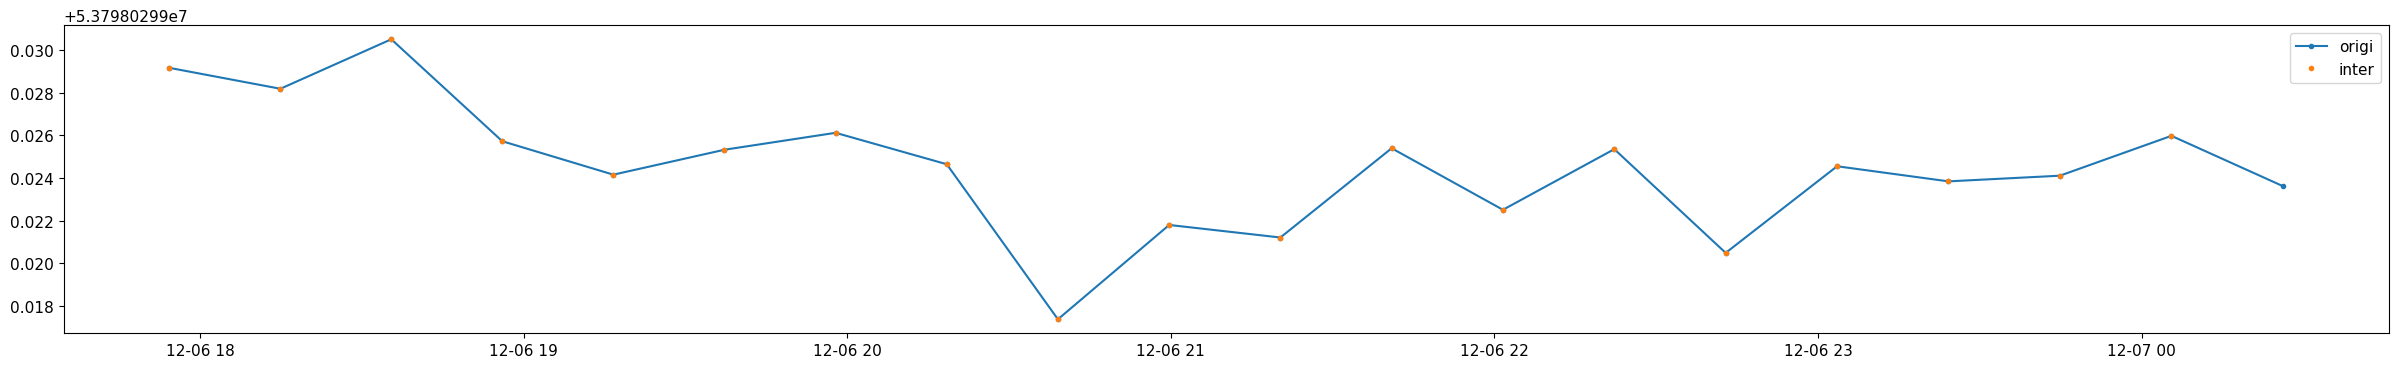

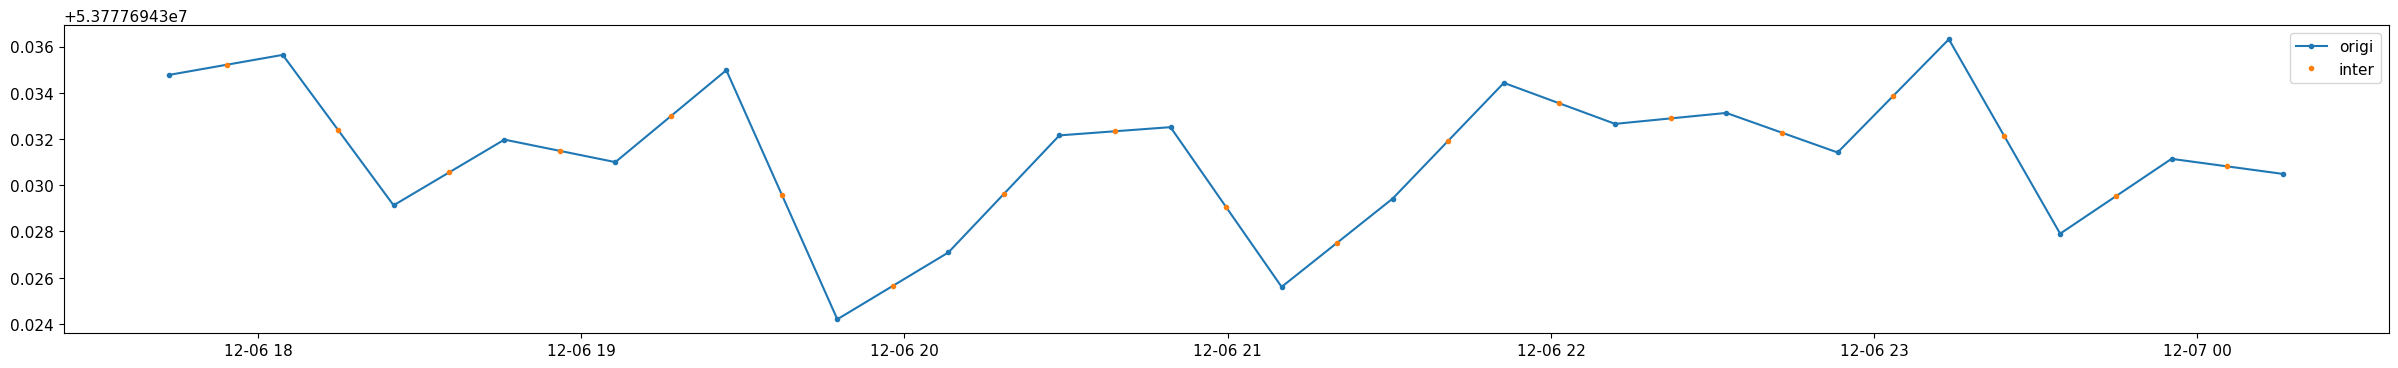

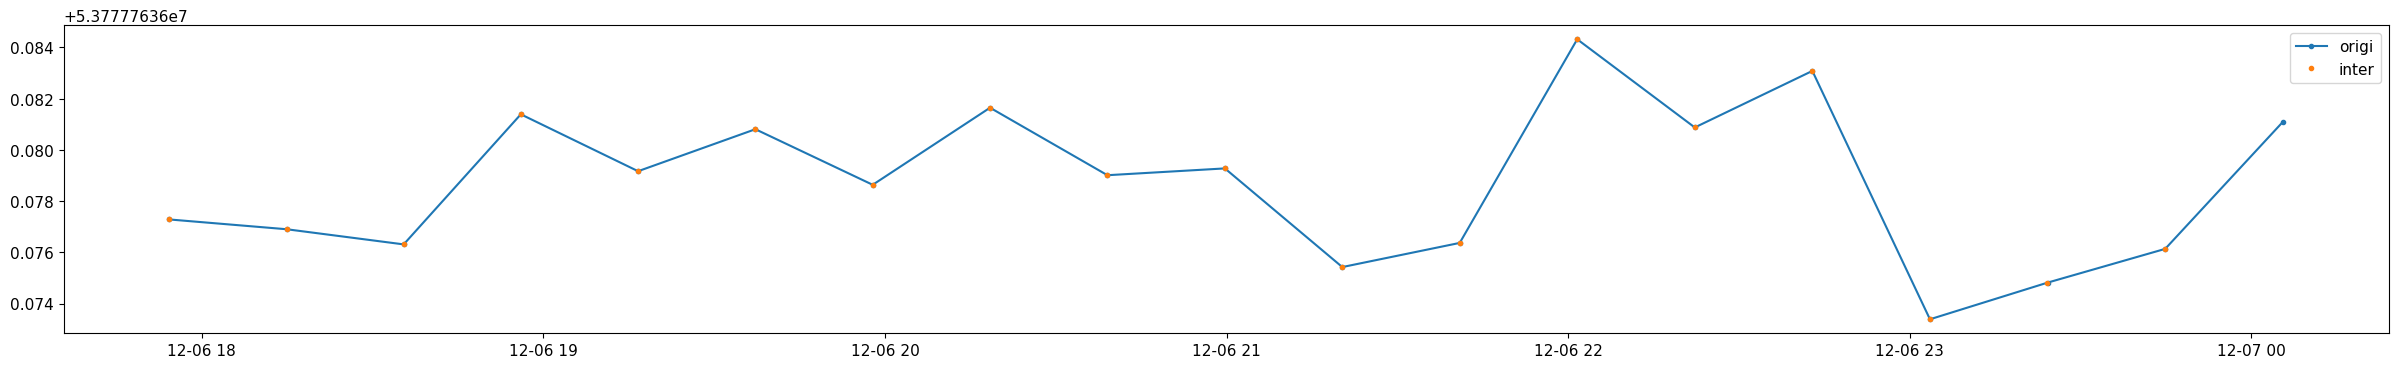

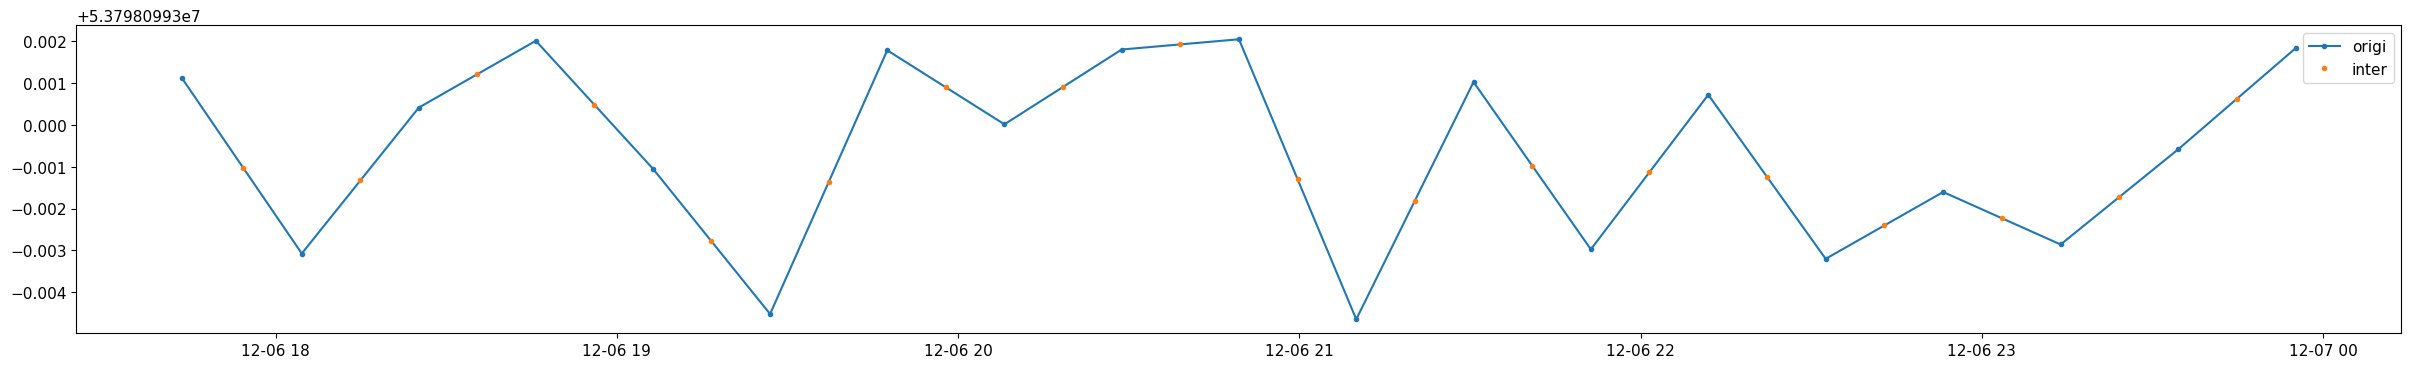

In [38]:
pd.options.display.float_format = '{: .12f}'.format
#step9_interpolate_results = data_conversion.fix_column_dtypes(step9_interpolate_results)
#display(step9_interpolated_data[:5])
#display(step9_interpolate_results[:5])
#display(step8_naive_results["ion_numer"].unique())

step9_interpolate_results["Rminus"] = step9_interpolate_results["R"] - 1.0
step9b_interpolate_results["Rminus"] = step9b_interpolate_results["R"] - 1.0

step9_interpolate_results.to_csv(results_dir + "step9_interpolate_results.csv")
step9b_interpolate_results.to_csv(results_dir + "step9b_interpolate_results.csv")
step9_interpolate_results.to_csv(results_dir + "step9_interpolate_results.txt", sep="\t")
step9b_interpolate_results.to_csv(results_dir + "step9b_interpolate_results.txt", sep="\t")
print(step9_interpolate_results.columns)
fig = px.line(step9_interpolate_results, x="time_p", y="Rminus", error_y="dratio_nu_c", facet_row='trap', hover_data=['mcycle', 'cycle', "ion_numer", "ion_denom"])
fig.update_yaxes(matches=None)
fig.show()

fig = px.line(step9b_interpolate_results, x="time_p", y="Rminus", error_y="dratio_nu_c", facet_row='trap', hover_data=['mcycle', 'cycle', "ion_numer", "ion_denom"])
fig.update_yaxes(matches=None)
fig.show()


for tr in traps:
    nuc1 = step9_interpolated_data[(step9_interpolated_data["trap"]==tr) & (step9_interpolated_data["position"]=="position_1")]["nu_c"]
    nuc2 = step9_interpolated_data[(step9_interpolated_data["trap"]==tr) & (step9_interpolated_data["position"]=="position_2")]["nu_c"]
    nuc1o = step9_data[(step9_data["trap"]==tr) & (step9_data["position"]=="position_1")]["nu_c"]
    nuc2o = step9_data[(step9_data["trap"]==tr) & (step9_data["position"]=="position_2")]["nu_c"]
    
    time1 = step9_interpolated_data[(step9_interpolated_data["trap"]==tr) & (step9_interpolated_data["position"]=="position_1")]["time_p"]
    time2 = step9_interpolated_data[(step9_interpolated_data["trap"]==tr) & (step9_interpolated_data["position"]=="position_2")]["time_p"]
    time1o = step9_data[(step9_data["trap"]==tr) & (step9_data["position"]=="position_1")]["time_p"]
    time2o = step9_data[(step9_data["trap"]==tr) & (step9_data["position"]=="position_2")]["time_p"]
    
    plt.rcParams['figure.figsize'] = (30, 4)
    plt.plot(time1o, nuc1o, ".-", label="origi")
    plt.plot(time1, nuc1, ".", label="inter")
    plt.legend()
    plt.show()
    plt.plot(time2o, nuc2o, ".-", label="origi")
    plt.plot(time2, nuc2, ".", label="inter")
    plt.legend()
    plt.show()
    

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated  (2, 1)	0.0003781417866	0.0000000000142	0.0000000000155	1.1853677130753	1.0887459359627	1.1094313050563		19		0.0000000000622	0.0000000000668	0.9996220011506	15.4552662628738	
interpolated  (3, 1)	0.0003781418069	0.0000000000155	0.0000000000139	0.8018567862704	0.8954645644974	1.1124299782087		18		0.0000000000665	0.0000000000582	0.9996220011303	15.5126208662308	
interother (2, 1)	0.0003781417882	0.0000000000154	0.0000000000173	1.2574302406232	1.1213519700001	1.1094313050563		19		0.0000000000676	0.0000000000740	0.9996220011489	17.2398426626214	
interother (3, 1)	0.0003781418036	0.0000000000147	0.0000000000132	0.8093622179593	0.8996456068693	1.1124299782087		18		0.0000000000625	0.0000000000558	0.9996220011335	14.6607697176350	


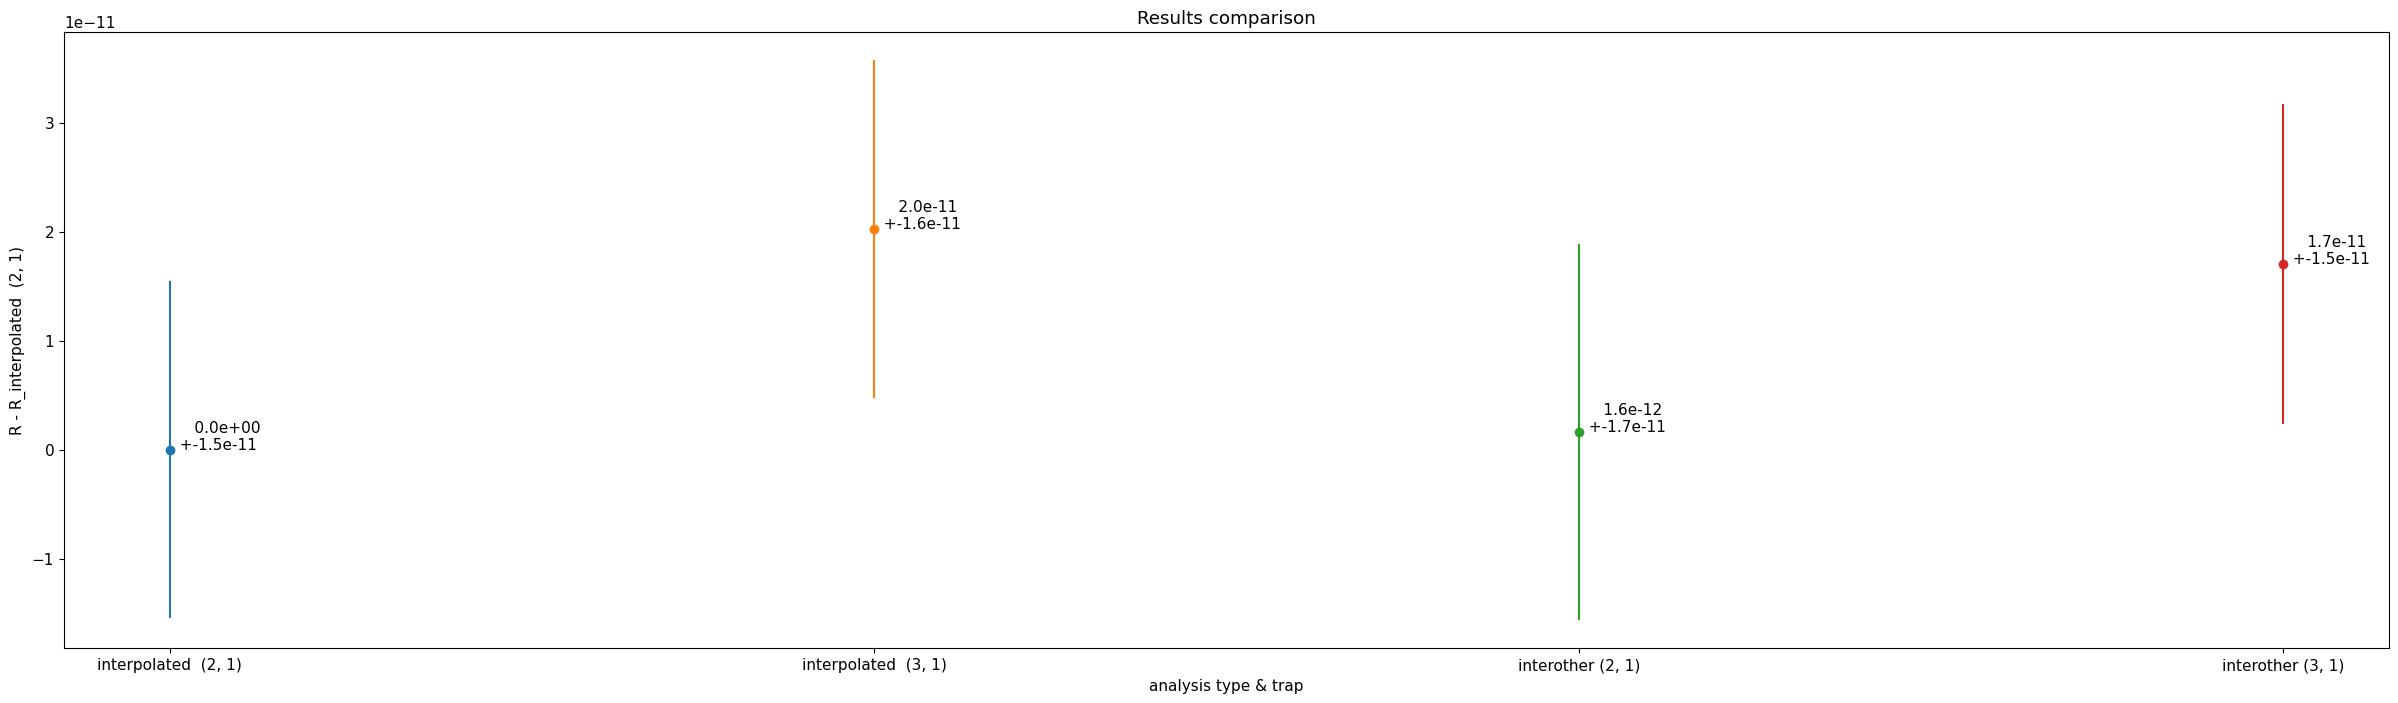

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated  2	0.0003781417866	0.0000000000142	0.0000000000155	1.1853677130753	1.0887459359627	1.1094313050563		19		0.0000000000622	0.0000000000668	0.9996220011506	15.4552662628738	
interpolated  3	0.0003781418069	0.0000000000155	0.0000000000139	0.8018567862704	0.8954645644974	1.1124299782087		18		0.0000000000665	0.0000000000582	0.9996220011303	15.5126208662308	
interother 2	0.0003781417882	0.0000000000154	0.0000000000173	1.2574302406232	1.1213519700001	1.1094313050563		19		0.0000000000676	0.0000000000740	0.9996220011489	17.2398426626214	
interother 3	0.0003781418036	0.0000000000147	0.0000000000132	0.8093622179593	0.8996456068693	1.1124299782087		18		0.0000000000625	0.0000000000558	0.9996220011335	14.6607697176350	


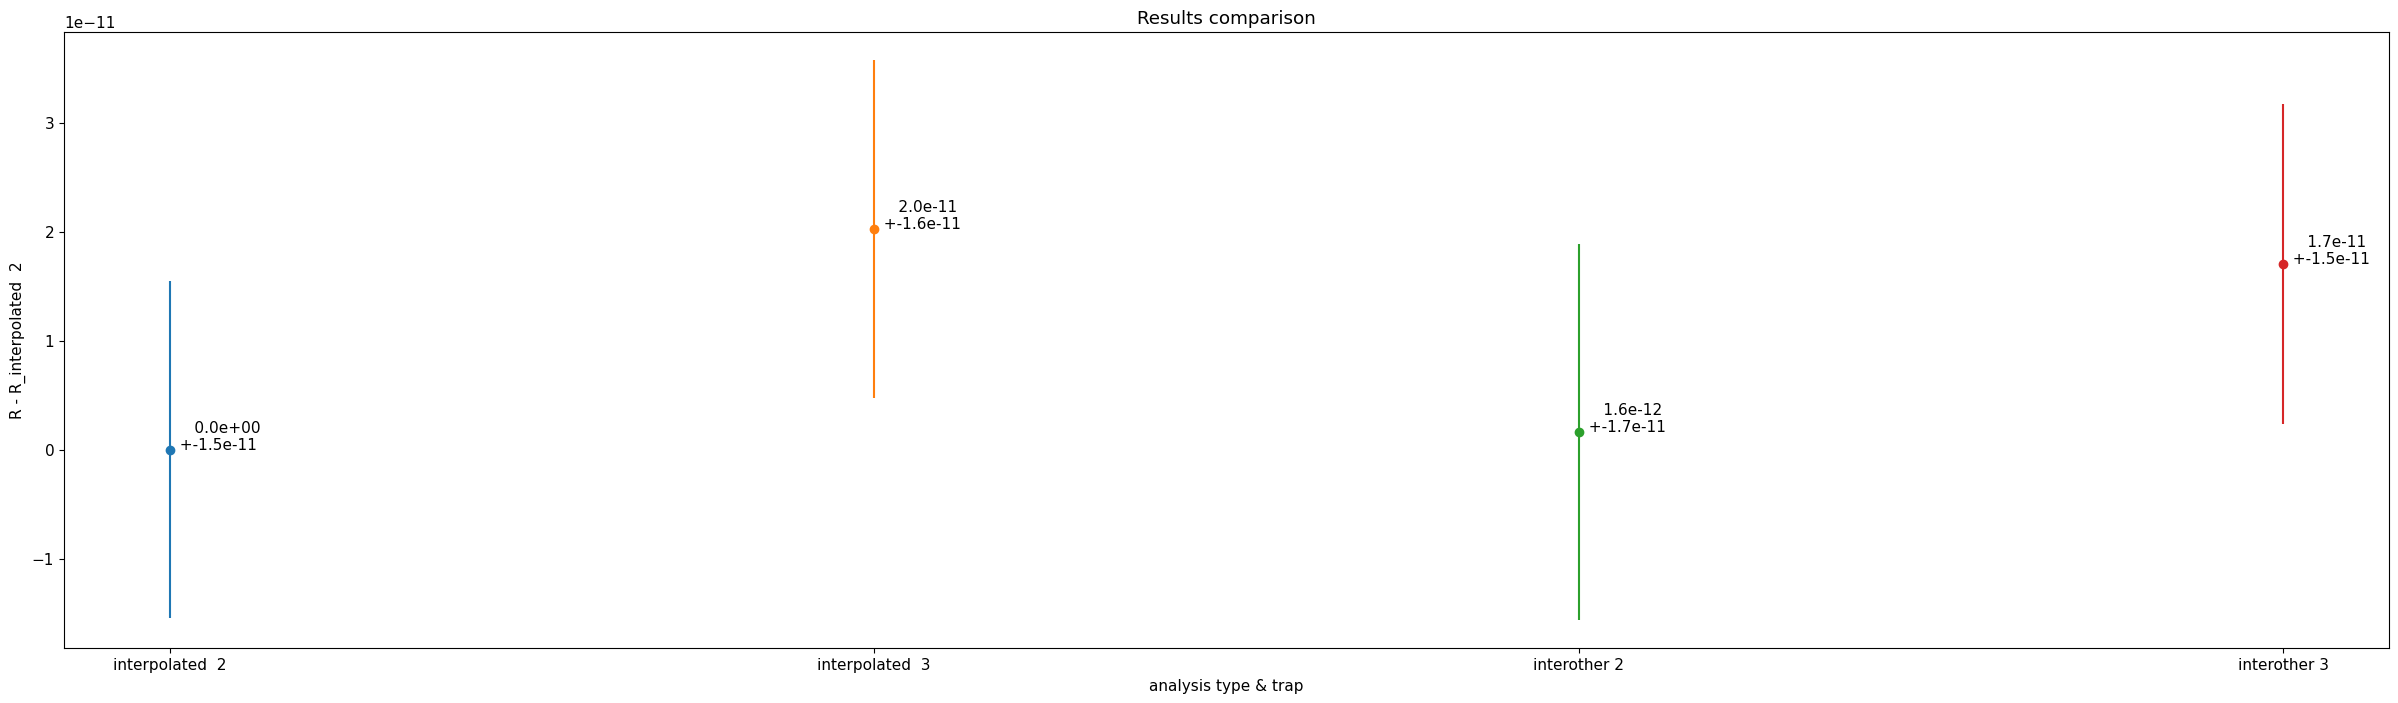

mcycle          Rminus              dR              time_p trap  \
0       1 -0.000377998859  0.000000000060 2021-12-06 17:54:17    2   
1       1 -0.000377998894  0.000000000062 2021-12-06 18:14:53    2   
2       1 -0.000377998971  0.000000000059 2021-12-06 18:35:27    2   
3       1 -0.000377998865  0.000000000061 2021-12-06 18:56:01    2   
4       1 -0.000377998808  0.000000000064 2021-12-06 19:16:37    2   
..    ...             ...             ...                 ...  ...   
69      1  0.000378141697  0.000000000066 2021-12-06 22:32:33    3   
70      1  0.000378141796  0.000000000063 2021-12-06 22:53:12    3   
71      1  0.000378141850  0.000000000069 2021-12-06 23:13:52    3   
72      1  0.000378141867  0.000000000062 2021-12-06 23:34:31    3   
73      1  0.000378141853  0.000000000062 2021-12-06 23:55:11    3   

         analysis  
0   interpolated   
1   interpolated   
2   interpolated   
3   interpolated   
4   interpolated   
..            ...  
69     interother  
70     interother  
71     interother  
72     interother  
73     interother  

[74 rows x 6 columns]

In [39]:
results = {
    "interpolated ": step9_interpolate_results,
    "interother": step9b_interpolate_results,
}

visualization.compare(results, groupby=["trap", "mcycle"], auto_flip=True)
visualization.compare(results, groupby=["trap"], auto_flip=True)

### Step 10: Polynom-fit ratio determinatioin

The function ```polynom_fit.fit_sharedpoly_ratio``` does everything you need for shared polynomial fits: looping over group sizes, autogrouping, looping over polynom degrees; you can choose between different fit methods and you get all and the already filtered best settings results back; You can use it on single trap data or on trap ratio data for poly-cancel (later). It does either take single trap data or single trap ratio data. Here the docstring of the function for explanation:

In [40]:
print(polynom_fit.fit_sharedpoly_ratio.__doc__)

Performs a shared polynom fit on y data in the pandas table. The data is mixed in the table and identified using a seperate column 
    (data_identifier) for us typically 'position' or in case of the cancellation method 'trap'. The group size and number of degrees of the
    polynom function can be lists to loop over these possible settings. The results will include the fit results of all settings with columns
    identifying the groupsizes, group indexes, number of polynom degree. Also all the polynomial parameters and fit quality estimators will
    be included.

    The structure of the input df should be (at least):
    | idx | keep_columns (e.g. mc, trap, ...) | x (e.g. time) | y (e.g. nu_c) | yerr (e.g. dnu_c) | data_identifier (e.g. position) |

    The structure of the output df will be:
    | idx | keep_columns | groupsize | degree | group | cycle_start | cycle_stop | x | R | dR | chi2 | chi2red | AIC | AICc | BIC | ion_numer | ion_denom | fit_parameter ... |

    Some notes o

If you still want to try your manual grouping, you can use the following cell to pre-group the data with the ```start_size``` and manually modify the grouping inside the plot.

In [41]:
# you might want to do manual grouping
temp_df = pd.DataFrame()
for gname, grp in step7_results.groupby(['mcycle', 'trap']):
    grp = polynom_fit.auto_group_subset(grp, 5, 5-1)
    temp_df = temp_df.append(grp)

temp_df.sort_values(['mcycle', 'trap', 'time_p'], inplace=True)
temp_df.reset_index(drop=True, inplace=True)
#display(step7_results)

visualization.manual_grouping_plot(temp_df, x="epoch_p")

In [42]:
step10_polyfit_data = temp_df

In [43]:
Rguess = step9_interpolate_results['R'].mean()

step10_polyfit = pd.DataFrame()
step10_polyfit_best_fits = pd.DataFrame()
step10_polyfit_best = pd.DataFrame()
degrees = settings.get("polydegrees", 'auto')
polygrouping = settings.get("polygrouping", 'auto')
mode = settings.get("poly_mode", 'curvefit_sqrt')
crit = settings.get("poly_criterion", 'AICc')
group_crit = settings.get("group_criterion", 'AICc')
invert = settings.get("invert", True)
import time
start = time.perf_counter()

for idx, mc in enumerate(mcs):
    for idx2, trap in enumerate(traps):
        print(">>> mcycle:", mc, "trap:", trap)
        # get the subset
        subset = step10_polyfit_data[ (step10_polyfit_data["mcycle"] == mc) & (step10_polyfit_data["trap"] == trap) ]
        if len(subset.index) < 3:
            invert = not invert
            continue
        if len(subset.position.unique()) != 2:
            invert = not invert
            continue
        
        # get the testing parameters
        if isinstance(polygrouping, str) and polygrouping == 'auto':
            max_degree = int(np.ceil(len(subset.cycle.unique())/2))
            print("max degree", max_degree)
            group_sizes = list(range(3, int(max_degree+1))) # e.g. 24 data points->12 points per position->6/6 is the smallest splitting
            group_sizes.append(0) # 0 stands for full main cycle
            #group_sizes.append(-1) # -1 stands for the manual grouping
        else:
            group_sizes = polygrouping
        if not group_sizes:
            group_sizes = [3]
        print("group sizes:", group_sizes)

        if isinstance(degrees, str) and degrees == 'auto':
            max_degree = min( [ len(subset.cycle.unique())-2, 9 ] ) # maximum degree 15 ( anything else is... too much(?) )
            poly_degrees = list( range(1, max_degree) ) # e.g. full data set 24 data points - 2 for ratio and keeping one free
        else:
            poly_degrees = degrees
        if not poly_degrees:
            poly_degrees = [1]
        print("polynom degrees:", poly_degrees)

        # fit with all the settings
        subset, results, best_fits, best_results = polynom_fit.fit_sharedpoly_ratio(subset, Rguess, y="nu_c", yerr="dnu_c", data_identifier="position", 
                                               invert=invert, groupsize=group_sizes, degree=poly_degrees, mode=mode, 
                                               x="time_p", keep_columns=["mcycle", "trap"], bestfit=crit, bestgroupsize=group_crit, show=False)
        
        step10_polyfit = step10_polyfit.append(results)
        step10_polyfit_best_fits = step10_polyfit.append(best_fits)
        step10_polyfit_best = step10_polyfit_best.append(best_results)
        
        print(">>> EOA mcycle:", mc, "trap:", trap)
        
        if len(traps)!=1:
            invert = not invert
                
stop = time.perf_counter()
print("time:", stop-start)

step10_polyfit['Rminus'] = step10_polyfit['R'] - 1
step10_polyfit_best_fits['Rminus'] = step10_polyfit_best_fits['R'] - 1
step10_polyfit_best['Rminus'] = step10_polyfit_best['R'] - 1
display(step10_polyfit_best_fits)

pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{: .12f}'.format
display(step10_polyfit.head(10))
display(step10_polyfit_best)

step10_polyfit.to_csv(results_dir + "step10_polyfit.csv")
step10_polyfit.to_csv(results_dir + "step10_polyfit.txt", sep="\t")
step10_polyfit_best_fits.to_csv(results_dir + "step10_polyfit_best_fits.csv")
step10_polyfit_best_fits.to_csv(results_dir + "step10_polyfit_best_fits.txt", sep="\t")
step10_polyfit_best.to_csv(results_dir + "step10_polyfit_best.csv")
step10_polyfit_best.to_csv(results_dir + "step10_polyfit_best.txt", sep="\t")

>>> mcycle: 1 trap: 2
group sizes: [0]
polynom degrees: [1, 2, 3, 4, 5, 6, 7, 8]
all in one group...
>> group sizes: 0 polynom degree: 1
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.4010126392349775e-11
>> group sizes: 0 polynom degree: 2
>> group sizes: 0 polynom degree: 3
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.6010304193514457e-11
>> group sizes: 0 polynom degree: 4
>> group sizes: 0 polynom degree: 5
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.5992540625120455e-11
>> group sizes: 0 polynom degree: 6
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.6010304193514457e-11
>> group sizes: 0 polynom degree: 7
>> group sizes: 0 polynom degree: 8
> best in group idx/size:  1.0 0 with criterion: AICc degree: 2
only one groupsize, no optimization possible 1


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



>>> EOA mcycle: 1 trap: 2
>>> mcycle: 1 trap: 3
group sizes: [0]
polynom degrees: [1, 2, 3, 4, 5, 6, 7, 8]
all in one group...
>> group sizes: 0 polynom degree: 1
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.400191074196755e-11
>> group sizes: 0 polynom degree: 2
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.400191074196755e-11
>> group sizes: 0 polynom degree: 3
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.400191074196755e-11
>> group sizes: 0 polynom degree: 4
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.000000082740371e-10
>> group sizes: 0 polynom degree: 5
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.8001822255087063e-11
>> group sizes: 0 polynom degree: 6
>> group sizes: 0 polynom degree: 7
>> group sizes: 0 polynom degree: 8
> best in group idx/size:  1.0 0 with criterion: AICc degree: 6
only one groupsize, no optimization possible 1


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



>>> EOA mcycle: 1 trap: 3
>>> mcycle: 2 trap: 2
>>> mcycle: 2 trap: 3
time: 0.3911744269999957


AIC              AICc               BIC               R  \
0 -286.813898875796 -286.147232209129 -429.302438678012  1.000378141787   
1 -316.037872032255 -314.895014889398 -456.837532380357  1.000378141791   
2 -287.422292186924 -285.657586304571 -426.533073080912  1.000378141790   
3 -316.141096889536 -313.595642344081 -453.562998329410  1.000378141791   
4 -282.547910757423 -279.047910757423 -418.280932743183  1.000378141792   
5 -282.297847007089 -277.652685716766 -416.341989538735  1.000378141788   
6 -311.253480168957 -305.253480168957 -443.608743246489  1.000378141791   
7 -306.725855246605 -299.139648350053 -437.392238870023  1.000378141799   
0 -280.018789199678 -279.312906846737 -413.334304790102  1.000378141804   
1 -278.184495267578 -276.972374055457 -409.862424698276  1.000378141803   
2 -277.128775747902 -275.253775747902 -407.169119018873  1.000378141806   
3  -45.821918819744  -43.112241400389 -174.224675930989  1.000378139795   
4 -272.827112158143 -269.093778824809 -399.592283109661  1.000378141804   
5 -303.939004504485 -298.973487263106 -429.066589296277  1.000378141807   
6 -303.015483551357 -296.586912122785 -426.505482183422  1.000378141804   
7 -299.494115731845 -291.345967583697 -421.346528204184  1.000378141824   
0 -303.939004504485 -298.973487263106 -429.066589296277  1.000378141807   

                      c0              c1              c2              c3  \
0  53798029.926042035222 -0.000000119690             NaN             NaN   
1  53798029.929057896137 -0.000000868705  0.000000000031             NaN   
2  53798029.930692620575 -0.000001714539  0.000000000120 -0.000000000000   
3  53798029.929477803409 -0.000000660364 -0.000000000082  0.000000000000   
4  53798029.928302906454  0.000000926114 -0.000000000558  0.000000000000   
5  53798029.928618244827  0.000000053282 -0.000000000177 -0.000000000000   
6  53798029.929297082126 -0.000001362777  0.000000000670 -0.000000000000   
7  53798029.928560264409  0.000002417056 -0.000000002378  0.000000000001   
0  53777763.679074689746 -0.000000026728             NaN             NaN   
1  53777763.678770147264  0.000000058929 -0.000000000004             NaN   
2  53777763.677665710449  0.000000689145 -0.000000000075  0.000000000000   
3  53777763.739704325795 -0.000000490554  0.000000000927 -0.000000000000   
4  53777763.678611367941 -0.000000283319  0.000000000101 -0.000000000000   
5  53777763.679918199778 -0.000003352244  0.000000001584 -0.000000000000   
6  53777763.679937042296 -0.000003453441  0.000000001641 -0.000000000000   
7  53777763.679047398269 -0.000004191674  0.000000002339 -0.000000000001   
0  53777763.679918199778 -0.000003352244  0.000000001584 -0.000000000000   

               c4              c5  ...              dR          degree  \
0             NaN             NaN  ...  0.000000000014  1.000000000000   
1             NaN             NaN  ...  0.000000000015  2.000000000000   
2             NaN             NaN  ...  0.000000000016  3.000000000000   
3 -0.000000000000             NaN  ...  0.000000000016  4.000000000000   
4 -0.000000000000  0.000000000000  ...  0.000000000016  5.000000000000   
5  0.000000000000 -0.000000000000  ...  0.000000000016  6.000000000000   
6  0.000000000000 -0.000000000000  ...  0.000000000016  7.000000000000   
7 -0.000000000000  0.000000000000  ...  0.000000000016  8.000000000000   
0             NaN             NaN  ...  0.000000000014  1.000000000000   
1             NaN             NaN  ...  0.000000000014  2.000000000000   
2             NaN             NaN  ...  0.000000000014  3.000000000000   
3 -0.000000000000             NaN  ...  0.000000000100  4.000000000000   
4 -0.000000000000  0.000000000000  ...  0.000000000018  5.000000000000   
5  0.000000000000 -0.000000000000  ...  0.000000000015  6.000000000000   
6  0.000000000000 -0.000000000000  ...  0.000000000016  7.000000000000   
7  0.000000000000 -0.000000000000  ...  0.000000000016  8.000000000000   
0  0.000000000000 -0.000000000000  ...

AIC              AICc               BIC               R  \
0 -286.813898875796 -286.147232209129 -429.302438678012  1.000378141787   
1 -316.037872032255 -314.895014889398 -456.837532380357  1.000378141791   
2 -287.422292186924 -285.657586304571 -426.533073080912  1.000378141790   
3 -316.141096889536 -313.595642344081 -453.562998329410  1.000378141791   
4 -282.547910757423 -279.047910757423 -418.280932743183  1.000378141792   
5 -282.297847007089 -277.652685716766 -416.341989538735  1.000378141788   
6 -311.253480168957 -305.253480168957 -443.608743246489  1.000378141791   
7 -306.725855246605 -299.139648350053 -437.392238870023  1.000378141799   
0 -280.018789199678 -279.312906846737 -413.334304790102  1.000378141804   
1 -278.184495267578 -276.972374055457 -409.862424698276  1.000378141803   

                      c0              c1              c2              c3  \
0  53798029.926042035222 -0.000000119690             NaN             NaN   
1  53798029.929057896137 -0.000000868705  0.000000000031             NaN   
2  53798029.930692620575 -0.000001714539  0.000000000120 -0.000000000000   
3  53798029.929477803409 -0.000000660364 -0.000000000082  0.000000000000   
4  53798029.928302906454  0.000000926114 -0.000000000558  0.000000000000   
5  53798029.928618244827  0.000000053282 -0.000000000177 -0.000000000000   
6  53798029.929297082126 -0.000001362777  0.000000000670 -0.000000000000   
7  53798029.928560264409  0.000002417056 -0.000000002378  0.000000000001   
0  53777763.679074689746 -0.000000026728             NaN             NaN   
1  53777763.678770147264  0.000000058929 -0.000000000004             NaN   

               c4              c5  ...              dR          degree  \
0             NaN             NaN  ...  0.000000000014  1.000000000000   
1             NaN             NaN  ...  0.000000000015  2.000000000000   
2             NaN             NaN  ...  0.000000000016  3.000000000000   
3 -0.000000000000             NaN  ...  0.000000000016  4.000000000000   
4 -0.000000000000  0.000000000000  ...  0.000000000016  5.000000000000   
5  0.000000000000 -0.000000000000  ...  0.000000000016  6.000000000000   
6  0.000000000000 -0.000000000000  ...  0.000000000016  7.000000000000   
7 -0.000000000000  0.000000000000  ...  0.000000000016  8.000000000000   
0             NaN             NaN  ...  0.000000000014  1.000000000000   
1             NaN             NaN  ...  0.000000000014  2.000000000000   

            group       groupsize  ion_denom  ion_numer          mcycle  \
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
1  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
2  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
3  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
4  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
5  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
6  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
7  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
1  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   

                         time_p            trap          Rminus  
0 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141787  
1 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141791  
2 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141790  
3 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141791  
4 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141792  
5 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141788  
6 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141791  
7 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141799  
0 2021-12-06 20:54:36.168421120  3.000000000000  0.000378141804  
1 2021-12-06 20:54:36.168421120  3.000000000000  0.0

AIC              AICc               BIC               R  \
0 -316.037872032255 -314.895014889398 -456.837532380357  1.000378141791   
0 -303.939004504485 -298.973487263106 -429.066589296277  1.000378141807   

                      c0              c1              c2              c3  \
0  53798029.929057896137 -0.000000868705  0.000000000031             NaN   
0  53777763.679918199778 -0.000003352244  0.000000001584 -0.000000000000   

               c4              c5  ...              dR          degree  \
0             NaN             NaN  ...  0.000000000015  2.000000000000   
0  0.000000000000 -0.000000000000  ...  0.000000000015  6.000000000000   

            group       groupsize  ion_denom  ion_numer          mcycle  \
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   

                         time_p            trap          Rminus  
0 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141791  
0 2021-12-06 20:54:36.168421120  3.000000000000  0.000378141807  

[2 rows x 27 columns]

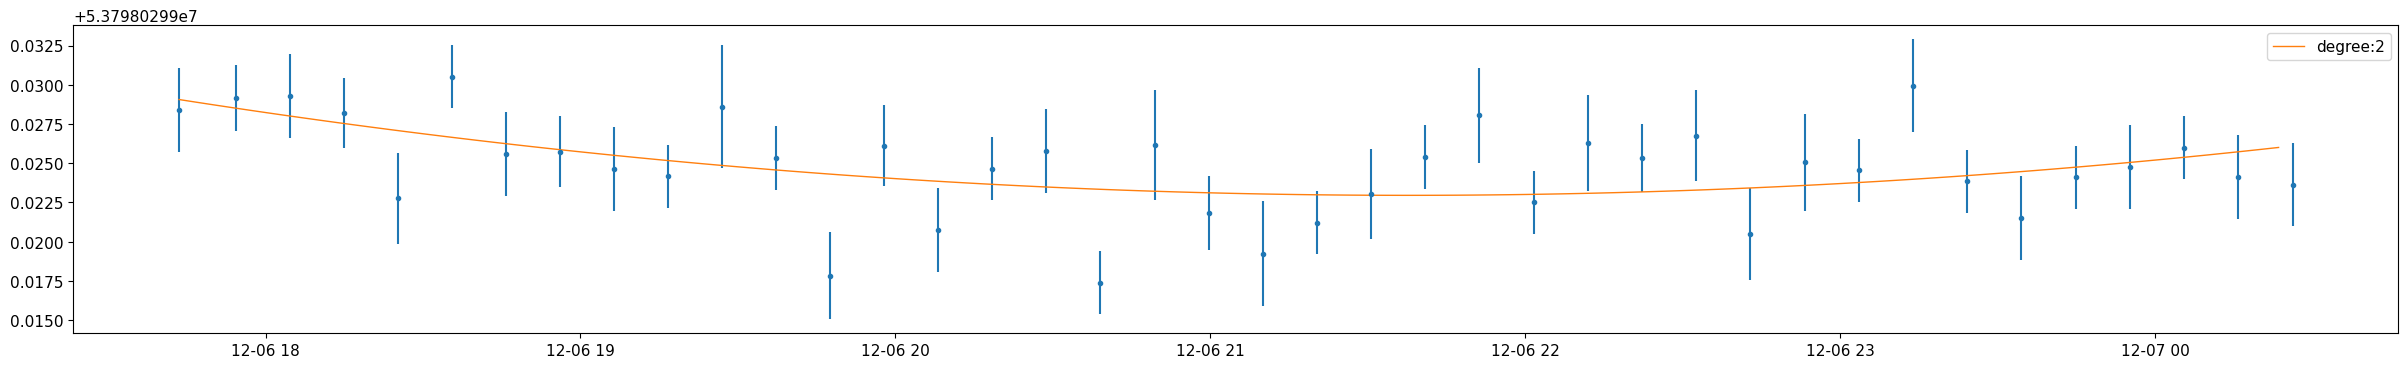

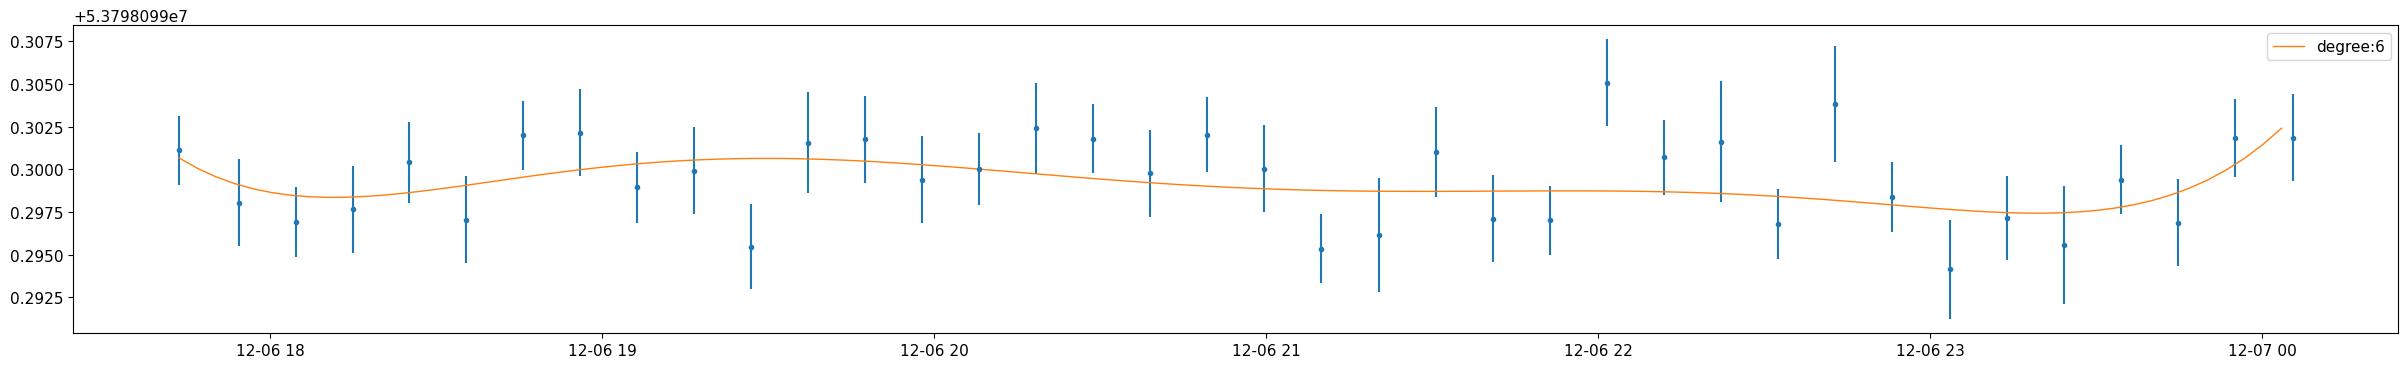

In [44]:
# show results
polynom_fit.plot_best_results(step7_results, step10_polyfit_best, line_width = 1)


In [45]:
#polynom_fit.compare_grouping_fits(step7_results, subset_results, groupby=['trap'], x="time_p", y="nu_c", yerr="dnu_c", ratio='R', line_width=15)

In [46]:
#for grpname, grp in step10_polyfit.groupby(["mcycle", "trap", "groupsize"]):
    #fig = px.line(grp, x="degree", y="R", error_y="dR", color="group", hover_data=['group'], title="mcycle, trap: "+str(grpname) )
    #fig.show()
    
Rmean = pd.DataFrame()
for grpname, grp in step10_polyfit.groupby(["mcycle", "trap"]):    
    R, inner, outer, chi2red = statistics.complete_mean_and_error(grp.R.to_numpy(), grp.dR.to_numpy())
    dR = np.nanmax([inner, outer])
    print(grpname, R, inner, outer, chi2red)
    Rmean = Rmean.append( pd.Series(data=[grpname[0], grpname[1], R, dR, inner, outer, chi2red], 
                                    index=["mcycle", "trap", "R", "dR", "inner", "outer", "chi2red"]), 
                          ignore_index=True )
    
results = pd.DataFrame()
for grpname, grp in step10_polyfit.groupby(["mcycle", "trap", "groupsize", "degree"]):
    R, inner, outer, chi2red = statistics.complete_mean_and_error(grp.R.to_numpy(), grp.dR.to_numpy())
    dR = max([inner, outer])
    #print(R-1, inner, outer, chi2red)
    Rall = float(Rmean[ (Rmean["mcycle"]==grpname[0]) & (Rmean["trap"]==grpname[1]) ]["R"])
    results = results.append( pd.Series(data=[grpname[0], grpname[1], grpname[2], grpname[3], R, R-Rall, dR, inner, outer, chi2red], 
                                        index=["mcycle", "trap", "groupsize", "degree", "R", "R-Rmean", "dR", "inner", "outer", "chi2red"]), 
                              ignore_index=True )

fig = px.line(results, x="degree", y="R-Rmean", error_y="dR", color="groupsize", facet_row="mcycle", facet_col="trap" )
fig.update_layout( yaxis = dict( showexponent = 'all', exponentformat = 'e' ) )
fig.show()
fig = px.line(results, x="groupsize", y="R-Rmean", error_y="dR", color="degree", facet_row="mcycle", facet_col="trap" )
fig.update_layout( yaxis = dict( showexponent = 'all', exponentformat = 'e' ) )
fig.show()


(1.0, 2.0) 1.0003781417909445 5.502195213261253e-12 1.2770025651692506e-12 0.053865605965442306
(1.0, 3.0) 1.0003781418006046 5.736938188828642e-12 4.360789404812802e-11 57.77898205977702


In [47]:
results = pd.DataFrame()
step10_polyfit_best_fits2 = pd.DataFrame(columns=step10_polyfit_best_fits.columns)
for grpname, grp in step10_polyfit.groupby(["mcycle", "trap", "groupsize", "group"]):
    mincrit = grp[crit].min()
    sub = grp[ grp[crit]==mincrit ]
    step10_polyfit_best_fits2 = step10_polyfit_best_fits2.append(sub, ignore_index=True)

print(len(step10_polyfit_best_fits2))
for grpname, grp in step10_polyfit_best_fits2.groupby(["mcycle", "trap", "groupsize"]):
    print('mc, trap, size, indexes, total', grpname[0], grpname[1], grpname[2], grp.group.unique(), len(grp), grp.degree.unique())
    #display(grp)
    R, inner, outer, chi2red = statistics.complete_mean_and_error(grp.R.to_numpy(), grp.dR.to_numpy())
    dR = max([inner, outer])
    mean_degree = float(grp.degree.mean())
    #print(R-1, inner, outer, chi2red)
    Rall = float(Rmean[ (Rmean["mcycle"]==grpname[0]) & (Rmean["trap"]==grpname[1]) ]["R"])
    results = results.append( pd.Series(data=[grpname[0], grpname[1], grpname[2], R, R-1, R-Rall, dR, inner, outer, chi2red, mean_degree], 
                                        index=["mcycle", "trap", "groupsize", "R", "Rminus", "R-Rmean", "dR", "inner", "outer", "chi2red", "mean_degree"]), 
                              ignore_index=True )
    
fig = px.line(results, x="groupsize", y="R-Rmean", error_y="dR", facet_row="mcycle", facet_col="trap", color="mean_degree", hover_data=['mcycle', "R-Rmean", "dR", "mean_degree"] )
fig.update_layout( yaxis = dict( showexponent = 'all', exponentformat = 'e' ) )
fig.show()

results.to_csv(results_dir + "step10_polyfit_grouping_best_for_plot.csv")
results.to_csv(results_dir + "step10_polyfit_grouping_best_for_plot.txt", sep="\t")
step10_polyfit_best_fits2.to_csv(results_dir + "step10_polyfit_best_fits.csv")
step10_polyfit_best_fits2.to_csv(results_dir + "step10_polyfit_best_fits.txt", sep="\t")

2
mc, trap, size, indexes, total 1.0 2.0 0.0 [1.] 1 [2.]
mc, trap, size, indexes, total 1.0 3.0 0.0 [1.] 1 [6.]


In [48]:
display(step10_polyfit_best)
chi2s = step10_polyfit_best.chi2red.to_numpy()
print(chi2s)
print(chi2s.mean(), chi2s.std())

AIC              AICc               BIC               R  \
0 -316.037872032255 -314.895014889398 -456.837532380357  1.000378141791   
0 -303.939004504485 -298.973487263106 -429.066589296277  1.000378141807   

                      c0              c1              c2              c3  \
0  53798029.929057896137 -0.000000868705  0.000000000031             NaN   
0  53777763.679918199778 -0.000003352244  0.000000001584 -0.000000000000   

               c4              c5  ...              dR          degree  \
0             NaN             NaN  ...  0.000000000015  2.000000000000   
0  0.000000000000 -0.000000000000  ...  0.000000000015  6.000000000000   

            group       groupsize  ion_denom  ion_numer          mcycle  \
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   

                         time_p            trap          Rminus  
0 2021-12-06 21:04:55.400000000  2.000000000000  0.000378141791  
0 2021-12-06 20:54:36.168421120  3.000000000000  0.000378141807  

[2 rows x 27 columns]

[1.224469377511 1.134498308067]
1.1794838427887306 0.0449855347218272


analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated (2, 1)	0.0003781417866	0.0000000000142	0.0000000000155	1.1853677130753	1.0887459359627	1.1094313050563		19		0.0000000000622	0.0000000000668	0.9996220011506	15.4552662628738	
interpolated (3, 1)	0.0003781418069	0.0000000000155	0.0000000000139	0.8018567862704	0.8954645644974	1.1124299782087		18		0.0000000000665	0.0000000000582	0.9996220011303	15.5126208662308	
poly         (2.0, 1.0)	0.0003781417906	0.0000000000150	nan	nan	nan	1.4770000000000		1		0.0000000000150	0.0000000000000	0.9996220011466	14.9918693317184	
poly         (3.0, 1.0)	0.0003781418074	0.0000000000153	nan	nan	nan	1.4770000000000		1		0.0000000000153	0.0000000000000	0.9996220011297	15.2601693299521	


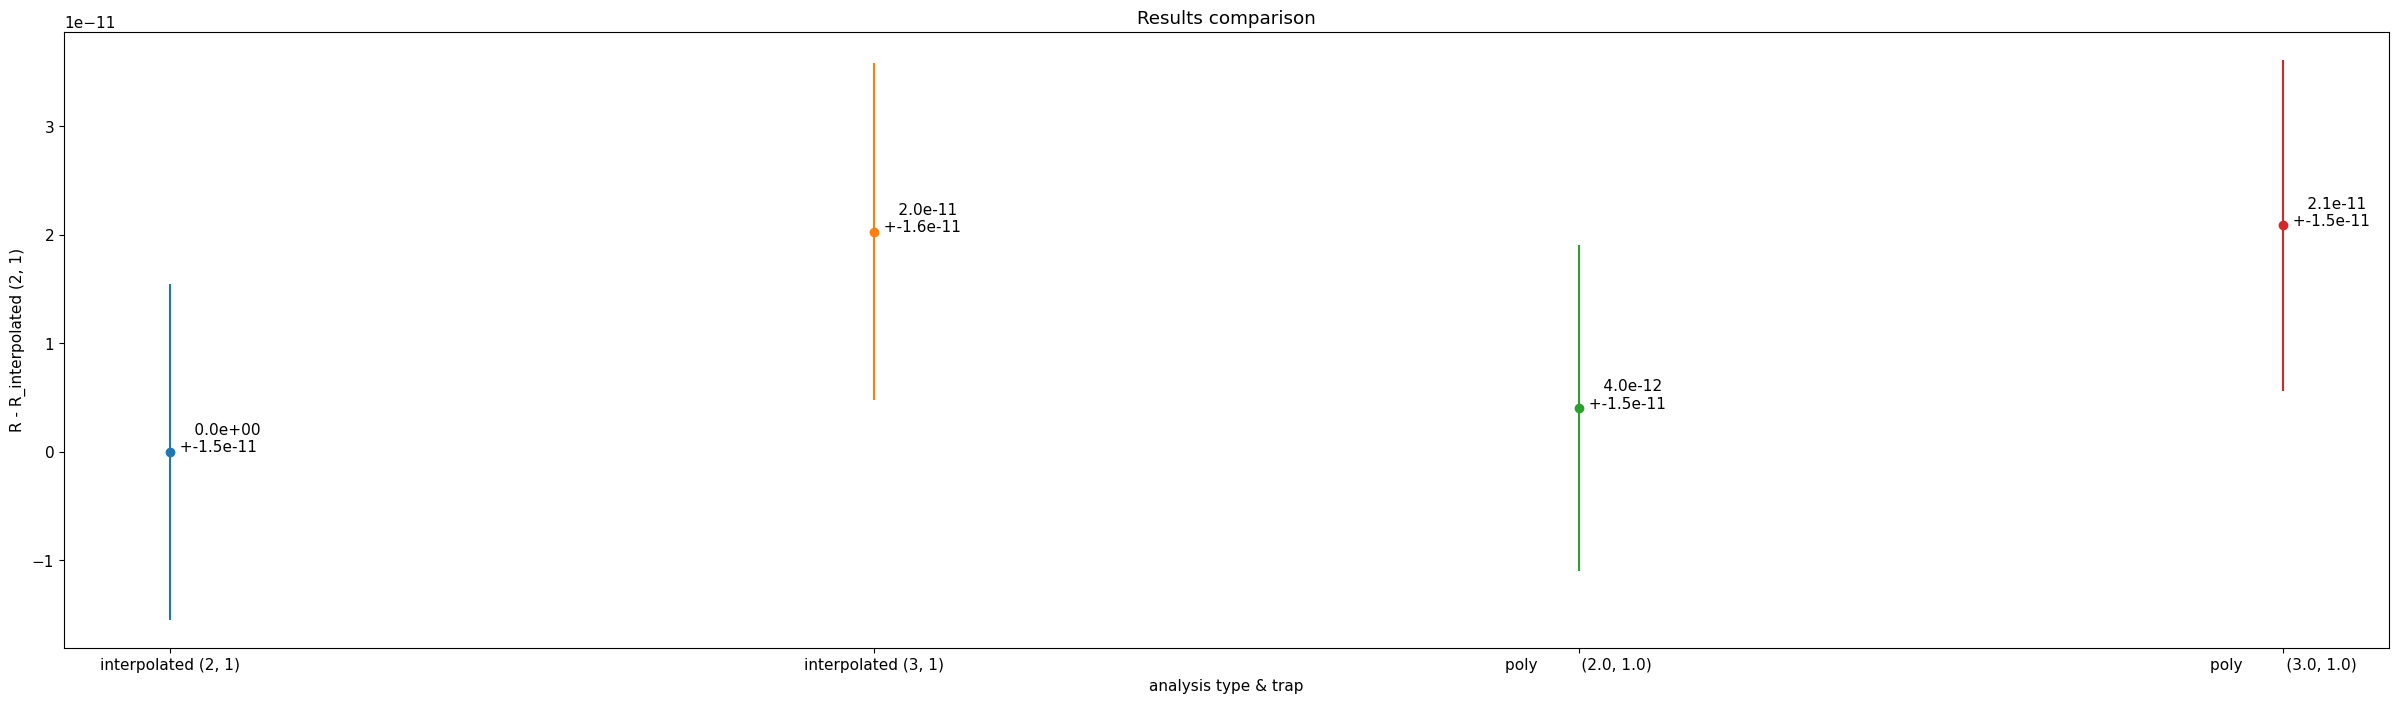

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated 2	-0.0003779988494	0.0000000000142	0.0000000000155	1.1853669058540	1.0887455652511	1.1094313050563		19		0.0000000000622	0.0000000000667	1.0003781417866	15.4669517704273	
interpolated 3	-0.0003779988697	0.0000000000155	0.0000000000139	0.8018570870206	0.8954647324270	1.1124299782087		18		0.0000000000664	0.0000000000582	1.0003781418069	15.5243550253665	
poly         2.0	0.0003781417906	0.0000000000150	nan	nan	nan	1.4770000000000		1		0.0000000000150	0.0000000000000	0.9996220011466	14.9918693317184	
poly         3.0	0.0003781418074	0.0000000000153	nan	nan	nan	1.4770000000000		1		0.0000000000153	0.0000000000000	0.9996220011297	15.2601693299521	


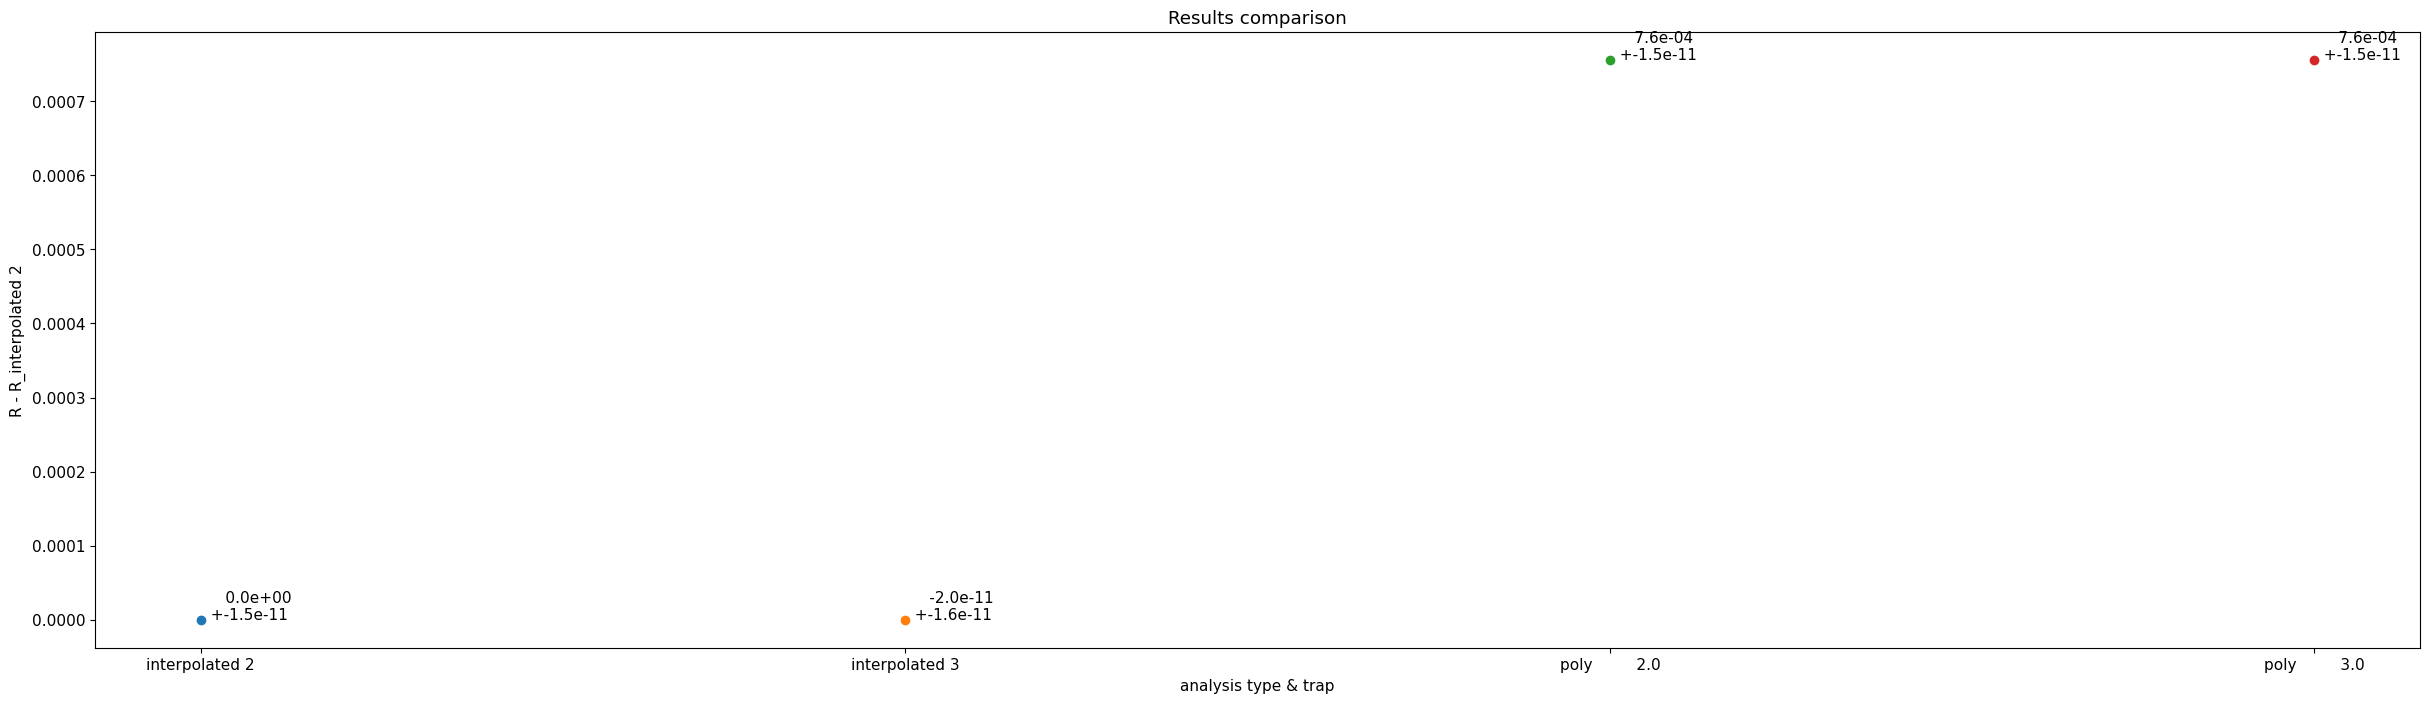

interpol	 1-R = 3.779988586589e-04 +- 1.047e-11 (inner) +- 1.046e-11 (outer), chi2red 1.00


In [49]:
results = {
    #"ame          ": one_df,
    "interpolated": step9_interpolate_results,
    "poly        ": step10_polyfit_best,
}

visualization.compare(results, auto_flip=True)
visualization.compare(results, auto_flip=False, groupby=["trap"])
step9_interpolate_results["masked"] = False
step9_interpolate_results["measurement"] = "this"
fig = visualization.ratio_plot(step9_interpolate_results, "interpol", start = None, stop = None, student=False, showlegend=False, remove_masked=True, time_column="time_p")
fig.show()


In [50]:
print(step10_polyfit_best.columns)
display(step10_polyfit_best_fits.AICc)
print(step10_polyfit_best.chi2red)

Index(['AIC', 'AICc', 'BIC', 'R', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6',
       'c7', 'c8', 'chi2', 'chi2red', 'cycle_start', 'cycle_stop', 'dR',
       'degree', 'group', 'groupsize', 'ion_denom', 'ion_numer', 'mcycle',
       'time_p', 'trap', 'Rminus', 'analysis'],
      dtype='object')


0   -286.147232209129
1   -314.895014889398
2   -285.657586304571
3   -313.595642344081
4   -279.047910757423
5   -277.652685716766
6   -305.253480168957
7   -299.139648350053
0   -279.312906846737
1   -276.972374055457
2   -275.253775747902
3    -43.112241400389
4   -269.093778824809
5   -298.973487263106
6   -296.586912122785
7   -291.345967583697
0   -298.973487263106
Name: AICc, dtype: float64

0    1.224469377511
0    1.134498308067
Name: chi2red, dtype: float64


#### SECOND: CANCELLATION ANALYSIS

B: Interpolation

C: Polynomial

##### FIRST: Data preparation (creating trap ratios) --- ONLY WITH 2 TRAP DATA!!! 
e.g.

Rpos1 = nu_c(trap2, t1) / nu_c(trap3, t1) = qmA * B(trap2, t1) / qmB / B(trap3, t1) = qmA/qmB * rohB(t1)

Rpos2 = nu_c(trap2, t2) / nu_c(trap3, t2) = qmB * B(trap2, t2) / qmA / B(trap3, t2) = qmB/qmA * rohB(t2)

for naive calculation then:

Rcancel = sqrt( Rpos1 / Rpos2 ) = sqrt( qmA^2/qmB^2 ) , if rohB(t1) == rohB(t2)

In [51]:
step11_trap_ratio_data = pd.DataFrame()
step7_results.sort_values(["mcycle", "trap", "time_p"], inplace=True)
step7_results.reset_index(drop=True, inplace=True)
traps = [2,3] # in this position trap 2 is numerator (trap2/trap3)

unique_traps = step7_results.trap.unique()
if len(unique_traps) < 2:
    raise KeyError('not enough trap data for cancellation, only traps: '+str(unique_traps))

# ONLY WITH 2 TRAP DATA!!!
for name, grp in step7_results.groupby(["mcycle", "position"]):
    print("mcycle, trap:", name, "positions", grp.position.unique(), "subcycles", grp.subcycle.unique())

    results = ratio_analysis.calc_ratios(grp, y=['nu_c'], yerr=['dnu_c'], groupbys=['cycle', 'subcycle'], identifier="trap", ident_types=traps,
            keep_columns=['mcycle', 'position', 'time_p', 'trap'], additional_identifiers=['ion', 'time_p', 'time'], mean_columns=[])
        
    step11_trap_ratio_data = step11_trap_ratio_data.append(results, ignore_index=True)

step11_trap_ratio_data['masked'] = False
display(step11_trap_ratio_data)

mcycle, trap: (1, 'position_1') positions ['position_1'] subcycles [1]
not enough data in this group ['cycle', 'subcycle'] (20, 1)
mcycle, trap: (1, 'position_2') positions ['position_2'] subcycles [1]
not enough data in this group ['cycle', 'subcycle'] (20, 1)


mcycle    position                  time_p trap cycle subcycle  \
0       1  position_1 2021-12-06 17:54:17.800    2     1        1   
1       1  position_1 2021-12-06 18:14:53.000    2     2        1   
2       1  position_1 2021-12-06 18:35:27.200    2     3        1   
3       1  position_1 2021-12-06 18:56:01.900    2     4        1   
4       1  position_1 2021-12-06 19:16:37.500    2     5        1   
5       1  position_1 2021-12-06 19:37:13.800    2     6        1   
6       1  position_1 2021-12-06 19:57:50.300    2     7        1   
7       1  position_1 2021-12-06 20:18:26.800    2     8        1   
8       1  position_1 2021-12-06 20:39:03.700    2     9        1   
9       1  position_1 2021-12-06 20:59:41.700    2    10        1   
10      1  position_1 2021-12-06 21:20:19.000    2    11        1   
11      1  position_1 2021-12-06 21:40:56.700    2    12        1   
12      1  position_1 2021-12-06 22:01:34.900    2    13        1   
13      1  position_1 2021-12-06 22:22:13.800    2    14        1   
14      1  position_1 2021-12-06 22:42:52.900    2    15        1   
15      1  position_1 2021-12-06 23:03:32.300    2    16        1   
16      1  position_1 2021-12-06 23:24:11.300    2    17        1   
17      1  position_1 2021-12-06 23:44:51.300    2    18        1   
18      1  position_1 2021-12-07 00:05:32.000    2    19        1   
19      1  position_2 2021-12-06 17:43:31.500    2     1        1   
20      1  position_2 2021-12-06 18:04:35.100    2     2        1   
21      1  position_2 2021-12-06 18:25:10.000    2     3        1   
22      1  position_2 2021-12-06 18:45:44.400    2     4        1   
23      1  position_2 2021-12-06 19:06:19.500    2     5        1   
24      1  position_2 2021-12-06 19:26:55.800    2     6        1   
25      1  position_2 2021-12-06 19:47:32.000    2     7        1   
26      1  position_2 2021-12-06 20:08:08.300    2     8        1   
27      1  position_2 2021-12-06 20:28:45.300    2     9        1   
28      1  position_2 2021-12-06 20:49:22.800    2    10        1   
29      1  position_2 2021-12-06 21:10:00.400    2    11        1   
30      1  position_2 2021-12-06 21:30:37.800    2    12        1   
31      1  position_2 2021-12-06 21:51:15.500    2    13        1   
32      1  position_2 2021-12-06 22:11:54.500    2    14        1   
33      1  position_2 2021-12-06 22:32:33.100    2    15        1   
34      1  position_2 2021-12-06 22:53:12.500    2    16        1   
35      1  position_2 2021-12-06 23:13:52.000    2    17        1   
36      1  position_2 2021-12-06 23:34:31.100    2    18        1   
37      1  position_2 2021-12-06 23:55:11.700    2    19        1   

        ratio_nu_c     dratio_nu_c trap_numer trap_denom ion_numer ion_denom  \
0   1.000376851890  0.000000000061          2          3   20Ne10+     12C6+   
1   1.000376851879  0.000000000063          2          3   20Ne10+     12C6+   
2   1.000376851933  0.000000000060          2          3   20Ne10+     12C6+   
3   1.000376851750  0.000000000063          2          3   20Ne10+     12C6+   
4   1.000376851762  0.000000000060          2          3   20Ne10+     12C6+   
5   1.000376851753  0.000000000067          2          3   20Ne10+     12C6+   
6   1.000376851808  0.000000000068          2          3   20Ne10+     12C6+   
7   1.000376851725  0.000000000062          2          3   20Ne10+     12C6+   
8   1.000376851639  0.000000000060          2          3   20Ne10+     12C6+   
9   1.000376851716  0.000000000065          2          3   20Ne10+     12C6+   
10  1.000376851777  0.000000000073          2          3   20Ne10+     12C6+   
11  1.000376851837  0.000000000060          2          3   20Ne10+     12C6+   
12  1.000376851635  0.000000000060          2          3   20Ne10+     12C6+   
13  1.000376851752  0.000000000077          2          3   20Ne10+     12C6+   
14  1.000376851621  0.000000000083          2          3   20Ne10+     12C6+   
15  1.000376851877  0.000000000

In [52]:
step11_trap_ratio_data["Rminus"] = step11_trap_ratio_data["ratio_nu_c"] - 1.0

step11_trap_ratio_data.to_csv(results_dir + "step11_trap_ratio_data.csv")
step11_trap_ratio_data.to_csv(results_dir + "step11_trap_ratio_data.txt", sep="\t")

fig = px.line(step11_trap_ratio_data, x="time_p", y="Rminus", error_y="dratio_nu_c", facet_row='position', hover_data=['mcycle', 'cycle'])
fig.update_yaxes(matches=None, showticklabels=True)
fig.show()

### Step 12: Interpolated Cancellation
The trap ratios are interpolated to the same time. It works exacly the same as the interpolation in step 9.

In [53]:
# For the interpolation we have to have averaged data.
step12_cancel_interpol_results = pd.DataFrame()
step12_avg_data = pd.DataFrame()
for grpname, grpdata in step11_trap_ratio_data.groupby(["mcycle", "position"]):
    print('mcycle, position', grpname)
    avgdata = pd.DataFrame()
    for subname, subgrpdata in grpdata.groupby("cycle"):
        avg = statistics.average_subsets(subgrpdata, groupby=["cycle"], errortype="weighted",
                                              columns=["ratio_nu_c", "time_p"], 
                                              dcolumns=["dratio_nu_c", None],
                                              masked=False)
        avgdata = avgdata.append(avg)
        
    avgdata['masked'] = False
    
    # filter by min max boundaries for values, default: min_val: 1, max_val: 1e9:
    avgdata = filtering.minmax_value(avgdata, val="ratio_nu_c", min_val=0, max_val=100)

    # apply autofilter 3-sigma condition: calc mean of values and std
    # if value is outside of mean+-3*std, it is masked
    avgdata = filtering.three_sigma(avgdata, val="ratio_nu_c", err="dratio_nu_c", undrift_xcolumn="time_p", show=False)
    #display(subset)

    # apply autofilter sigma-size: if sigma of value is 3 time bigger
    # then mean sigma, it is masked
    avgdata = filtering.sigma_size(avgdata, err="dratio_nu_c")
       
    step12_avg_data = step12_avg_data.append(avgdata)

print("averaged")
#display(step12_avg_data)
step12_avg_data = step12_avg_data.sort_values("time_p")
step12_avg_data.reset_index(drop=True, inplace=True)
step12_interpolated_data = pd.DataFrame()
step12_cancel_interpol_results = pd.DataFrame()
positions = ["position_1","position_2"] # in this position trap 2 is numerator (trap2/trap3)
if not settings.get("invert", True):
    positions = positions[::-1]

for grpname, grpdata in step12_avg_data.groupby(["mcycle"]):
    print('mcycle', grpname)
    reference, interpolate = 'position_1', 'position_2' # what was measured first in time? Thats the one we want to interpolate

    interpolated_data = ratio_analysis.interpolate(grpdata, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['mcycle'], x="time_p",
                    identifier="position", id_reference=reference, id_interpolate=interpolate,
                    non_linear_uncertainty_per_second=0)
        
    step12_interpolated_data = step12_interpolated_data.append(interpolated_data)
    
    #if not invert:
    #    positions = ["position_1","position_2"]
    #else:
    #    positions = ["position_2","position_1"]
    
    results = ratio_analysis.calc_ratios(interpolated_data, y=['ratio_nu_c'], yerr=['dratio_nu_c'], groupbys=['cycle', 'subcycle'], identifier="position", ident_types=positions,
            keep_columns=['mcycle', 'time_p', 'trap'], additional_identifiers=['ion_numer', 'ion_denom', 'time_p'], mean_columns=[])

    step12_cancel_interpol_results = step12_cancel_interpol_results.append(results, ignore_index=True)
    

mcycle, position (1, 'position_1')
6.319373525069895e-11 -inf 1.539180667852866e-12


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\numpy\core\_methods.py:263: RuntimeWarning:

Degrees of freedom <= 0 for slice



mcycle, position (1, 'position_2')
6.771300247459898e-11 -inf 1.4093567192987894e-12
averaged
mcycle 1.0
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data
WARNING column time was not in original data


In [54]:
#display(step11_cancel_naive_results)

# the 'ratio' calculated in the step before is acutally qmA^2 / qmB^2, so we have to take the sqrt (make sure you get the Error right!)
step12_cancel_interpol_results["R"] = np.sqrt( step12_cancel_interpol_results["ratio_ratio_nu_c"] )
step12_cancel_interpol_results["dR"] = step12_cancel_interpol_results["dratio_ratio_nu_c"]/step12_cancel_interpol_results["R"]/2
step12_cancel_interpol_results["Rminus"] = step12_cancel_interpol_results["R"] - 1    

step12_cancel_interpol_results.to_csv(results_dir + "step12_cancel_interpol_results.csv")
step12_cancel_interpol_results.to_csv(results_dir + "step12_cancel_interpol_results.txt", sep="\t")

fig = px.line(step12_cancel_interpol_results, x="time_p", y="Rminus", error_y="dR", hover_data=['mcycle', 'cycle'])
fig.show()

# TIP: it should be ion_numer_numer = ion_denom_denom and ion_numer_denom = ion_denom_numer (ending up ionA^2 / ionB^2)

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated  (1, 2)	-0.0003779988494	0.0000000000142	0.0000000000155	1.1853669058540	1.0887455652511	1.1094313050563		19		0.0000000000622	0.0000000000667	1.0003781417866	15.4669517704273	
interpolated  (1, 3)	-0.0003779988697	0.0000000000155	0.0000000000139	0.8018570870206	0.8954647324270	1.1124299782087		18		0.0000000000664	0.0000000000582	1.0003781418069	15.5243550253665	
poly all      (1.0, 2.0)	0.0003781417906	0.0000000000150	nan	nan	nan	1.4770000000000		1		0.0000000000150	0.0000000000000	0.9996220011466	14.9918693317184	
poly all      (1.0, 3.0)	0.0003781418074	0.0000000000153	nan	nan	nan	1.4770000000000		1		0.0000000000153	0.0000000000000	0.9996220011297	15.2601693299521	
cancel interp (1.0, 2.0)	-0.0003779988595	0.0000000000096	0.0000000000125	1.7053829051076	1.3059030994326	1.1124299782087		18		0.0000000000409	0.0000000000519	1.0003781417967	12.517613267669

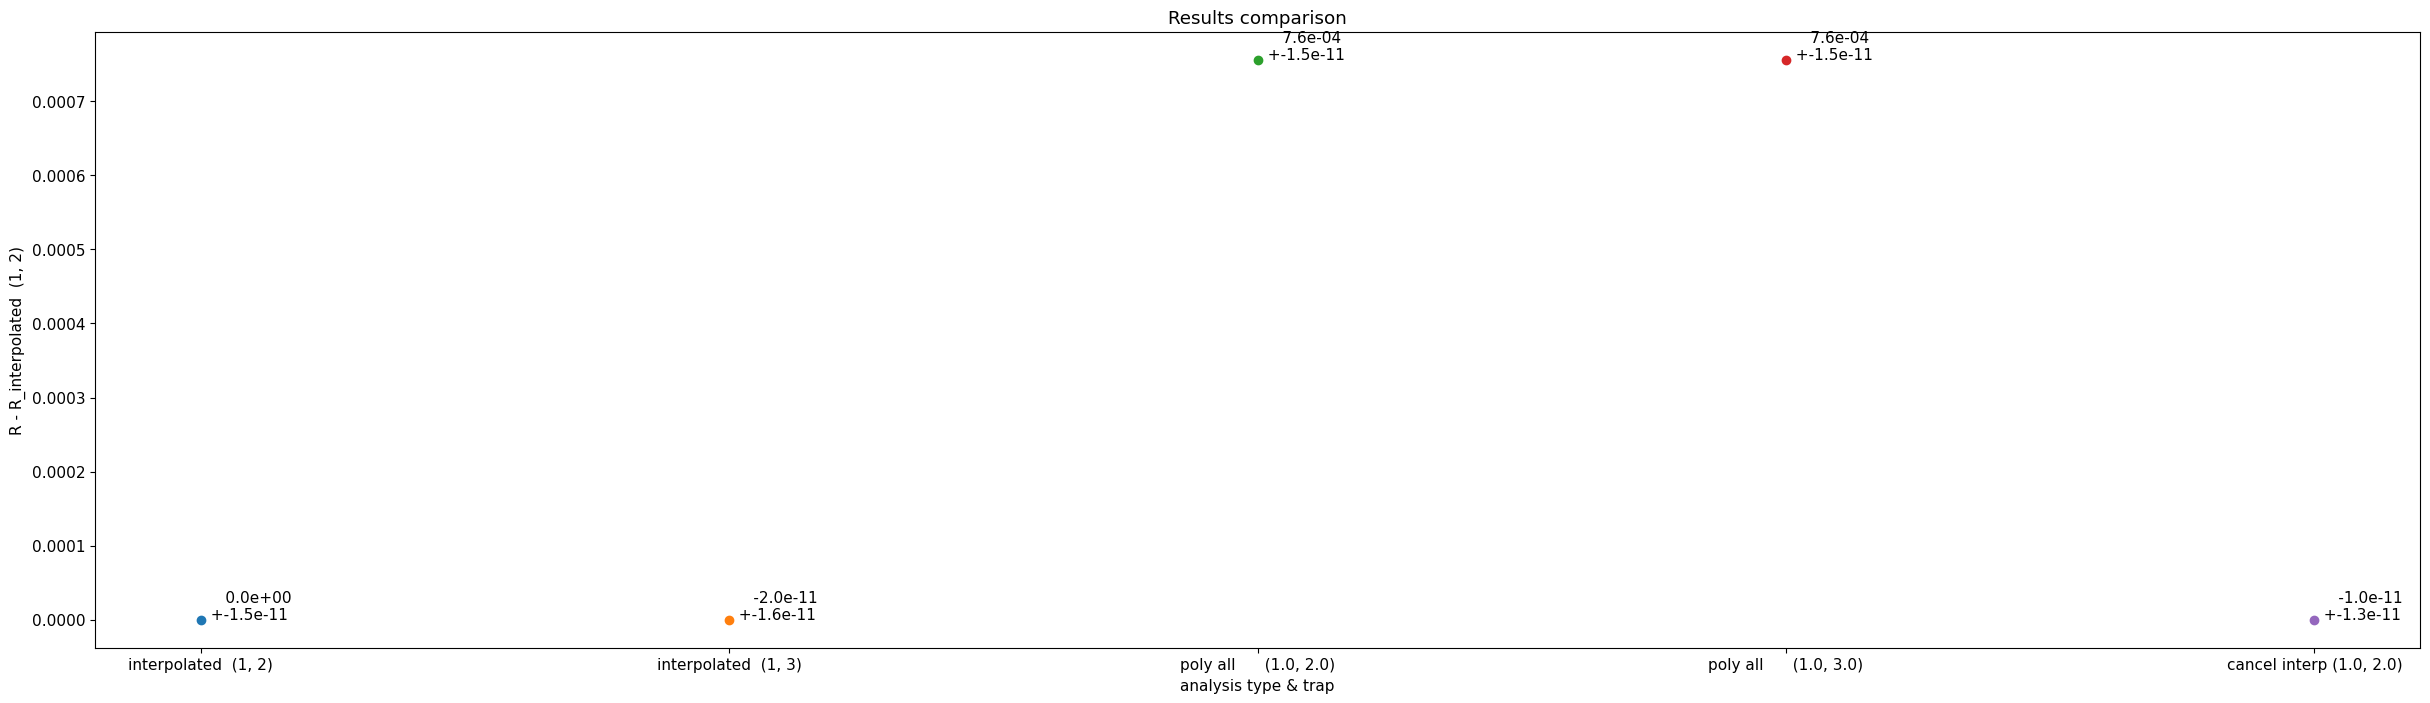

mcycle          Rminus              dR  \
0                1 -0.000377998859  0.000000000060   
1                1 -0.000377998894  0.000000000062   
2                1 -0.000377998971  0.000000000059   
3                1 -0.000377998865  0.000000000061   
4                1 -0.000377998808  0.000000000064   
5                1 -0.000377998893  0.000000000064   
6                1 -0.000377998981  0.000000000066   
7                1 -0.000377998879  0.000000000058   
8                1 -0.000377998694  0.000000000062   
9                1 -0.000377998837  0.000000000069   
10               1 -0.000377998855  0.000000000062   
11               1 -0.000377998851  0.000000000061   
12               1 -0.000377998767  0.000000000061   
13               1 -0.000377998832  0.000000000063   
14               1 -0.000377998753  0.000000000073   
15               1 -0.000377998799  0.000000000061   
16               1 -0.000377998818  0.000000000059   
17               1 -0.000377998871  0.000000000058   
18               1 -0.000377998882  0.000000000058   
19               1 -0.000377998888  0.000000000062   
20               1 -0.000377998889  0.000000000063   
21               1 -0.000377998947  0.000000000063   
22               1 -0.000377998839  0.000000000062   
23               1 -0.000377998820  0.000000000063   
24               1 -0.000377998816  0.000000000071   
25               1 -0.000377998898  0.000000000064   
26               1 -0.000377998842  0.000000000064   
27               1 -0.000377998910  0.000000000062   
28               1 -0.000377998845  0.000000000062   
29               1 -0.000377998908  0.000000000075   
30               1 -0.000377998906  0.000000000064   
31               1 -0.000377998755  0.000000000062   
32               1 -0.000377998817  0.000000000077   
33               1 -0.000377998754  0.000000000074   
34               1 -0.000377998938  0.000000000068   
35               1 -0.000377998921  0.000000000076   
36               1 -0.000377998940  0.000000000063   
37  1.000000000000  0.000378141791  0.000000000015   
38  1.000000000000  0.000378141807  0.000000000015   
39  1.000000000000 -0.000377998874  0.000000000038   
40  1.000000000000 -0.000377998891  0.000000000039   
41  1.000000000000 -0.000377998959  0.000000000038   
42  1.000000000000 -0.000377998852  0.000000000039   
43  1.000000000000 -0.000377998814  0.000000000040   
44  1.000000000000 -0.000377998854  0.000000000043   
45  1.000000000000 -0.000377998939  0.000000000041   
46  1.000000000000 -0.000377998861  0.000000000038   
47  1.000000000000 -0.000377998802  0.000000000039   
48  1.000000000000 -0.000377998841  0.000000000042   
49  1.000000000000 -0.000377998881  0.000000000044   
50  1.000000000000 -0.000377998878  0.000000000039   
51  1.000000000000 -0.000377998761  0.000000000039   
52  1.000000000000 -0.000377998824  0.000000000045   
53  1.000000000000 -0.000377998754  0.000000000048   
54  1.000000000000 -0.000377998868  0.000000000041   
55  1.000000000000 -0.000377998869  0.000000000044   
56  1.000000000000 -0.000377998905  0.000000000038   

                          time_p            trap       analysis  
0  2021-12-06 17:54:17.000000000               2  interpolated   
1  2021-12-06 18:14:53.000000000               2  interpolated   
2  2021-12-06 18:35:27.000000000               2  interpolated   
3  2021-12-06 18:56:01.000000000               2  interpolated   
4  2021-12-06 19:16:37.000000000               2  interpolated   
5  2021-12-06 19:37:13.000000000               2  interpolated   
6  2021-12-06 19:57:50.000000000               2  interpolated   
7  2021-12-06 20:18:26.000000000               2  interpolated   
8  2021-12-06 20:39:03.000000000               2  interpolated   
9  2021-12-06 20:59:41.000000000               2  interpolated   
10 2021-12-06 21:20:19.000000000               2  interpolated   
11 2021-12-06 21:40:56.000000000               2  interpolated   
12 2021-12-06 22:01:3

In [55]:
results = {
    "interpolated ": step9_interpolate_results,
    "poly all     ": step10_polyfit_best,
    "cancel interp": step12_cancel_interpol_results,
}

visualization.compare(results, groupby=["mcycle", "trap"], auto_flip=False)

### Step 13: Polyfit Cancellation


In [56]:
# you might want to do manual grouping
temp_df = pd.DataFrame()
step11_trap_ratio_data['masked'] = False # the ratio calc was already masked selective.
for gname, grp in step11_trap_ratio_data.groupby(['mcycle']):
    grp = polynom_fit.auto_group_subset(grp, 4, 4-1, sortby=["cycle", "time_p"])
    temp_df = temp_df.append(grp)

temp_df.sort_values(['mcycle', 'time_p'], inplace=True)
temp_df.reset_index(drop=True, inplace=True)
#display(step7_results)

visualization.manual_grouping_plot(temp_df, groupby=["mcycle"], sets="position", y='ratio_nu_c', yerr='dratio_nu_c', x="time_p")

In [57]:
step11_trap_ratio_data = temp_df

In [58]:
Rguess = step9_interpolate_results['R'].mean()

step13_cancel_polyfit = pd.DataFrame()
step13_cancel_polyfit_best_fits = pd.DataFrame()
step13_cancel_polyfit_best = pd.DataFrame()
step11_trap_ratio_data['ion'] = step11_trap_ratio_data['ion_numer']
degrees = settings.get("polydegrees", 'auto')
polygrouping = settings.get("polygrouping", 'auto')
invert = settings.get("invert", True)
import time
start = time.perf_counter()

for idx, mc in enumerate(mcs):
    print(">>> mcycle:", mc)
    # get the subset
    subset = step11_trap_ratio_data[ (step11_trap_ratio_data["mcycle"] == mc) ]
    if len(subset.index) < 3:
        continue
    
    # get the testing parameters
    if isinstance(polygrouping, str) and polygrouping == 'auto':
        group_sizes = list(range(3, int(np.ceil(len(subset.cycle.unique())/4))+1)) # e.g. 24 data points->12 points per position->6/6 is the smallest splitting
        group_sizes.append(0) # 0 stands for full main cycle
    else:
        group_sizes = polygrouping
    if not group_sizes:
        group_sizes = [3]
    print("group sizes:", group_sizes)        

    if isinstance(degrees, str) and degrees == 'auto':
        max_degree = min( [ len(subset.cycle.unique())-2, 15 ] ) # maximum degree 15 ( anything else is... too much(?) )
        poly_degrees = list( range(1, max_degree) ) # e.g. full data set 24 data points - 2 for ratio and keeping one free
    else:
        poly_degrees = degrees
    if not poly_degrees:
        poly_degrees = [1]
    print("polynom degrees:", poly_degrees)

    # fit with all the settings
    subset, results, best_fits, best_results = polynom_fit.fit_sharedpoly_ratio(subset, Rguess, y="ratio_nu_c", yerr="dratio_nu_c", data_identifier="position", 
                                           invert=invert, groupsize=group_sizes, degree=poly_degrees, mode='curvefit', 
                                           x="time_p", keep_columns=["mcycle", "trap"], bestfit="AICc", bestgroupsize="chi2red", show=False)

    step13_cancel_polyfit = step13_cancel_polyfit.append(results, ignore_index=True)
    step13_cancel_polyfit_best_fits = step13_cancel_polyfit_best_fits.append(best_fits, ignore_index=True)
    step13_cancel_polyfit_best = step13_cancel_polyfit_best.append(best_results, ignore_index=True)

step13_cancel_polyfit["Rfit"] = step13_cancel_polyfit["R"]
step13_cancel_polyfit_best_fits["Rfit"] = step13_cancel_polyfit_best_fits["R"]
step13_cancel_polyfit_best["Rfit"] = step13_cancel_polyfit_best["R"]
step13_cancel_polyfit["dRfit"] = step13_cancel_polyfit["dR"]
step13_cancel_polyfit_best_fits["dRfit"] = step13_cancel_polyfit_best_fits["dR"]
step13_cancel_polyfit_best["dRfit"] = step13_cancel_polyfit_best["dR"]

stop = time.perf_counter()
print("time:", stop-start)
        
pd.options.mode.chained_assignment = None  # default='warn'
pd.options.display.float_format = '{: .12f}'.format
display(step13_cancel_polyfit.head(10))
display(step13_cancel_polyfit_best)

>>> mcycle: 1
group sizes: [0]
polynom degrees: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
all in one group...
>> group sizes: 0 polynom degree: 1
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.5010215292932116e-11
>> group sizes: 0 polynom degree: 2
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.5010215292932116e-11
>> group sizes: 0 polynom degree: 3
>> group sizes: 0 polynom degree: 4
>> group sizes: 0 polynom degree: 5
no dR from pcov, fixed with chi2 vs. R error estimation: dR= 1.5010215292932116e-11
>> group sizes: 0 polynom degree: 6
>> group sizes: 0 polynom degree: 7
>> group sizes: 0 polynom degree: 8
>> group sizes: 0 polynom degree: 9


C:\Users\door\AppData\Roaming\Python\Python37\site-packages\scipy\optimize\minpack.py:808: OptimizeWarning:

Covariance of the parameters could not be estimated



>> group sizes: 0 polynom degree: 10
>> group sizes: 0 polynom degree: 11
>> group sizes: 0 polynom degree: 12
>> group sizes: 0 polynom degree: 13
>> group sizes: 0 polynom degree: 14
> best in group idx/size:  1.0 0 with criterion: AICc degree: 3
only one groupsize, no optimization possible 1
>>> mcycle: 2
time: 0.31830860700000585


AIC               AICc                BIC               R  \
0 -1598.176876180855 -1597.470993827913 -1731.492391771278  1.000756426585   
1 -1599.440519167441 -1598.228397955320 -1731.118448598138  1.000756426586   
2 -1622.677677044874 -1620.802677044874 -1752.718020315844  1.000756426590   
3 -1622.569281534545 -1619.859604115190 -1750.972038645789  1.000756426591   
4 -1594.899766279700 -1591.166432946367 -1721.664937231218  1.000756426590   
5 -1618.921642948380 -1613.956125707001 -1744.049227740171  1.000756426590   
6 -1616.833060271578 -1610.404488843006 -1740.323058903643  1.000756426589   
7 -1614.847439773095 -1606.699291624947 -1736.699852245434  1.000756426589   
8 -1617.290251387140 -1607.136405233294 -1737.505077699752  1.000756426583   
9 -1615.409306099130 -1602.929306099130 -1733.986546252017  1.000756426583   

               c0              c1             c10  c11  c12  c13  ...  \
0  1.000376851800 -0.000000000000             NaN  NaN  NaN  NaN  ...   
1  1.000376851864 -0.000000000000             NaN  NaN  NaN  NaN  ...   
2  1.000376851913 -0.000000000000             NaN  NaN  NaN  NaN  ...   
3  1.000376851871 -0.000000000000             NaN  NaN  NaN  NaN  ...   
4  1.000376851860  0.000000000000             NaN  NaN  NaN  NaN  ...   
5  1.000376851846  0.000000000000             NaN  NaN  NaN  NaN  ...   
6  1.000376851837  0.000000000000             NaN  NaN  NaN  NaN  ...   
7  1.000376851836  0.000000000000             NaN  NaN  NaN  NaN  ...   
8  1.000376851807  0.000000000000             NaN  NaN  NaN  NaN  ...   
9  1.000376851810  0.000000000000  0.000000000000  NaN  NaN  NaN  ...   

            degree           group       groupsize  ion_denom  ion_numer  \
0   1.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
1   2.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
2   3.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
3   4.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
4   5.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
5   6.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
6   7.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
7   8.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
8   9.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   
9  10.000000000000  1.000000000000  0.000000000000      12C6+    20Ne10+   

           mcycle                        time_p            trap  \
0  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
1  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
2  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
3  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
4  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
5  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
6  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
7  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
8  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   
9  1.000000000000 2021-12-06 20:54:35.631579136  2.000000000000   

             Rfit           dRfit  
0  1.000756426585  0.000000000015  
1  1.000756426586  0.000000000015  
2  1.000756426590  0.000000000022  
3  1.000756426591  0.000000000023  
4  1.000756426590  0.000000000015  
5  1.000756426590  0.000000000024  
6  1.000756426589  0.000000000023  
7  1.000756426589  0.000000000024  
8  1.000756426583  0.000000000024  
9  1.000756426583  0.000000000024  

[10 rows x 34 columns]

AIC               AICc                BIC               R  \
0 -1622.677677044874 -1620.802677044874 -1752.718020315844  1.000756426590   

               c0              c1  c10  c11  c12  c13  ...          degree  \
0  1.000376851913 -0.000000000000  NaN  NaN  NaN  NaN  ...  3.000000000000   

            group       groupsize  ion_denom  ion_numer          mcycle  \
0  1.000000000000  0.000000000000      12C6+    20Ne10+  1.000000000000   

                         time_p            trap            Rfit  \
0 2021-12-06 20:54:35.631579136  2.000000000000  1.000756426590   

            dRfit  
0  0.000000000022  

[1 rows x 34 columns]

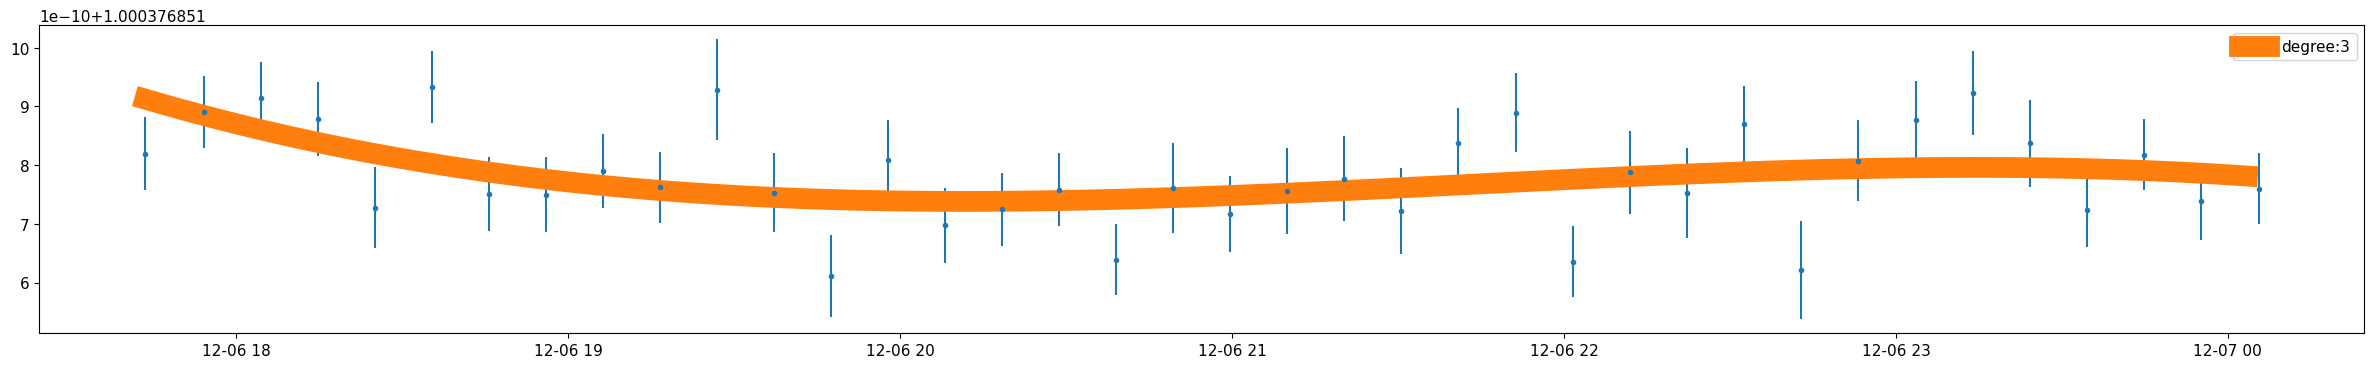

In [59]:
# show results

polynom_fit.plot_best_results(step11_trap_ratio_data, step13_cancel_polyfit_best, groupby=['mcycle'], x='time_p', y='ratio_nu_c', yerr='dratio_nu_c')

In [60]:

# the 'ratio' calculated in the step before is acutally qmA^2 / qmB^2, so we have to take the sqrt (make sure you get the Error right!)
step13_cancel_polyfit["R"] = np.sqrt( step13_cancel_polyfit["Rfit"] )
step13_cancel_polyfit["dR"] = step13_cancel_polyfit["dRfit"]/step13_cancel_polyfit["R"]/2
step13_cancel_polyfit["Rminus"] = step13_cancel_polyfit["R"] - 1
step13_cancel_polyfit_best_fits["R"] = np.sqrt( step13_cancel_polyfit_best_fits["Rfit"] )
step13_cancel_polyfit_best_fits["dR"] = step13_cancel_polyfit_best_fits["dRfit"]/step13_cancel_polyfit_best_fits["R"]/2
step13_cancel_polyfit_best_fits["Rminus"] = step13_cancel_polyfit_best_fits["R"] - 1
step13_cancel_polyfit_best["R"] = np.sqrt( step13_cancel_polyfit_best["Rfit"] )
step13_cancel_polyfit_best["dR"] = step13_cancel_polyfit_best["dRfit"]/step13_cancel_polyfit_best["R"]/2
step13_cancel_polyfit_best["Rminus"] = step13_cancel_polyfit_best["R"] - 1

display(step13_cancel_polyfit_best)


step13_cancel_polyfit.to_csv(results_dir + "step13_cancel_polyfit.csv")
step13_cancel_polyfit.to_csv(results_dir + "step13_cancel_polyfit.txt", sep="\t")
step13_cancel_polyfit_best_fits.to_csv(results_dir + "step13_cancel_polyfit_best_fits.csv")
step13_cancel_polyfit_best_fits.to_csv(results_dir + "step13_cancel_polyfit_best_fits.txt", sep="\t")
step13_cancel_polyfit_best.to_csv(results_dir + "step13_cancel_polyfit_best.csv")

step13_cancel_polyfit_best.to_csv(results_dir + "step13_cancel_polyfit_best.txt", sep="\t")

fig = px.line(step13_cancel_polyfit_best, x="time_p", y="Rminus", error_y="dR", hover_data=['mcycle', 'cycle_start'])
fig.show()

# TIP: it should be ion_numer_numer = ion_denom_denom and ion_numer_denom = ion_denom_numer (ending up ionA^2 / ionB^2)

AIC               AICc                BIC               R  \
0 -1622.677677044874 -1620.802677044874 -1752.718020315844  1.000378141800   

               c0              c1  c10  c11  c12  c13  ...           group  \
0  1.000376851913 -0.000000000000  NaN  NaN  NaN  NaN  ...  1.000000000000   

        groupsize  ion_denom  ion_numer          mcycle  \
0  0.000000000000      12C6+    20Ne10+  1.000000000000   

                         time_p            trap            Rfit  \
0 2021-12-06 20:54:35.631579136  2.000000000000  1.000756426590   

            dRfit          Rminus  
0  0.000000000022  0.000378141800  

[1 rows x 35 columns]

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated (1, 2)	0.0003781417866	0.0000000000142	0.0000000000155	1.1853677130753	1.0887459359627	1.1094313050563		19		0.0000000000622	0.0000000000668	0.9996220011506	15.4552662628738	
interpolated (1, 3)	0.0003781418069	0.0000000000155	0.0000000000139	0.8018567862704	0.8954645644974	1.1124299782087		18		0.0000000000665	0.0000000000582	0.9996220011303	15.5126208662308	
poly (1.0, 2.0)	0.0003781417906	0.0000000000150	nan	nan	nan	1.4770000000000		1		0.0000000000150	0.0000000000000	0.9996220011466	14.9918693317184	
poly (1.0, 3.0)	0.0003781418074	0.0000000000153	nan	nan	nan	1.4770000000000		1		0.0000000000153	0.0000000000000	0.9996220011297	15.2601693299521	
cancel interp (1.0, 2.0)	0.0003781417967	0.0000000000096	0.0000000000125	1.7053815089260	1.3059025648669	1.1124299782087		18		0.0000000000410	0.0000000000519	0.9996220011405	12.5081466489907	
cancel poly (1.0, 2.

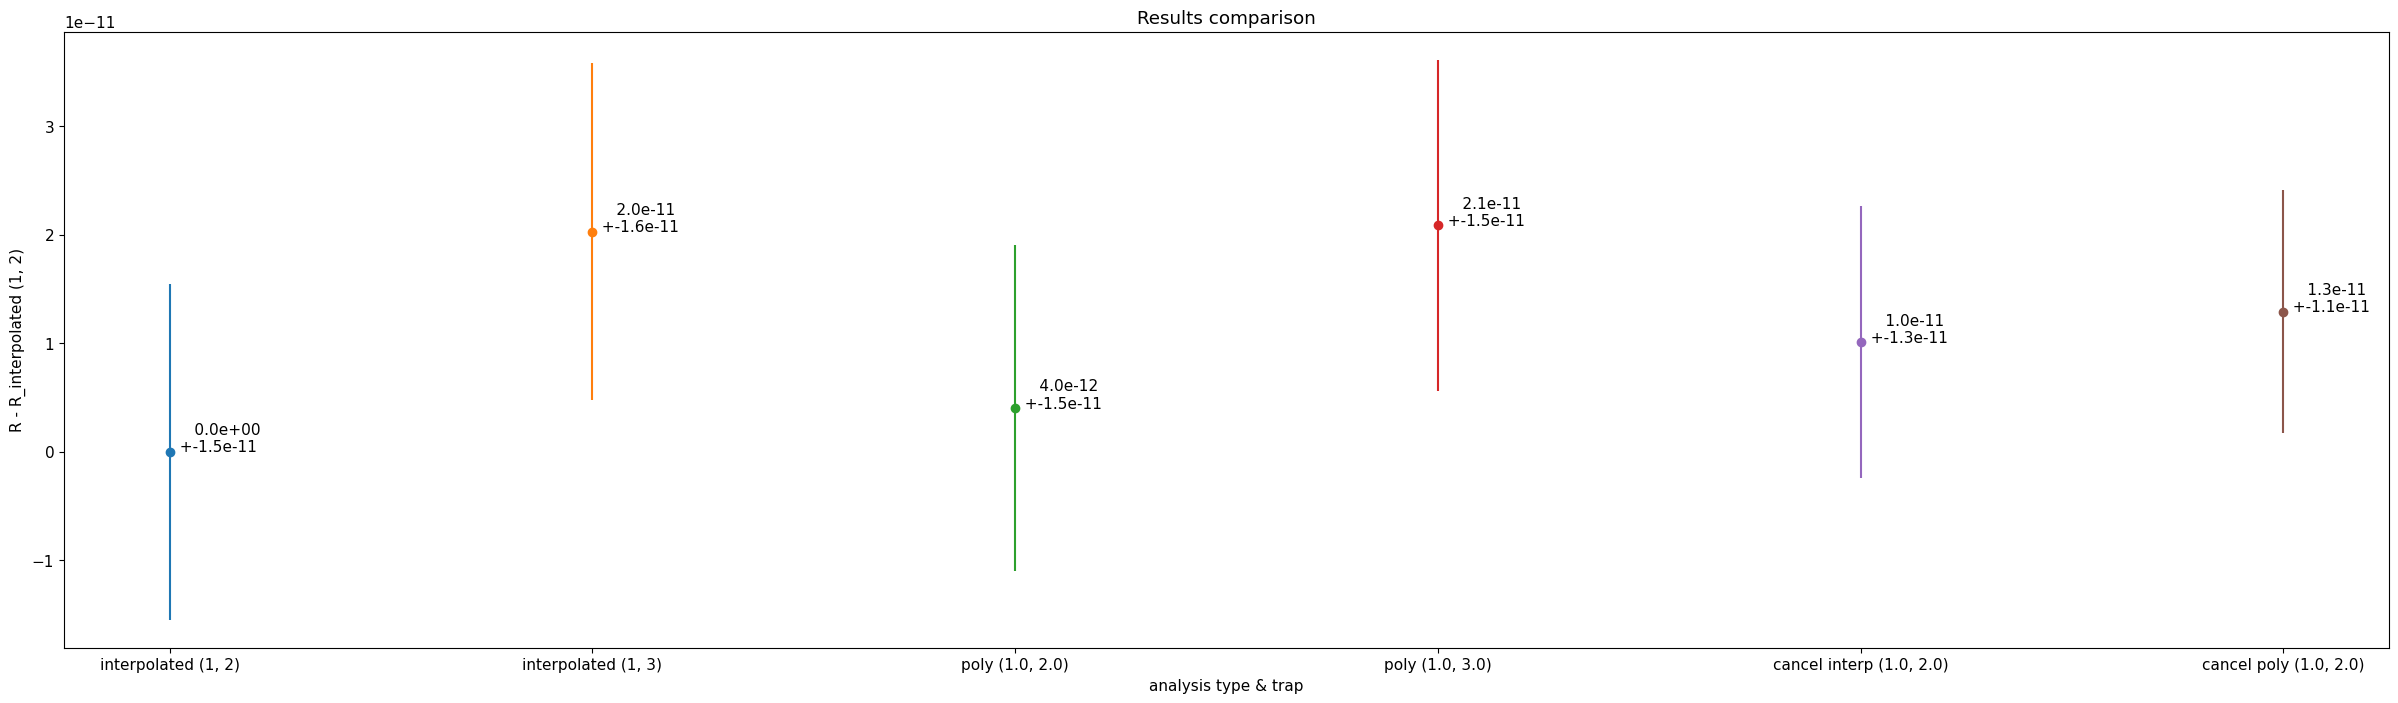

E:\git_repositories\ControlSystem3\repositories\ft-icr_toolkit\fticr_toolkit\visualization.py:801: UserWarning:

Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.



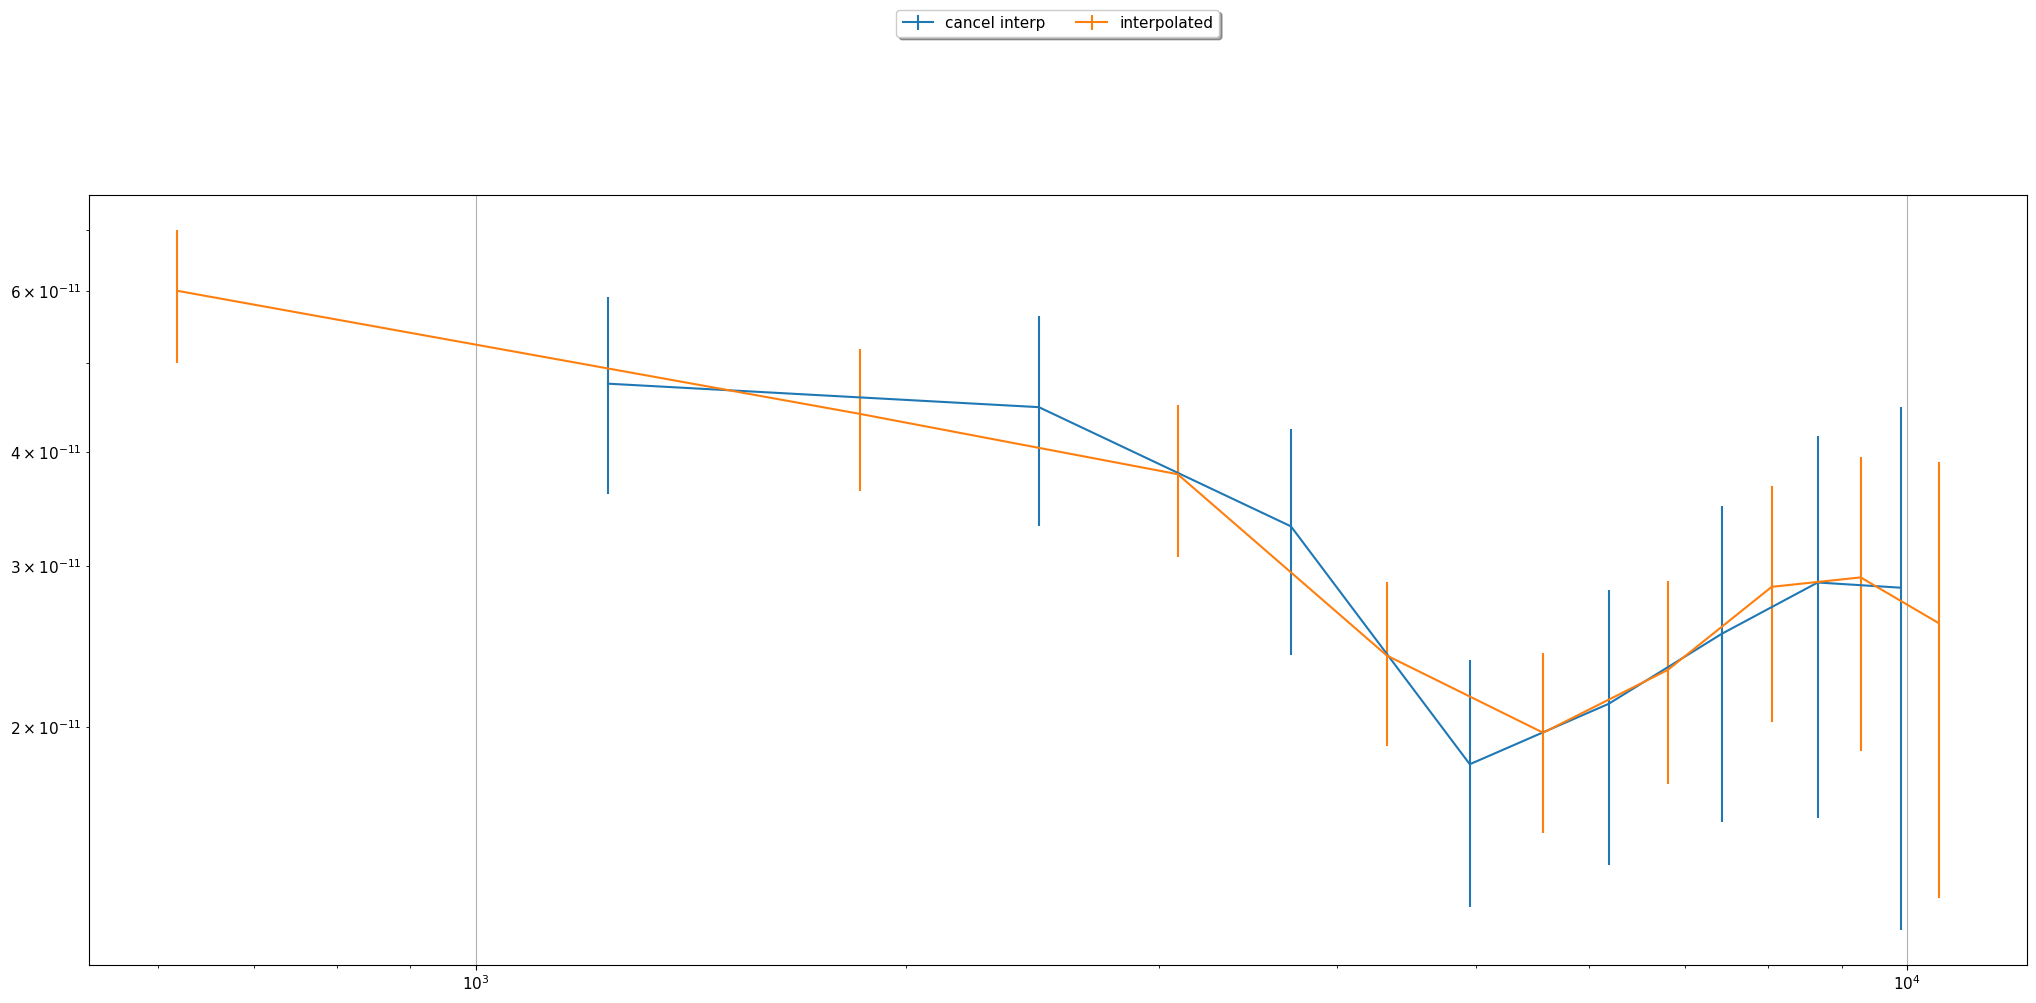

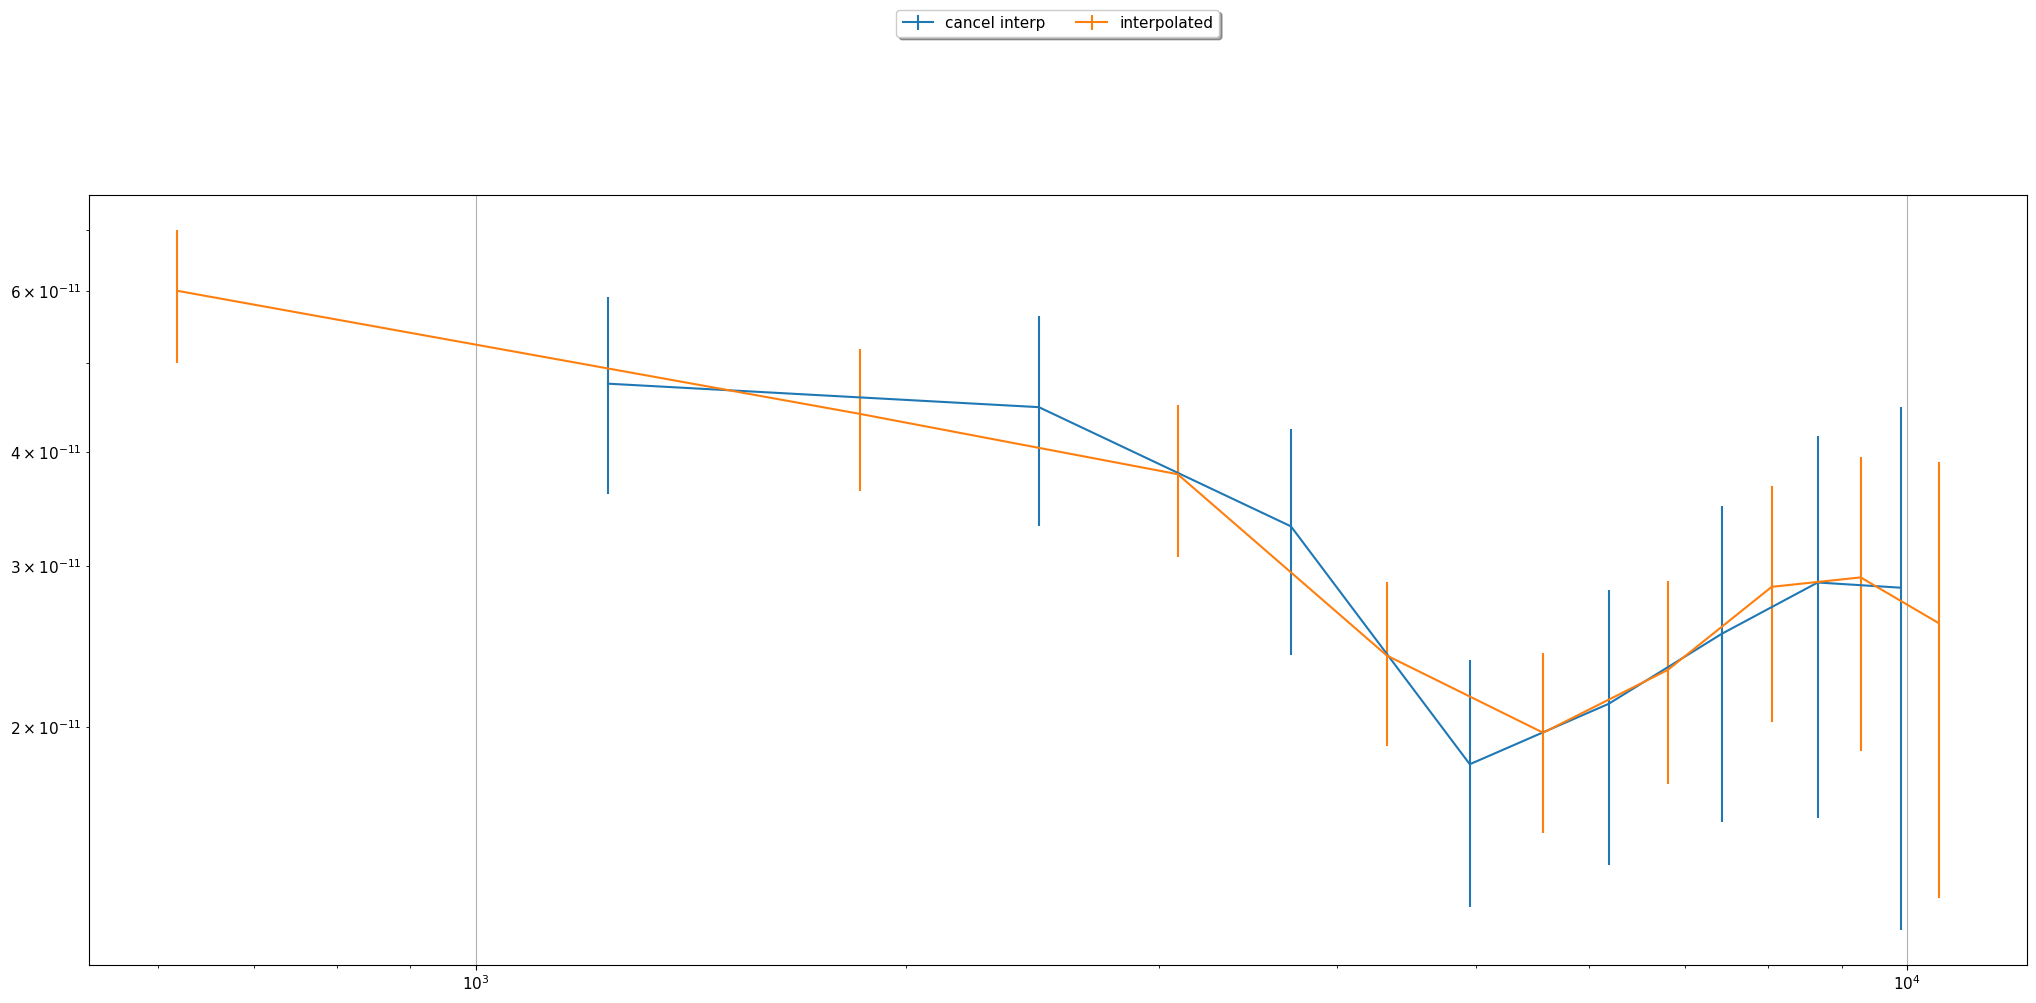

In [61]:


results = {
    "interpolated": step9_interpolate_results,
    "poly": step10_polyfit_best,
    "cancel interp": step12_cancel_interpol_results,
    "cancel poly": step13_cancel_polyfit_best,
}

visualization.compare(results, timecol='time_p', groupby=["mcycle", "trap"])
visualization.allancompare(results, time='time_p')

analysis type 	R-1     	err_in   	err_out   	chi2red   	(out/in) 	1+(0.477/sqrt(N))	# of R    	mean single err	R std	1/R	
interpolated 	0.0003781417958	0.0000000000105	0.0000000000105	0.9971238298881	0.9985608794100	1.0784183169447		37		0.0000000000643	0.0000000000636	0.9996220011413	10.4724638240076	
poly 	0.0003781417989	0.0000000000107	0.0000000000084	0.6187217952160	0.7865887077857	1.3372899346260		2		0.0000000000151	0.0000000000084	0.9996220011383	10.6944489757915	
cancel interp 	0.0003781417967	0.0000000000096	0.0000000000125	1.7053815089260	1.3059025648669	1.1124299782087		18		0.0000000000410	0.0000000000519	0.9996220011405	12.5081466489907	
cancel poly 	0.0003781417995	0.0000000000112	nan	nan	nan	1.4770000000000		1		0.0000000000112	0.0000000000000	0.9996220011377	11.2121046850768	


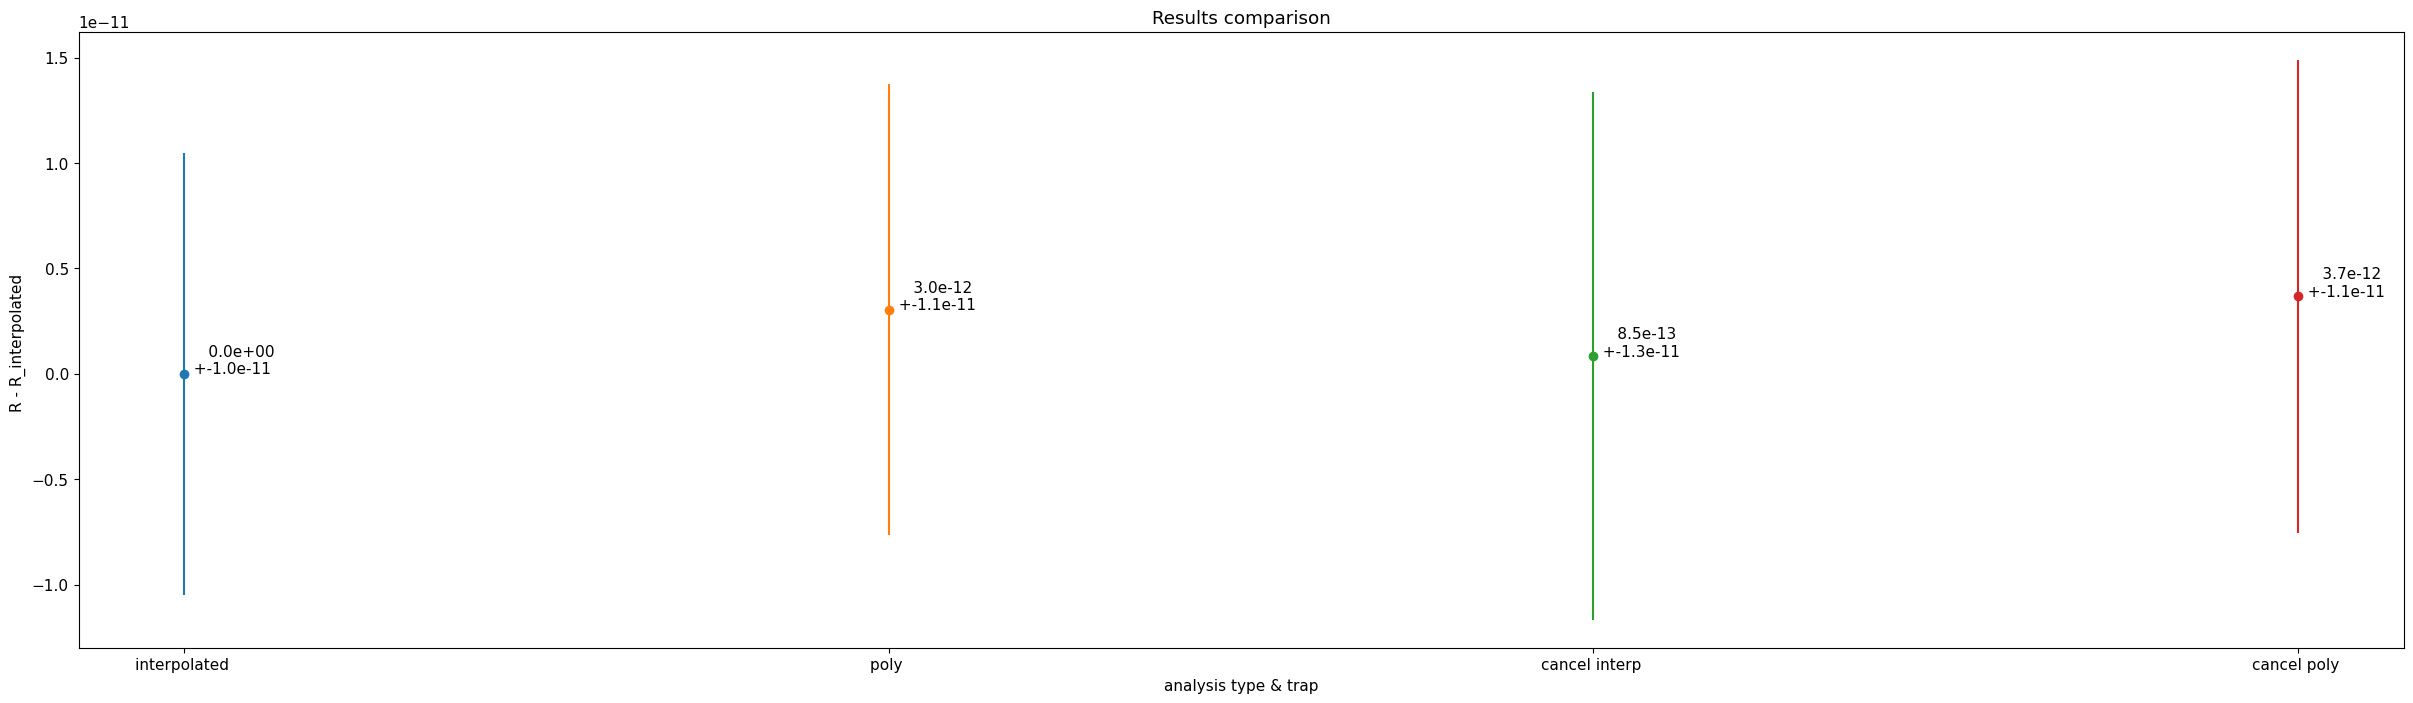

mcycle          Rminus              dR  \
0                1 -0.000377998859  0.000000000060   
1                1 -0.000377998894  0.000000000062   
2                1 -0.000377998971  0.000000000059   
3                1 -0.000377998865  0.000000000061   
4                1 -0.000377998808  0.000000000064   
5                1 -0.000377998893  0.000000000064   
6                1 -0.000377998981  0.000000000066   
7                1 -0.000377998879  0.000000000058   
8                1 -0.000377998694  0.000000000062   
9                1 -0.000377998837  0.000000000069   
10               1 -0.000377998855  0.000000000062   
11               1 -0.000377998851  0.000000000061   
12               1 -0.000377998767  0.000000000061   
13               1 -0.000377998832  0.000000000063   
14               1 -0.000377998753  0.000000000073   
15               1 -0.000377998799  0.000000000061   
16               1 -0.000377998818  0.000000000059   
17               1 -0.000377998871  0.000000000058   
18               1 -0.000377998882  0.000000000058   
19               1 -0.000377998888  0.000000000062   
20               1 -0.000377998889  0.000000000063   
21               1 -0.000377998947  0.000000000063   
22               1 -0.000377998839  0.000000000062   
23               1 -0.000377998820  0.000000000063   
24               1 -0.000377998816  0.000000000071   
25               1 -0.000377998898  0.000000000064   
26               1 -0.000377998842  0.000000000064   
27               1 -0.000377998910  0.000000000062   
28               1 -0.000377998845  0.000000000062   
29               1 -0.000377998908  0.000000000075   
30               1 -0.000377998906  0.000000000064   
31               1 -0.000377998755  0.000000000062   
32               1 -0.000377998817  0.000000000077   
33               1 -0.000377998754  0.000000000074   
34               1 -0.000377998938  0.000000000068   
35               1 -0.000377998921  0.000000000076   
36               1 -0.000377998940  0.000000000063   
37  1.000000000000  0.000378141791  0.000000000015   
38  1.000000000000  0.000378141807  0.000000000015   
39  1.000000000000 -0.000377998874  0.000000000038   
40  1.000000000000 -0.000377998891  0.000000000039   
41  1.000000000000 -0.000377998959  0.000000000038   
42  1.000000000000 -0.000377998852  0.000000000039   
43  1.000000000000 -0.000377998814  0.000000000040   
44  1.000000000000 -0.000377998854  0.000000000043   
45  1.000000000000 -0.000377998939  0.000000000041   
46  1.000000000000 -0.000377998861  0.000000000038   
47  1.000000000000 -0.000377998802  0.000000000039   
48  1.000000000000 -0.000377998841  0.000000000042   
49  1.000000000000 -0.000377998881  0.000000000044   
50  1.000000000000 -0.000377998878  0.000000000039   
51  1.000000000000 -0.000377998761  0.000000000039   
52  1.000000000000 -0.000377998824  0.000000000045   
53  1.000000000000 -0.000377998754  0.000000000048   
54  1.000000000000 -0.000377998868  0.000000000041   
55  1.000000000000 -0.000377998869  0.000000000044   
56  1.000000000000 -0.000377998905  0.000000000038   
57  1.000000000000  0.000378141800  0.000000000011   

                          time_p            trap       analysis  
0  2021-12-06 17:54:17.000000000               2   interpolated  
1  2021-12-06 18:14:53.000000000               2   interpolated  
2  2021-12-06 18:35:27.000000000               2   interpolated  
3  2021-12-06 18:56:01.000000000               2   interpolated  
4  2021-12-06 19:16:37.000000000               2   interpolated  
5  2021-12-06 19:37:13.000000000               2   interpolated  
6  2021-12-06 19:57:50.000000000               2   interpolated  
7  2021-12-06 20:18:26.000000000               2   interpolated  
8  2021-12-06 20:39:03.000000000               2   interpolated  
9  2021-12-06 20:59:41.000000000               2   interpolated  
10 2021-12-06 21:20:19.000000000               2   interpolated  
11 2021-12-06 21:40:56.000000000 

In [62]:
visualization.compare(results, timecol='time_p', groupby=None)

#### """
data_to_look_at = step8_naive_results_merged
#data_to_look_at = step11_cancel_naive_results_merged
#data_to_look_at = step7_results[ (step7_results['trap']==2) & (step7_results['position']=='position_2') & (step7_results['masked']==False) ]
#ycol = 'R'
ycol = 'nu_c'
tcol = 'time_p'
data_to_look_at.sort_values(tcol)

data_to_look_at['epoch'] = data_to_look_at[tcol].astype("int64")//1e9
data_to_look_at['seconds'] = data_to_look_at['epoch'] - data_to_look_at['epoch'].min()
statistics.allantest(data_to_look_at[ycol].to_numpy(), data_to_look_at.seconds.to_numpy())
"""

In [63]:
# Some more or less interesting data checks

drift unwrap! x 4 value before 5.8010358810424805 expected 7.3049292266368875 current 0.7751509547233582 new 7.058336261902944
drift unwrap! x 9 value before 12.47140103975405 expected 12.126394914800779 current 7.1686018149005335 new 13.45178712208012
drift unwrap! x 20 value before 17.626420625040325 expected 17.85578495792832 current 12.818528749534877 new 19.101714056714464
drift unwrap! x 29 value before 19.49526656864493 expected 24.24220188347756 current 19.066544082745004 new 25.34972938992459
drift unwrap! x 30 value before 25.34972938992459 expected 25.11490326402148 current 30.743167654652183 new 24.459982347472597
drift unwrap! x 31 value before 24.459982347472597 expected 25.76257372440775 current 19.61206240652411 new 25.895247713703696
drift unwrap! x 44 value before 26.618833438534324 expected 30.890421301181277 current 25.51097153224427 new 31.794156839423856
drift unwrap! x 57 value before 37.390150149636945 expected 36.80338495706888 current 31.802888323837003 new 38

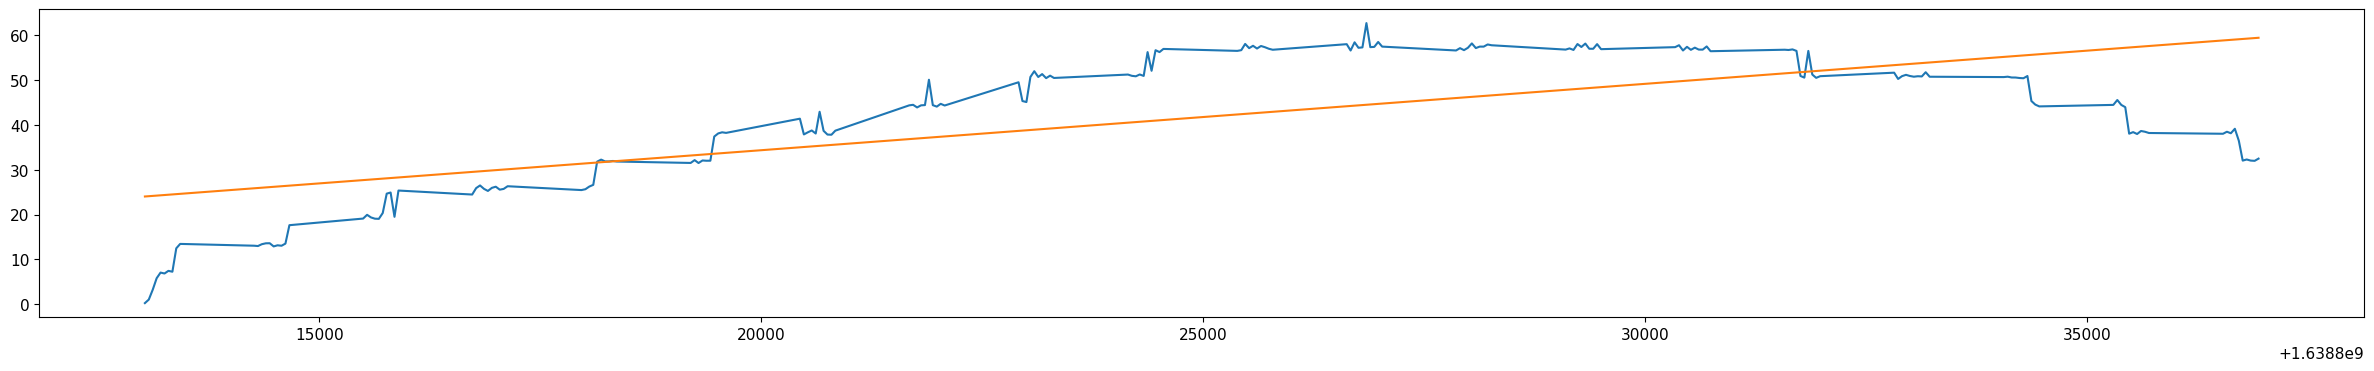

[-9.393127848621e-06  1.539579370901e+04]


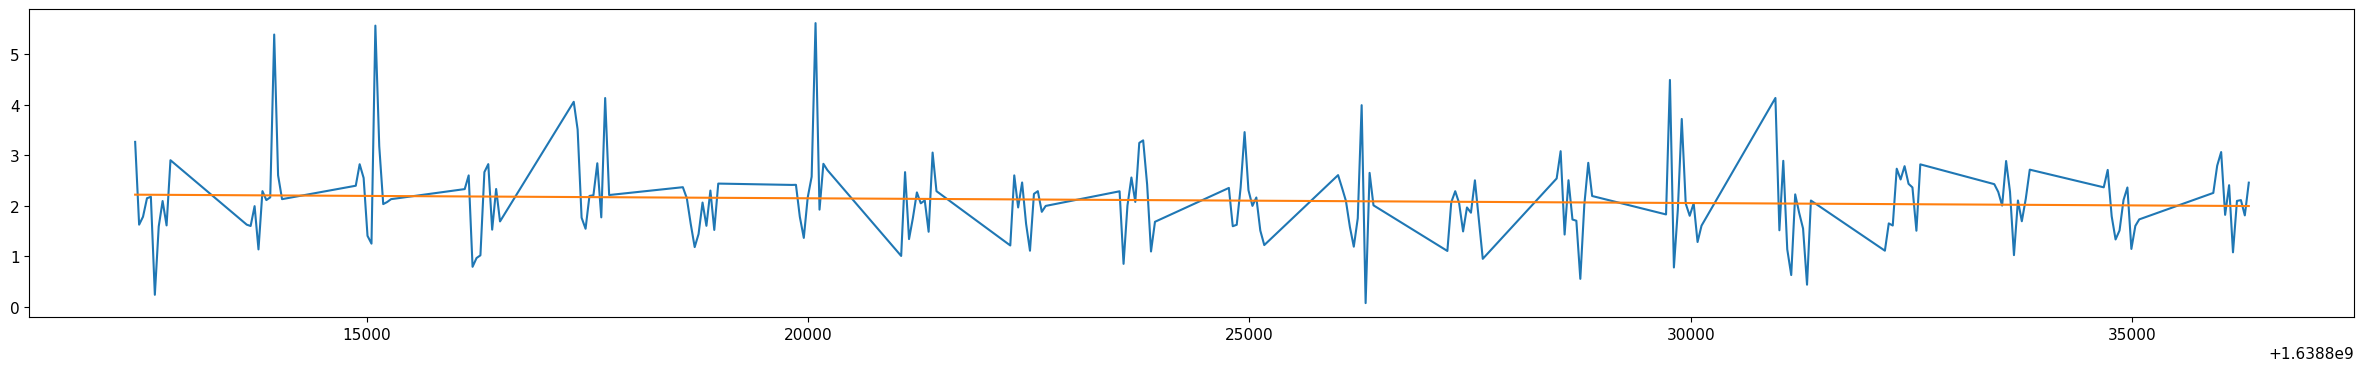

drift unwrap! x 3 value before 4.893768787384033 expected 6.627490401268005 current 0.293913334608078 new 6.577098641787664
drift unwrap! x 5 value before 12.405276123677389 expected 13.970376052650915 current 7.1092862526523035 new 13.39247155983189
drift unwrap! x 8 value before 17.841266759226116 expected 22.436098991462615 current 12.623808715978655 new 18.90699402315824
drift unwrap! x 9 value before 18.90699402315824 expected 23.764875441828277 current 19.019694340213228 new 25.302879647392814
drift unwrap! x 13 value before 31.123619810719077 expected 33.37155365074011 current 25.385577545542304 new 31.66876285272189
drift unwrap! x 16 value before 37.37207182245799 expected 39.44785099433123 current 31.7252153952653 new 38.00840070244489
drift unwrap! x 18 value before 42.95092573162732 expected 44.232463568302194 current 37.878688240019656 new 44.16187354719924
drift unwrap! x 22 value before 50.04269811308669 expected 54.32088886347153 current 49.147125927570336 new 55.430311

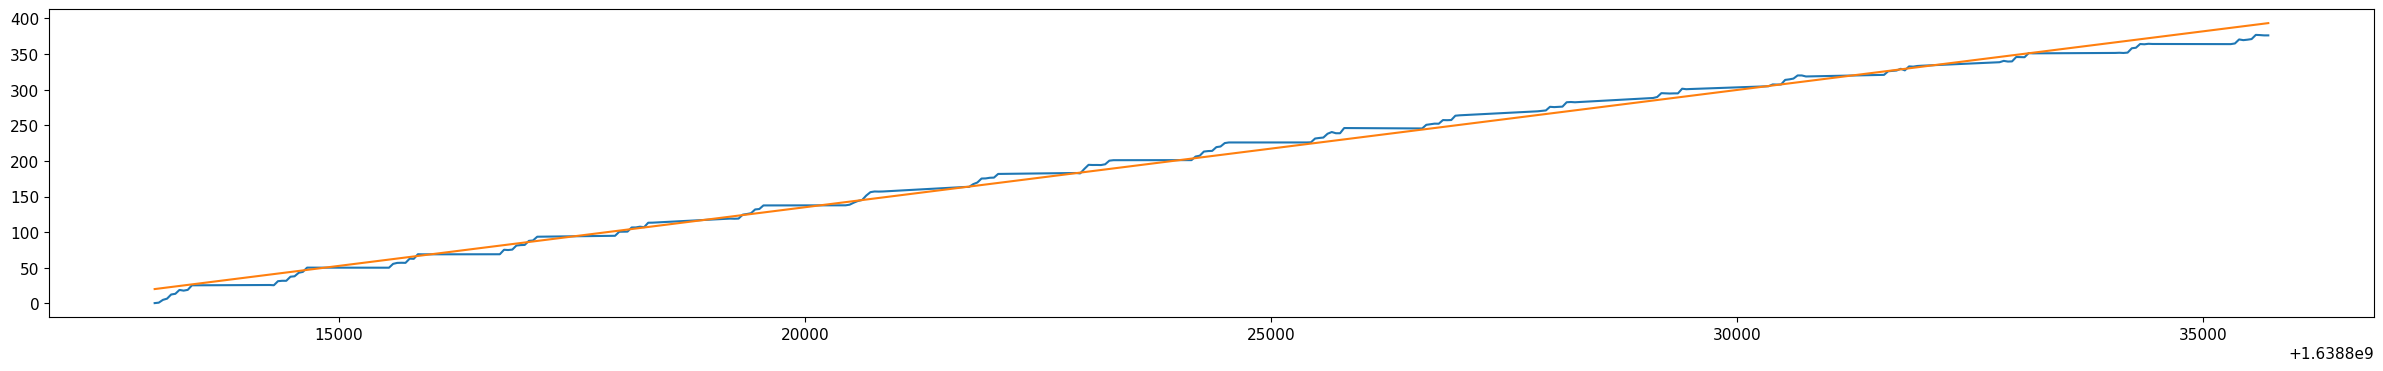

[ 6.014532883478e-06 -9.853062291627e+03]


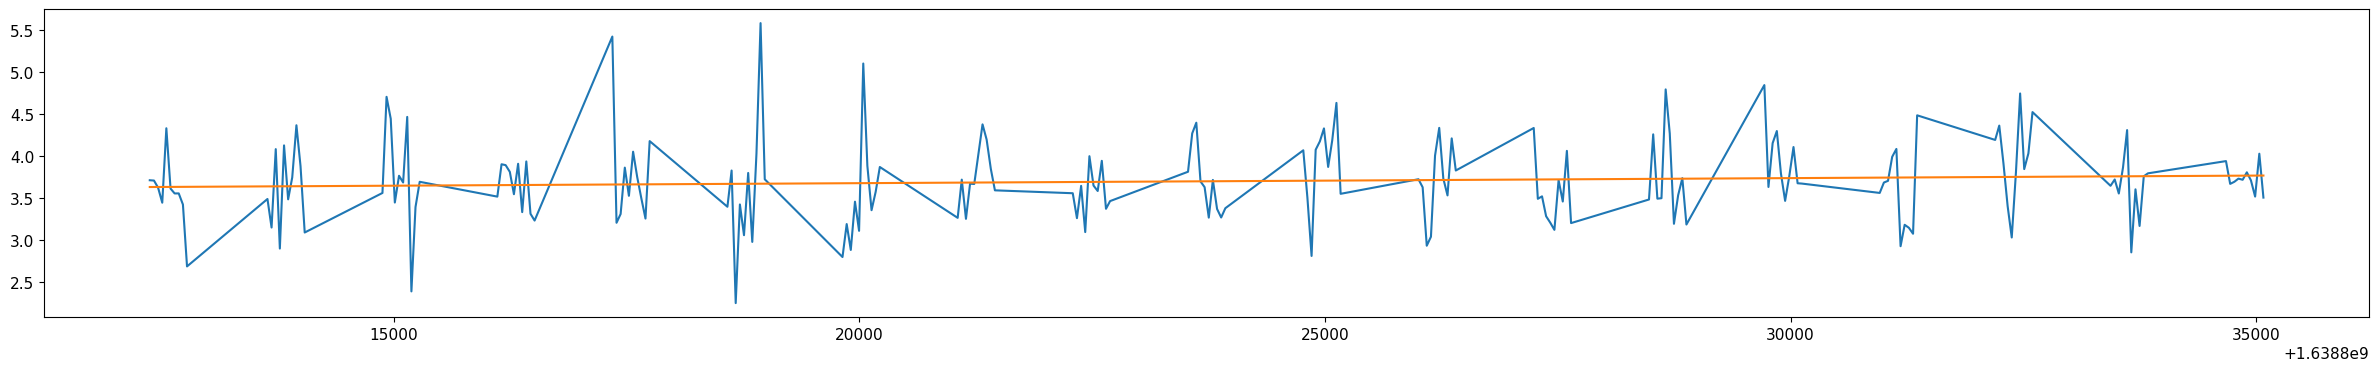

{2: [0.0014796169103925556, -9.39312784862109e-06], 3: [0.01647015752338335, 6.014532883477869e-06]}
0.08923333511710473
1.4605326600180912
-0.9389035674724321
-1.3712993249009866
1.5242105263157895


In [64]:
# linear fits of axial reference phase
copyphases = nu_p_phases.copy()
copyphases['epoch'] = copyphases['time'].astype('int64')//1e9

slopes = {
    2: [],
    3: []
}
for grpname, grp in copyphases.groupby(['trap', 'position', 'acc_time']):
    if grpname[-1] != copyphases.acc_time.min():
        continue
    grp_new = phase_analysis.unwrap_dset(grp, column="phase", drift_unwrap=True, drift_pi_span=1.5, timesort=True, reverse=False, show=False)
    phases = grp_new['phase'].to_numpy()
    times = grp_new['epoch'].to_numpy()
    
    opt = np.polyfit(times,phases, 1)
    print(opt)
    slopes[grpname[0]].append(opt[0])
    plt.plot(times, phases)
    plt.plot(times, opt[1] + opt[0]*times)
    plt.show()
    
print(slopes)
print(np.mean(slopes[2])/np.mean(slopes[3]))
print(732536.1/501554.07)
print((np.mean(slopes[2])/np.mean(slopes[3]) - 732536.1/501554.07)/(732536.1/501554.07))
print((np.mean(slopes[2])/np.mean(slopes[3]) - 732536.1/501554.07))
print(724000/475000)

# Ratio allan deviation 

6.855850595215237e-11 6.216606150827355e-11 1.572839995608231e-11


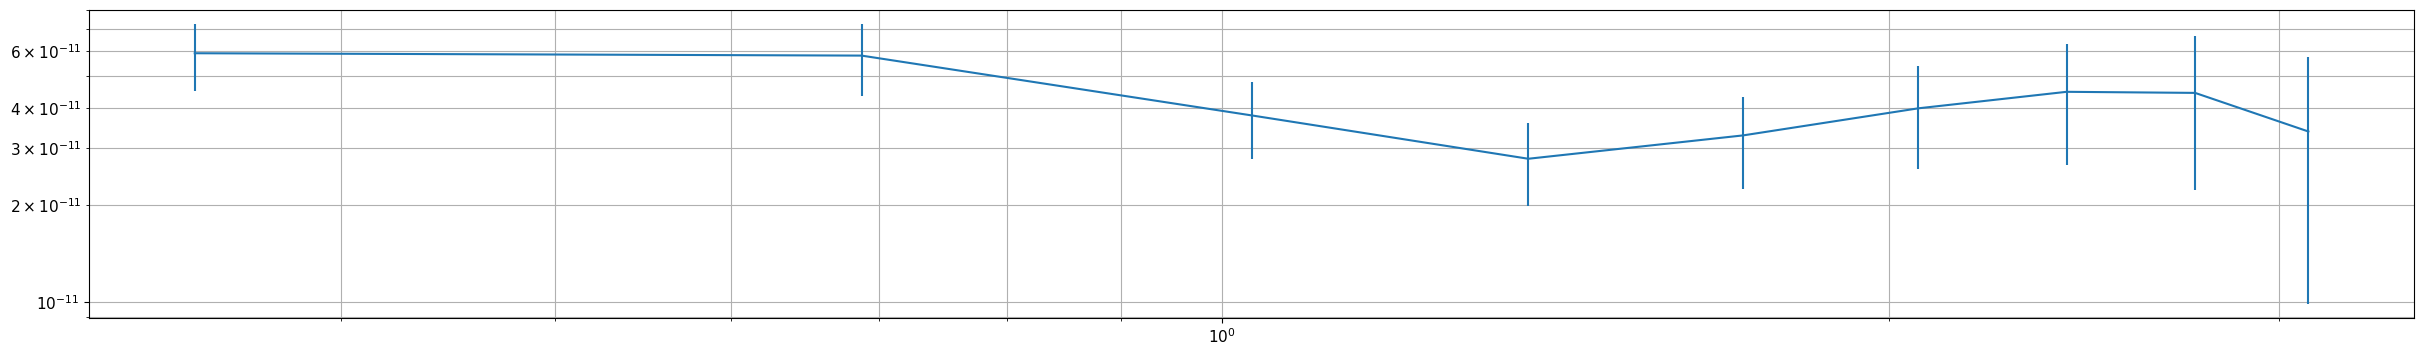

5.985392454738457e-11 6.642799914321512e-11 1.4107705309361197e-11
20.6


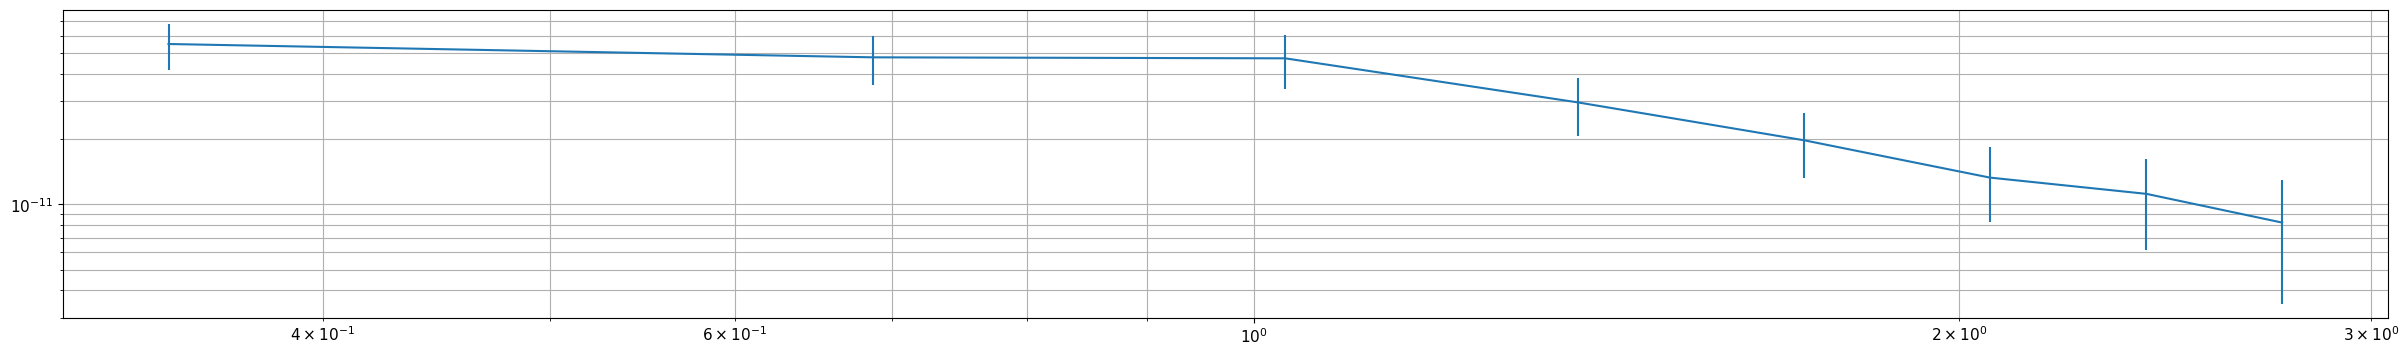

In [65]:

test = step9_interpolate_results[step9_interpolate_results['trap']==2]
print(test.R.std(), test.dR.mean(), test.R.std()/np.sqrt(test.R.size))

R = test.R.to_numpy()
time = test.time_p.astype("int64")//1e9
time = time.to_numpy()
time = time - time.min()
time = time/60/60

blubb = visualization.allanvariance(R/np.mean(R), time, plot=True)


test = step9_interpolate_results[step9_interpolate_results['trap']==3]
print(test.R.std(), test.dR.mean(), test.R.std()/np.sqrt(test.R.size))

R = test.R.to_numpy()
time = test.time_p.astype("int64")//1e9
time = time.to_numpy()
time = time - time.min()
time = time/60/60
print(time[1]*60)

blubb = visualization.allanvariance(R/np.mean(R), time, plot=True)


# VOLTAGE STABILITY by axial

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:2: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



0.10354612467978459 736086.30393125 0.023153617359066698


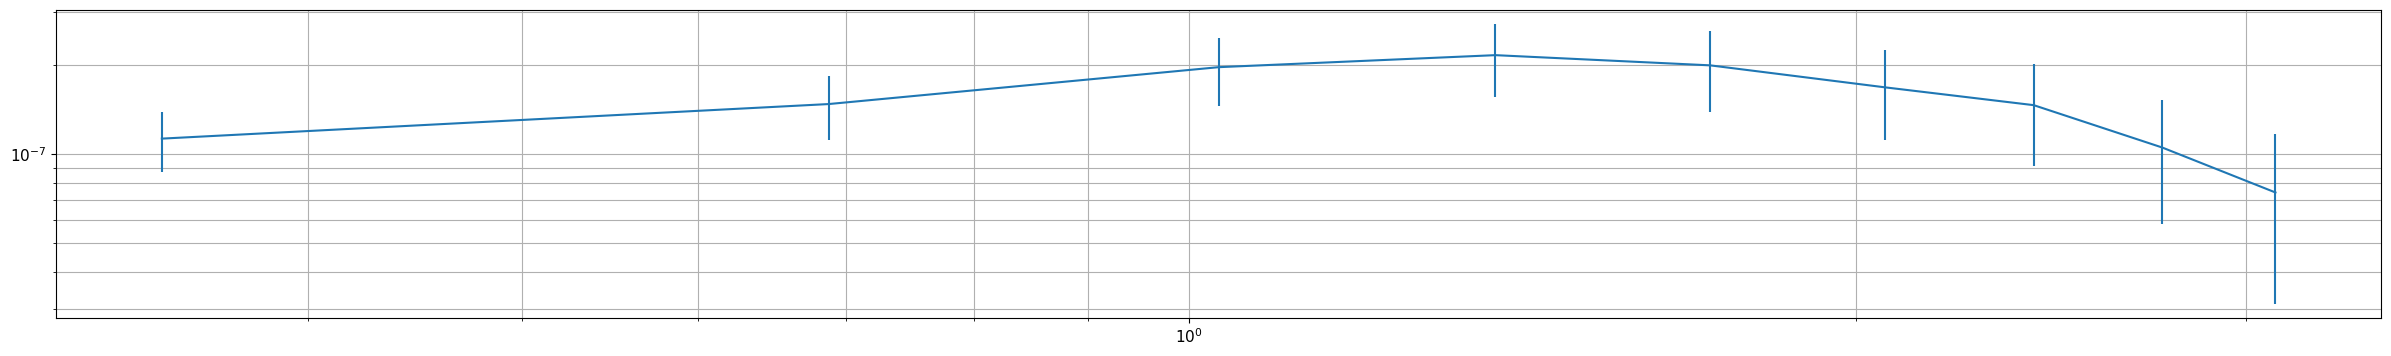

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:15: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



0.10488072778933868 736086.3796915452 0.023452043686661254


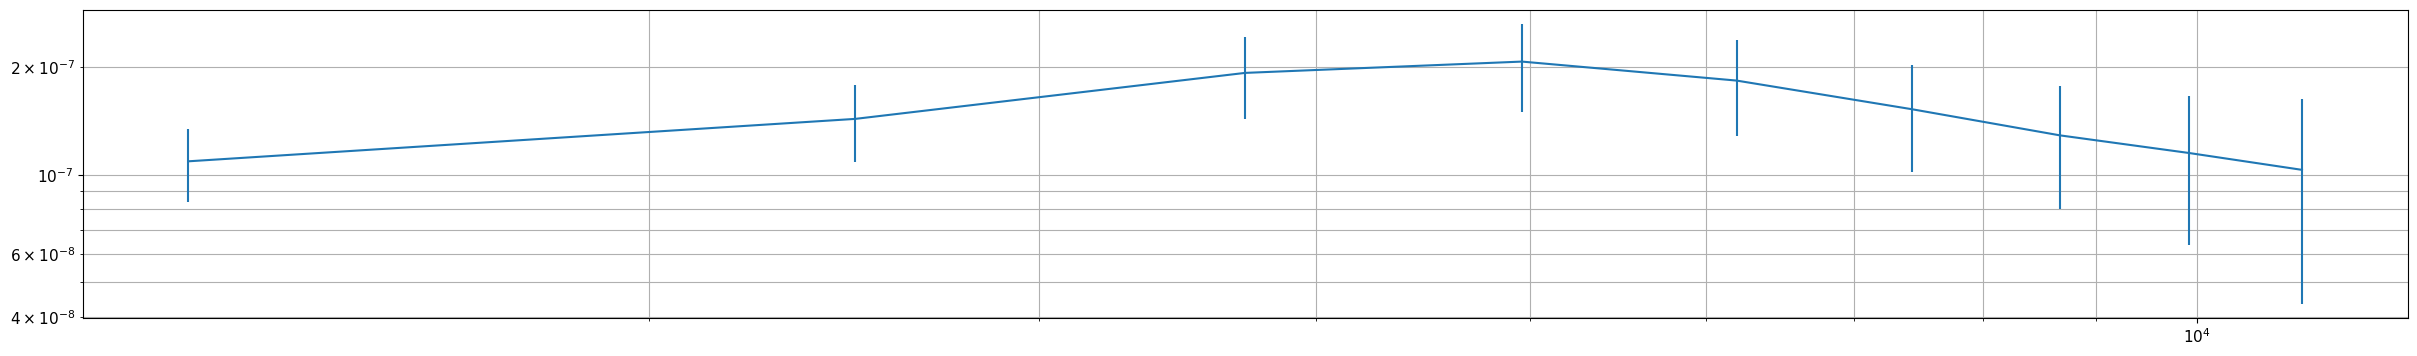

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:28: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



0.03876561874395396 501499.51149594114 0.008893442873090603


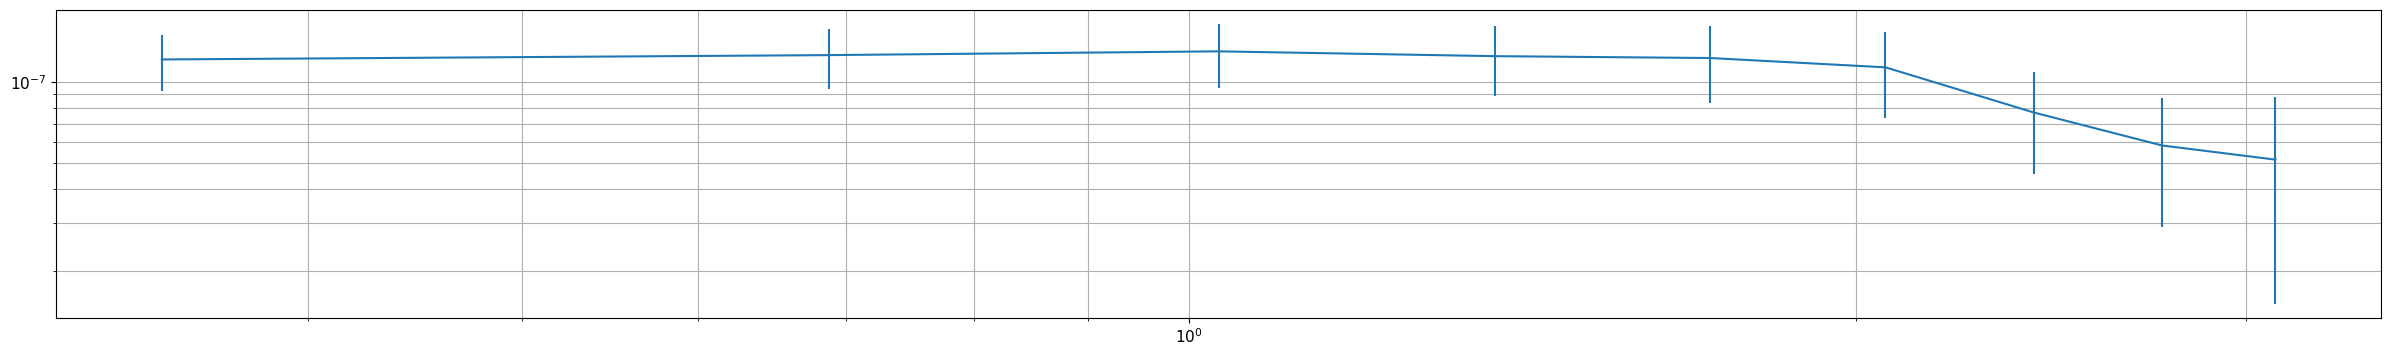

c:\program files\python37\lib\site-packages\ipykernel_launcher.py:41: UserWarning:

Boolean Series key will be reindexed to match DataFrame index.



0.03876561874395396 501499.51149594114 0.008893442873090603
1235.0
20.583333333333332
0.34305555555555556


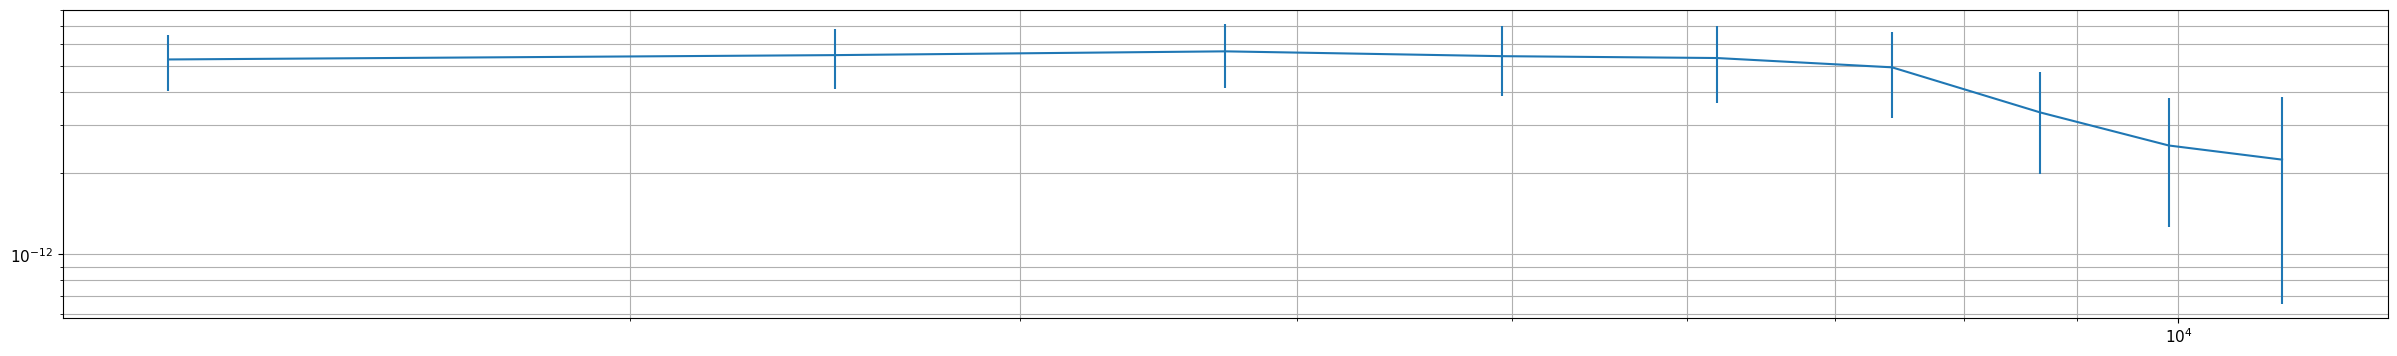

In [66]:
test = step5_all_freqs[step5_all_freqs['trap']==2]
test = test[step5_all_freqs['position']=="position_1"]
print(test.nu_z.std(), test.nu_z.mean(), test.nu_z.std()/np.sqrt(test.nu_z.size))

nuz = test.nu_z.to_numpy()
time = test.time.astype("int64")//1e9
time = time.to_numpy()
time = time - time.min()
time = time/60/60

blubb = visualization.allanvariance(nuz/np.mean(nuz)*2, time, plot=True)


test = step5_all_freqs[step5_all_freqs['trap']==2]
test = test[step5_all_freqs['position']=="position_2"]
print(test.nu_z.std(), test.nu_z.mean(), test.nu_z.std()/np.sqrt(test.nu_z.size))

nuz = test.nu_z.to_numpy()
time = test.time.astype("int64")//1e9
time = time.to_numpy()
time = time - time.min()
time = time

blubb = visualization.allanvariance(nuz/np.mean(nuz)*2, time, plot=True)


test = step5_all_freqs[step5_all_freqs['trap']==3]
test = test[step5_all_freqs['position']=="position_1"]
print(test.nu_z.std(), test.nu_z.mean(), test.nu_z.std()/np.sqrt(test.nu_z.size))

nuz = test.nu_z.to_numpy()
time = test.time.astype("int64")//1e9
time = time.to_numpy()
time = time - time.min()
time = time/60/60

blubb = visualization.allanvariance(nuz/np.mean(nuz)*2, time, plot=True)


test = step5_all_freqs[step5_all_freqs['trap']==3]
test = test[step5_all_freqs['position']=="position_1"]
print(test.nu_z.std(), test.nu_z.mean(), test.nu_z.std()/np.sqrt(test.nu_z.size))

nuz = test.nu_z.to_numpy()
nuc = test.nu_p.to_numpy()
time = test.time.astype("int64")//1e9
time = time.to_numpy()
time = time - time.min()
time = time
print(time[1])
print(time[1]/60)
print(time[1]/60/60)

invariance_factor = (np.mean(nuz)/np.mean(nuc))**2
blubb = visualization.allanvariance(nuz/np.mean(nuz)*invariance_factor, time, plot=True)

In [67]:

"""
ion_num = step8_naive_results_merged['ion_numer'].unique()[0]
ion_den = step8_naive_results_merged['ion_denom'].unique()[0]
from uncertainties import ufloat

results = {
    "interpolated ": step9_interpolate_results,
    "poly all     ": step10_polyfit_best,
}

omegac_ref = omegac_ioi = omegap_ref = omegap_ioi = omegam_ref = omegam_ioi = None
exc_radius = ufloat(20, 5)*1e-6

x = []
y = []
dy = []
for trap, grp in step7_results.groupby(['trap']):

    pos_ref = grp[grp['ion'] == ion_den]
    pos_ioi = grp[grp['ion'] == ion_num]
        
    omegac_ref = ufloat(pos_ref.nu_c.mean()*2*np.pi, 0.1)
    omegap_ref = ufloat(pos_ref.nu_p.mean()*2*np.pi, 1)
    omegam_ref = ufloat(pos_ref.nu_m.mean()*2*np.pi, 1)
            
    omegac_ioi = ufloat(pos_ioi.nu_c.mean()*2*np.pi, 0.1)
    omegap_ioi = ufloat(pos_ioi.nu_p.mean()*2*np.pi, 1)
    omegam_ioi = ufloat(pos_ioi.nu_m.mean()*2*np.pi, 1)
    

    for name, data in results.items():
        
        tdata = data[data['trap'] == trap]
        ratios = tdata.R.to_numpy()
        dratios = tdata.dR.to_numpy()
        R, err_in, err_out, chi2red = statistics.complete_mean_and_error(ratios, dvalue = dratios)
        dR = max(err_in, err_out)
        uR = ufloat(R, dR)
        #print((uR-1)*1e12)
        if uR.n > 1:
            uR = 1/uR
        
        Eb_ref = ufloat(31529.1, 8.8)
        Eb_ioi = Eb_ref
        eV, Q, nRatio = systematics.neutral_mass(uR.n, uR.s, ion_den, ion_num, Rcompare=None,
                        Eb_ref=Eb_ref, Eb_ioi=Eb_ioi,
                        sys_on=True, exc_radius=exc_radius, show=False,
                         omegac_ref=omegac_ref, omegac_ioi=omegac_ioi, omegap_ref=omegap_ref, omegap_ioi=omegap_ioi,
                         omegam_ref=omegam_ref, omegam_ioi=omegam_ioi)
        
        #print((nRatio-1)*1e12)

        print(name, trap, eV, Q, nRatio, 1/nRatio, nRatio.s/nRatio.n, uR, 1/uR, uR.s/uR.n)
        x.append(name.strip()+'_'+str(trap))
        y.append(nRatio.n)
        dy.append(nRatio.s)

uRn_rana = ybrana.make_ybratio(ion_num[:-3], ion_den[:-3])
uRn_rana = 1/uRn_rana
print(uRn_rana)
plt.rcParams["figure.figsize"] = (20,10)

plt.errorbar(['rana'], [uRn_rana.n], [uRn_rana.s] )
plt.errorbar(x, y, dy)
plt.show()
#uR = 1/uR
"""

'\nion_num = step8_naive_results_merged[\'ion_numer\'].unique()[0]\nion_den = step8_naive_results_merged[\'ion_denom\'].unique()[0]\nfrom uncertainties import ufloat\n\nresults = {\n    "interpolated ": step9_interpolate_results,\n    "poly all     ": step10_polyfit_best,\n}\n\nomegac_ref = omegac_ioi = omegap_ref = omegap_ioi = omegam_ref = omegam_ioi = None\nexc_radius = ufloat(20, 5)*1e-6\n\nx = []\ny = []\ndy = []\nfor trap, grp in step7_results.groupby([\'trap\']):\n\n    pos_ref = grp[grp[\'ion\'] == ion_den]\n    pos_ioi = grp[grp[\'ion\'] == ion_num]\n        \n    omegac_ref = ufloat(pos_ref.nu_c.mean()*2*np.pi, 0.1)\n    omegap_ref = ufloat(pos_ref.nu_p.mean()*2*np.pi, 1)\n    omegam_ref = ufloat(pos_ref.nu_m.mean()*2*np.pi, 1)\n            \n    omegac_ioi = ufloat(pos_ioi.nu_c.mean()*2*np.pi, 0.1)\n    omegap_ioi = ufloat(pos_ioi.nu_p.mean()*2*np.pi, 1)\n    omegam_ioi = ufloat(pos_ioi.nu_m.mean()*2*np.pi, 1)\n    \n\n    for name, data in results.items():\n        \n      